# Testing different spot number and dropout-Charlotte (220816)

## Load modules

In [1]:
# import pools
import os
import sys
import itertools
from math import pi, sin, cos, sqrt
import numpy as np
import matplotlib.pyplot as plt

import cv2
from matplotlib import cm
from scipy import ndimage
import scipy.io
from skimage import data
from skimage.io import imread, imsave
import pandas as pd
from scipy.spatial import cKDTree
from cv2 import estimateTranslation3D
import tifffile
import seaborn as sns

# import bigstream library
import zarr
import z5py
from bigstream import features
#from bigstream import features1
from bigstream import ransac
from bigstream import affine
#from bigstream import affine1
from bigstream import transform
from fishspot.filter import white_tophat
from fishspot.detect import detect_spots_log

# napari
%gui qt5
import napari
# viewer = napari.view_image(data.astronaut(), rgb=True)
# napari.run()
import csv

### Colocalization filter 

In [2]:
def eucldist(coords1, coords2):
    """ Calculates the euclidean distance between 2 lists of coordinates. """
    dist = np.zeros(len(coords1))
    i = 0
    for (x, y) in zip(coords1, coords2):
        p1 = x
        p2 = y
        squared_dist = (p1[0]-p2[0])**2+(p1[1]-p2[1])**2+(p1[2]-p2[2])**2
        dist[i] = np.sqrt(squared_dist)
        i = i+1
    return dist

def cloud_distance(spot_fix,spot_mov):
    """compute distance of nearest spot cloud by KNN.
    """
    c0=spot_fix[:,:3].copy()
    c1=spot_mov[:,:3].copy()
    kdtree_c0 = cKDTree(c0)
    kdtree_c1 = cKDTree(c1)
    dist2,idx2 = kdtree_c0.query(c1, k=3)
    [Idx_unique, I] = np.unique(idx2,return_index=True)  
    return dist2[:,0]

def colocalization(spot_c0,spot_c1,neighbor_radius):
    #vox=[0.23,0.23,0.38]
    c0=spot_c0[:,:3].copy()
    c1=spot_c1[:,:3].copy()

    kdtree_c0 = cKDTree(c0)
    kdtree_c1 = cKDTree(c1)
    neighbors = kdtree_c0.query_ball_tree(kdtree_c1, neighbor_radius)
    dist2,idx2 = kdtree_c0.query(c1, k=3)
    [Idx_unique, I] = np.unique(idx2,return_index=True) 
    ## find the smallest repeated value location, and delete the others
    for i in range(Idx_unique.shape[0]):  # should repeat for only once
    #     print(Idx_unique[i])
        Loc_rep=np.where(idx2==Idx_unique[i])    
    #     print(Loc_rep[0])
        A=dist2[Loc_rep[0],Loc_rep[1]]
        minposition = min(A)
        Loc_min = np.where(A==minposition)[0]
    #     print(Loc_min)
    #     Loc_rep_min=Loc_rep[0][Loc_min[0]]    
        Loc_rep_nouse=np.delete(range(len(Loc_rep[0])),Loc_min)
        dist2[Loc_rep[0][Loc_rep_nouse],Loc_rep[1][Loc_rep_nouse]]=neighbor_radius*2 
    ## find the results that are less than radius; used later column data 
    # when only first row is not exist use latter column, or just dispose it. 
    co_loc=np.where(dist2>neighbor_radius)

    for j in range(dist2.shape[0]):
         if dist2[j,0] < neighbor_radius:
                dist2[j,1] = neighbor_radius*2
    for j in range(dist2.shape[0]):            
         if dist2[j,0] <neighbor_radius or dist2[j,1] <neighbor_radius:
                dist2[j,2] = neighbor_radius*2       
    row_c1 = np.where(dist2<neighbor_radius)
#     print(len(row_c1[0]))

    # lipo spot_c1 is row_c1
    pBind = row_c1[0]
    # print(idx2)
    # lipo spot_c1 is idx2
    pAind = [(idx2[row_c1[0][x], row_c1[1][x]]) for x in range(len(row_c1[0]))]
    lipo_c0 = spot_c0[pAind]
    lipo_c1 = spot_c1[pBind]

#     print(np.unique(pAind).shape) 
    true_pos_c0 = np.delete(spot_c0, pAind, axis=0)
    true_pos_c1 = np.delete(spot_c1, pBind, axis=0) #true

    if spot_c0.shape[0]>0:
        P1 = (lipo_c0.shape[0] / spot_c0.shape[0])*100   # % mov spots from  previous images  /spot_c0.shape
    else:
        P1 = 0
        
    if spot_c1.shape[0]>0:
        P2 = (lipo_c1.shape[0] / spot_c1.shape[0])*100  # % fixed spots can be found in later mov images  /spot_c0.shape
    else:
        P2 = 0
#     print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
    Dist = np.mean(eucldist(lipo_c0,lipo_c1))

    return lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,Dist,P1,P2

def get_spot_inside(all_spots,segmentation_mini,fix_spacing,ROI_fixed,cc):
    """remove spots outside of a segmenation mask
       change spot location back to segmentation mask in pixels
    """
    fix_spots_mini = all_spots[:,:3] / fix_spacing * [0.5,0.25,0.25] + cc
    spot_mini = np.zeros(len(fix_spots_mini))
    rounded_spot = fix_spots_mini.astype('int') 
    for i in range(0, len(fix_spots_mini)):          
        Coord = rounded_spot[i]
        if Coord[0]<0: Coord[0] = 0
        if Coord[1]<0: Coord[1] = 0
        if Coord[2]<0: Coord[2] = 0
        if Coord[0]>segmentation_mini.shape[0]: Coord[0] = segmentation_mini.shape[0]
        if Coord[1]>segmentation_mini.shape[1]: Coord[1] = segmentation_mini.shape[1]            
        if Coord[2]>segmentation_mini.shape[2]: Coord[2] = segmentation_mini.shape[2]
        idx = segmentation_mini[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # roi id
        if idx == ROI_fixed:
            spot_mini[i] = idx  # add ROI number  
    spots_in = all_spots[np.where(spot_mini==ROI_fixed)]
    spots_out = all_spots[np.where(spot_mini==0)]
    
    spots_in_index = np.where(spot_mini==ROI_fixed)
    ns = spots_in.shape[0]
#     print(f'Image: found {ns} key points inside ROI')
    print(f'Image: found {spots_out.shape[0]} key points outside ROI')
    return spots_in,spots_in_index

## ICP
def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nx3 array of points
        dst: Nx3 array of points
    Output:
        distances: Euclidean distances (errors) of the nearest neighbor
        indecies: dst indecies of the nearest neighbor
    '''
    indecies = np.zeros(src.shape[0], dtype=np.int)
    distances = np.zeros(src.shape[0])
    for i, s in enumerate(src):
        min_dist = np.inf
        for j, d in enumerate(dst):
            dist = np.linalg.norm(s-d)
            # find Nearest dst[j] to src[i]
            if dist < min_dist:
                min_dist = dist
                indecies[i] = j
                distances[i] = dist
    return distances, indecies  

def get_scale(A,B):
    dis_A=get_all_side_length(np.array(A))
    dis_B=get_all_side_length(np.array(B))
    scale = np.abs(dis_B/dis_A)
    mask=np.abs(scale)>0.0001
    scale_sort=np.sort(scale[mask].reshape(-1))
    d_n=len(scale_sort)
    s_mean=scale_sort[int(d_n/4):int(d_n*3/4)].mean() #only use medium data
    return s_mean

def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform between corresponding 3D points A->B
    Input:
      A: Nx3 numpy array of corresponding 3D points
      B: Nx3 numpy array of corresponding 3D points
    Returns:
      T: 4x4 homogeneous transformation matrix
      R: 3x3 rotation matrix
      t: 3x1 column vector
    '''
    assert len(A) == len(B)

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0) 
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    W = np.dot(BB.T, AA)
    U, s, VT = np.linalg.svd(W, full_matrices=True, compute_uv=True)
    R = np.dot(U, VT)

    # special reflection case
    if np.linalg.det(R) < 0:
        VT[2,:] *= -1
        R = np.dot(U, VT)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    #scale 
#     s_mean=get_scale(A,B)
    s_mean=1
    
    # homogeneous transformation
    T = np.identity(4)
#     T[0:3, 0:3] = s_mean * R
    T[0:3, 0:3] = R
    T[0:3, 3] = t
    
    return T, R, t, s_mean
       
def icp(A0, B0,distance_forICP,init_pose = None, max_iterations=200, tolerance=0.0001):
    '''
    The Iterative Closest Point method
    Input:
        A: Nx3 numpy array of source 3D points
        B: Nx3 numpy array of destination 3D point
        init_pose: 4x4 homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation
        distances: Euclidean distances (errors) of the nearest neighbor
    '''
    #  select points
#     distance_forICP = 3

    A,B,_,_,dist,_,_ = colocalization(A0,B0,distance_forICP)
    
    # make points homogeneous, copy them so as to maintain the originals
    src = np.ones((4,A.shape[0]))  #(4, A.shape[0])
    dst = np.ones((4,B.shape[0]))
    src[0:3,:] = np.copy(A.T)  # A.T shape (3,20)
    dst[0:3,:] = np.copy(B.T) # FIX
    
    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0
    distances_iter = np.zeros((max_iterations,1))
    for i in range(max_iterations):
        # find the nearest neighbours between the current source and destination points
        distances, indices = nearest_neighbor(src[0:3,:].T, dst[0:3,:].T)
        # compute the transformation between the current source and nearest destination points
        T,R,t,s_mean = best_fit_transform(src[0:3,:].T, dst[0:3,indices].T)  #Sort dst[] by indices
        src = np.dot(T, src)
        # check error
        mean_error = np.sum(distances) / distances.size
        if abs(prev_error-mean_error) < tolerance:
            break
        prev_error = mean_error
        distances_iter[i] = mean_error
    T,R,t,s_mean = best_fit_transform(A, src[0:3,:].T)
    
    src_1 = np.ones((4,A0.shape[0]))  #(4, A.shape[0])
    src_1[0:3,:] = np.copy(A0.T)  # A.T shape (3,20)    
    C = np.dot(T, src_1) # A transform
    C =  C[0:3,:].T      # save file as the same order 
    
    return T, distances, C 

def get_all_side_length(points):
    all_dis=[]
    for i in range(len(points)-1):
        for j in range(i+1,len(points)):
            all_dis.append(points[i]-points[j])
    all_dis=np.array(all_dis)
    return np.linalg.norm(all_dis,axis=1)

def estimate_similarity_transform_3D(A, B):
                 
    assert len(A) == len(B)
    N = A.shape[0];
    mu_A = mean(A, axis=0)
    mu_B = mean(B, axis=0)

    AA = A - tile(mu_A, (N, 1))
    BB = B - tile(mu_B, (N, 1))
    H = transpose(AA) * BB
    U, S, Vt = linalg.svd(H)
    R = Vt.T * U.T
                 
    if linalg.det(R) < 0:
        print ("Reflection detected")
        Vt[2, :] *= -1
        R = Vt.T * U.T
    s_mean=get_scale(A,B)
    t = -s_mean * R * mu_A.T + mu_B.T

    return R, t	,s_mean

In [3]:
# read coordinates
def read_coords(path):
    with open(path, 'r') as f:
        offset = np.array(f.readline().split(' ')).astype(np.float64)
        extent = np.array(f.readline().split(' ')).astype(np.float64)
        index  = np.array(f.readline().split(' ')).astype(np.uint16)
    return offset, extent, index

def position_grid(sh, dtype=np.uint16):
    """Return a position array in physical coordinates with shape sh"""
    coords = np.array(np.meshgrid(*[range(x) for x in sh], indexing='ij'), dtype=dtype)
    return np.ascontiguousarray(np.moveaxis(coords, 0, -1))

#Edges evaluation
def ROI_edge(moving_image, b1,b2,b3,b4,b5,b6):        
    if b1 <0:
        b1 = 0
    if b3 <0:
        b3 = 0  
    if b5 <0:
        b5 = 0 
    if b2 >= moving_image.shape[0]:
        b2 = moving_image.shape[0] -1
    if b4 >= moving_image.shape[1]:
        b4 = moving_image.shape[1] -1 
    if b6 >= moving_image.shape[2]:
        b6 = moving_image.shape[2] -1     
    return b1,b2,b3,b4,b5,b6

def violin_distance(A, B):    
    fig=plt.figure(dpi=120,figsize=(2,3))
    plt.violinplot(cloud_distance(A,B))
    sns.despine() 
    plt.xlabel('Spots:'+ str(cloud_distance(A,B).shape[0]))
    plt.ylabel('Distance')
    ave=np.average(cloud_distance(A,B))
    plt.title(str(float('%.2f' % ave)))
    plt.show()
    plt.tight_layout()
    return ave

def assign_roi(ROI_assign,ROI_all,roi_inc,i,out_dir,segmentation1):
    """
    image tile:1024*1024*512
    mask tile: 1024*1024*512/(4*4*2) = 256*256*256

    for ROI in multiple tiles, locate it into tile where first come first used.
    or 
    randomly split it into multiple tiles.
    """
    ROI_assign = 0 # 0 is random tiling or 1 isnot
    ROI_intersect = []
    ROI_current = []
    if ROI_assign == 0:
        ROI_id = ROI_all[roi_inc*i:(i+1)*roi_inc]
    else:    
        # assign ROIs to directory by each czi tile
        offset, extent, index = read_coords(out_dir + str(i) + '/coords.txt')
        grid0 = np.round(offset/vox/scale).astype(np.uint16)
        grid = np.round(extent/vox/scale).astype(np.uint16)
        segmentation_tile = segmentation1[grid0[2]:grid0[2]+grid[2],
                  grid0[1]:grid0[1]+grid[1],grid0[0]:grid0[0]+grid[0]]
        ROI_id = np.unique(segmentation_tile[segmentation_tile != 0])
        ROI_intersect = list(set(ROI_current).intersection(set(ROI_id)))
        if len(ROI_intersect) == 0: # no replicate
            ROI_id = ROI_id
        elif np.array(ROI_id).shape[0] > len(ROI_intersect): # has replicate
            ROI_id = np.array(list(set(list(ROI_id,)).difference(set(ROI_intersect))))
        else: # all replicates
            ROI_id = []         

    if len(ROI_id)>0:
        ROI_current = list(set(ROI_current).union(set(ROI_id)))  

def assign_roi_images(tile_number,fix3_path,out_dir,seg_dir,roi_dir,segmentation1,segmentation2,En_pixels):
    """
    save images of different channels of every roi
    """
    from scipy import ndimage
    
    if not os.path.exists(fix3_path): os.mkdir(fix3_path)
    zoom=[2,4,4] # when extract s0
    zoom=[1,1,1] # when extract s2 
    fix_spacing=np.array([0.42,0.23,0.23])
    vox=[0.23,0.23,0.42]
    
    fixed = []
    moving = []
    tile_number = 1
    i = 0
    R_dir = 'Z:/sternsonlab/Zhenggang/Gary_analysis/LHA_5_R2_R10_0725/' 
    subpath2='/s2'
 
    ## save images of different channel
    for Chn in ["c0","c1","c2","c3"]: ## ["C0","C1","C2","C3"]
        subpath1=Chn
        R_n = 'LHA_5_R2_4x4'
        path= R_dir + R_n + '/stitching/export.n5'
        fixed = zarr.open(store=zarr.N5Store(path), mode='r')[subpath1+subpath2]
        
        R_n = 'LHA_5_R10_4x4'
        path= R_dir + R_n + '/stitching/export.n5'
        path= R_dir + R_n + '/registration/LHA_5_R10_4x4-to-LHA_5_R2_4x4/warped'  
        moving = zarr.open(store=zarr.N5Store(path), mode='r')[subpath1+subpath2]
        
        if i == 0:
            print("tile: #" + str(i+1))
            j=0
            ROI_id = np.unique(segmentation1[segmentation1!=0])
            if not os.path.exists(fix3_path + 's2' + '/'): os.mkdir(fix3_path + 's2' + '/')

            for aa in ROI_id:     
                # for each roi, save fixed_ROI images, moving_ROI images(name after subdirectory). 
                AA=np.where(segmentation1==aa)
                # enlarge the moving image ROI view
#                 ROI_moving = aa
#                 BB=np.where(segmentation2==ROI_moving)
#                 En_pixels = 0 # Enlarged pixels 
#                 b1 = min(BB[0])*zoom[0] - En_pixels
#                 b2 = max(BB[0])*zoom[0] + En_pixels
#                 b3 = min(BB[1])*zoom[1] - En_pixels
#                 b4 = max(BB[1])*zoom[1] + En_pixels
#                 b5 = min(BB[2])*zoom[2] - En_pixels
#                 b6 = max(BB[2])*zoom[2] + En_pixels
#                 b1,b2,b3,b4,b5,b6 = ROI_edge(moving,b1,b2,b3,b4,b5,b6)
                
                #save ROI_id into the directory of specific tiles
                fixed_ROI = fixed[min(AA[0])*zoom[0]:max(AA[0])*zoom[0],
                  min(AA[1])*zoom[1]:max(AA[1])*zoom[1],
                  min(AA[2])*zoom[2]:max(AA[2])*zoom[2]].astype('float16')
                print(fixed_ROI.shape)
                
                moving_ROI = moving[min(AA[0])*zoom[0]:max(AA[0])*zoom[0],
                  min(AA[1])*zoom[1]:max(AA[1])*zoom[1],
                  min(AA[2])*zoom[2]:max(AA[2])*zoom[2]].astype('float16')

                print(moving_ROI.shape)
                roi_dir = fix3_path + 's2' + '/R2_' + str(aa) + '_'+ Chn + '.tif'
                imsave(roi_dir, fixed_ROI)
                roi_dir = fix3_path + 's2' + '/R10_' + str(aa) + '_'+ Chn + '.tif'
                imsave(roi_dir, moving_ROI)
                j = j + 1        
        
def assign_roi_images_fix(tile_number,fix3_path,out_dir,seg_dir,roi_dir,segmentation1,segmentation2,En_pixels):
    """
    save images of different channels of every FIX roi
    """
    from scipy import ndimage
    
    if not os.path.exists(fix3_path): os.mkdir(fix3_path)
    zoom=[2,4,4]    
    fix_spacing=np.array([0.42,0.23,0.23])
    vox=[0.23,0.23,0.42]
    
    fixed = []
    moving = []
    tile_number = 1
    i = 0
    R_dir = 'Z:/sternsonlab/Zhenggang/Gary_analysis/outputs/' 
    subpath2='/s0'
 
    ## save images of different channel
    for Chn in ["c0","c1","c3"]: ## ["C0","C1","C2","C3"]
        subpath1=Chn
        R_n = 'LHA_5_R2_4x4' 
        path= R_dir + R_n + '/stitching/export.n5'  
        fixed = zarr.open(store=zarr.N5Store(path), mode='r')[subpath1+subpath2]
#         R_n = 'LHA_5_R10_4x4' 
#         path= R_dir + R_n + '/stitching/export.n5'
#         path= R_dir + R_n + '/registration/LHA_5_R10_4x4-to-LHA_5_R2_4x4/warped'  
#         moving = zarr.open(store=zarr.N5Store(path), mode='r')[subpath1+subpath2]
        if i == 0:
            print("tile: #" + str(i+1))
            j=0
            ROI_id = np.unique(segmentation1[segmentation1!=0])
            if not os.path.exists(fix3_path + str(i) + '/'): os.mkdir(fix3_path + str(i) + '/')

            for aa in ROI_id:     
                # for each roi, save fixed_ROI images, moving_ROI images(name after subdirectory). 
                AA=np.where(segmentation1==aa)
                # enlarge the moving image ROI view
#                 ROI_moving = aa
#                 BB=np.where(segmentation2==ROI_moving)
#                 En_pixels = 0 # Enlarged pixels 
#                 b1 = min(BB[0])*zoom[0] - En_pixels
#                 b2 = max(BB[0])*zoom[0] + En_pixels
#                 b3 = min(BB[1])*zoom[1] - En_pixels
#                 b4 = max(BB[1])*zoom[1] + En_pixels
#                 b5 = min(BB[2])*zoom[2] - En_pixels
#                 b6 = max(BB[2])*zoom[2] + En_pixels
#                 b1,b2,b3,b4,b5,b6 = ROI_edge(moving,b1,b2,b3,b4,b5,b6)
                
                #save ROI_id into the directory of specific tiles
                fixed_ROI = fixed[min(AA[0])*zoom[0]:max(AA[0])*zoom[0],
                  min(AA[1])*zoom[1]:max(AA[1])*zoom[1],
                  min(AA[2])*zoom[2]:max(AA[2])*zoom[2]].astype('float16')
                
#                 moving_ROI = moving[b1:b2,b3:b4,b5:b6].astype('float16')

                print(fixed_ROI.shape)
                roi_dir = fix3_path + str(i) + '/R2_' + str(aa) + '_'+ Chn + '.tif'
                imsave(roi_dir, fixed_ROI)
#                 roi_dir = fix3_path + str(i) + '/R1_' + str(ROI_moving) + '_'+ Chn + '.tif'
#                 imsave(roi_dir, moving_ROI)
                
                j = j + 1

In [4]:
# ===========calculate FPFH for pcd==========
def FPFH_Compute(pcd,r1,r2):
    
    import open3d as o3d
    radius_normal = r1  # kdtree estimate radius 0.01
#     print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=100)) ## 30
    radius_feature = r2  # kdtree estimate FPFH feature radius 0.02
#     print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature( pcd,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=200)) 
    return pcd_fpfh

#===============global_registration===================
def execute_global_registration(source, target, source_fpfh,target_fpfh,distance_threshold):  # pcd and fpfh
    import open3d as o3d
    #     distance_threshold = 1  # radius 
    print("we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source, target, source_fpfh, target_fpfh,True,distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(True),4, 
        [o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.90),
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
        o3d.pipelines.registration.RANSACConvergenceCriteria(4000000, 500))
    # o3d.pipelines.registration.TransformationEstimationPointToPoint(False),4,mutual_filter: True, 
    return result

#=================visualization.draw_geometries=================   
# visualization
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)       #
    target_temp = copy.deepcopy(target)       #
    source_temp.paint_uniform_color([1, 0, 0])#
    target_temp.paint_uniform_color([0, 1, 0])
    source_temp.transform(transformation)
    #o3d.io.write_point_cloud("trans_of_source1.pcd", source_temp)#
    o3d.visualization.draw_geometries([source_temp, target_temp],width=600,height=600)

def ransac_fpfh_registration(A,B,dist_raw): 
    #FPFH_Compute kdtree estimate radius: dist_raw, kdtree FPFH dist_raw*2, dist_raw/4 as ransac distance
    # read points of # point cloud
    # xyz = np.asarray(result.points)    
    #====================pcd===============
    # Pass points xyz to Open3D.o3d.geometry.PointCloud and visualize
    # pcd = o3.geometry.PointCloud()
    import time
    import open3d as o3d
    import copy
    from probreg import cpd
    import transforms3d as t3d
    
    source = o3d.io.read_point_cloud('D:/0_software/github/probreg/examples/bunny.pcd')
    source.remove_non_finite_points()
    target = copy.deepcopy(source)
    target.points = o3d.utility.Vector3dVector(A)
    source.points = o3d.utility.Vector3dVector(B)
    
    source_fpfh=FPFH_Compute(source,dist_raw*1.5,dist_raw*3) # 0.01,0.02
    target_fpfh=FPFH_Compute(target,dist_raw*1.5,dist_raw*3)
    #==============global_registration==============
#     start = time.time()
    result_ransac = execute_global_registration(source, target,source_fpfh,target_fpfh, dist_raw/4) # 1
#     print("Global registration took %.3f sec.\n" % (time.time() - start))
    print(result_ransac)
#     print(result_ransac.transformation)
    #======================ICP registration======================
#     start = time.time()
    GICP = 0
    if GICP == 0:
        icp_p2p = o3d.pipelines.registration.registration_icp(
                source, target, dist_raw/6, result_ransac.transformation,
                o3d.pipelines.registration.TransformationEstimationPointToPoint(True),
                o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1.000000e-08, 
                relative_rmse=1.000000e-08,max_iteration=500))
    else:
        icp_p2p = o3d.pipelines.registration.registration_generalized_icp(
                source, target, dist_raw/8, result_ransac.transformation,
                o3d.pipelines.registration.TransformationEstimationForGeneralizedICP(epsilon=0.01),
                o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1.000000e-04, 
                relative_rmse=1.000000e-04,max_iteration=100))
    
    # TransformationEstimationPointToPoint(), TransformationEstimationPointToPlane(), 
    # TransformationEstimationForGeneralizedICP, TransformationEstimationForColoredICP
#     print("ICP registration took %.3f sec.\n" % (time.time() - start))
    print(icp_p2p)#output icp
#     print("Transformation is:")
#     print(icp_p2p.transformation)

#     draw_registration_result(source, target, result_ransac.transformation) # 
#     draw_registration_result(source, target, icp_p2p.transformation)
    
    result = copy.deepcopy(source)
    result.transform(result_ransac.transformation)
    s1=np.asarray(result.points)[:,:3] #convert spot physical coordinates to pixel coordin
    
    result = copy.deepcopy(source)
    result.transform(icp_p2p.transformation)
    s2=np.asarray(result.points)[:,:3] #convert spot physical coordinates to pixel coordinates

    return result_ransac,icp_p2p,s1,s2

In [5]:
from skimage.measure import regionprops
def ROI_area(segmentation,lb_id):
    lb = segmentation.astype(int)
    lb_stat = regionprops(lb)
    df = lb_stat[0].area
    return df

def seg_cyto(moving_ROI_c2,segmentation2,BB,ROI_moving,mov_spots,dd):

    # find DAPI images without nucleus  cytoplasm binarization
    from skimage import (filters, measure, morphology, segmentation)
    from scipy import ndimage as ndi

    smooth = filters.gaussian(moving_ROI_c2, sigma=3)
    thresh_value = filters.threshold_otsu(smooth)
    thresh = smooth > thresh_value
    fill = ndi.binary_fill_holes(thresh)
#     clear = segmentation.clear_border(fill)
    clear = fill

    mask = moving_ROI_c2*0
    mask = np.where(clear == False,1,mask)  # 
    mask = ndimage.zoom(clear, np.array([0.5,0.25,0.25]), order=0)
    segmentation4 = segmentation2*0
    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    b1 = dd[0]
    b2 = dd[0] + mask.shape[0]
    b3 = dd[1]
    b4 = dd[1] + mask.shape[1]
    b5 = dd[2] 
    b6 = dd[2] + mask.shape[2]
    segmentation4[b1:b2,b3:b4,b5:b6] = mask # new aa#, which is only has cytoplasm
    segmentation3 = np.where(segmentation2 == ROI_moving,0,segmentation2) # segmentation3 remove aa# 
    segmentation3 = segmentation2 - segmentation3   # segmentation3 remain aa# all cell 
    segmentation3 = np.where(segmentation4 == 0,0,segmentation3) # keep cytoplasm
    D,_ = get_spot_inside(mov_spots,segmentation3,fix_spacing,ROI_moving,dd) 
    if mov_spots.shape[0] == 0:
        E = 0
    else:
        E = 100*(mov_spots.shape[0] - D.shape[0])/mov_spots.shape[0] # % spots of nuclues in all
    return D, E,segmentation3

def spots_random_shuffled(moving_ROI_c2,segmentation2,BB,ROI_moving,mov_spots,Shuffle_spots):
    
    # generate point clouds with a new DAPI segmentation without nucleus
    # find DAPI images without nucleus cytoplasm binarization
    from skimage import (filters, measure, morphology, segmentation)
    from scipy import ndimage as ndi
    smooth = filters.gaussian(moving_ROI_c2, sigma=3)
    thresh_value = filters.threshold_otsu(smooth)
    thresh = smooth > thresh_value
    fill = ndi.binary_fill_holes(thresh)
#   clear = segmentation.clear_border(fill)
    clear = fill

    mask = moving_ROI_c2*0
    mask = np.where(clear == False,1,mask)  # 
    mask = ndimage.zoom(clear, np.array([0.5,0.25,0.25]), order=0)
    segmentation4 = segmentation2*0

    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    b1 = dd[0]
    b2 = dd[0] + mask.shape[0]
    b3 = dd[1]
    b4 = dd[1] + mask.shape[1]
    b5 = dd[2] 
    b6 = dd[2] + mask.shape[2]
    segmentation4[b1:b2,b3:b4,b5:b6] = mask # same with new mask 
    segmentation_aa = np.where(segmentation2 == ROI_moving,0,segmentation2) # segmentation3 remove aa
    segmentation_aa = segmentation2 - segmentation_aa   # segmentation_aa: cyto and nucleus              
    segmentation_cyto = np.where(segmentation4 == 0,0,segmentation_aa) # cytoplasm
    segmentation_nuc =  segmentation_aa - segmentation_cyto            # nucleus
    _,E,_ = seg_cyto(fixed_ROI_c2,segmentation2,BB,ROI_moving,mov_spots,dd)
    print(E) # % spots of nuclues in all
    
    if Shuffle_spots > 0 and mov_spots.shape[0] > 4:
        
        # assign spots according to the spatial distribution of spots
        import random      
        points = set()
        rms = mov_spots
        # critiria for how spots can be close 2 pixels
        kdtree_c0 = cKDTree(mov_spots)
        kdtree_c1 = cKDTree(mov_spots)
        dist1,idx1 = kdtree_c1.query(mov_spots, k = 2) 
        
        kdtree_c0 = cKDTree(mov_spots)
        kdtree_c1 = cKDTree(mov_spots)
        dist1,_ = kdtree_c1.query(mov_spots, k = 2)
        distance_pcd = dist1[:,1]
        threshold_distance = np.min(distance_pcd)
        # fig=plt.figure(dpi=120,figsize=(2,3))
        # plt.plot(np.sort(distance_pcd))
        kk = 0
        num_points = len(rms)

        ##################### cytoplasm
        while len(points) < num_points * (E)/100:

            p = (random.uniform(min(rms[:,0]), max(rms[:,0])), random.uniform(min(rms[:,1]), max(rms[:,1])),
                  random.uniform(min(rms[:,2]), max(rms[:,2])))
            
            # inside the masks
            spots_mask = np.array(list(p)) / fix_spacing * [0.5,0.25,0.25] + dd
            Coord = spots_mask.astype('int')
            segmentation3 = segmentation_cyto
            
            if Coord[0]<0: Coord[0] = 0
            if Coord[1]<0: Coord[1] = 0
            if Coord[2]<0: Coord[2] = 0
            if Coord[0]>segmentation3.shape[0]: Coord[0] = segmentation3.shape[0]
            if Coord[1]>segmentation3.shape[1]: Coord[1] = segmentation3.shape[1]            
            if Coord[2]>segmentation3.shape[2]: Coord[2] = segmentation3.shape[2]       
            idx = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # roi id
#             print(idx)
            
            if idx == ROI_moving and p not in points:
               
                if kk < 1:
                    points.add(p)
                    kk = kk + 1
                else:
                    # find nearest neighbor for current spots
                    i_loc = p
                    all_loc = np.array(list(points))
                    neb = 1
    #                 kdtree_c0 = cKDTree(i_loc)
                    kdtree_c1 = cKDTree(all_loc)
                    dist1,_= kdtree_c1.query(i_loc, k = neb)
#                     print(dist1)
                    dist2 = dist1
                    if dist2 > threshold_distance:
                        points.add(p)
                        kk = kk + 1
           
        ##################### nucleus
        while len(points) < num_points:

            p = (random.uniform(min(rms[:,0]), max(rms[:,0])), random.uniform(min(rms[:,1]), max(rms[:,1])),
                  random.uniform(min(rms[:,2]), max(rms[:,2])))
            
            # inside the masks
            spots_mask = np.array(list(p)) / fix_spacing * [0.5,0.25,0.25] + dd
            Coord = spots_mask.astype('int')
            segmentation3 = segmentation_nuc
            
            if Coord[0]<0: Coord[0] = 0
            if Coord[1]<0: Coord[1] = 0
            if Coord[2]<0: Coord[2] = 0
            if Coord[0]>segmentation3.shape[0]: Coord[0] = segmentation3.shape[0]
            if Coord[1]>segmentation3.shape[1]: Coord[1] = segmentation3.shape[1]            
            if Coord[2]>segmentation3.shape[2]: Coord[2] = segmentation3.shape[2]       
            idx = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # roi id
#             print(idx)
            
            if idx == ROI_moving and p not in points:
               
                if kk < 1:
                    points.add(p)
                    kk = kk + 1
                else:
                    # find nearest neighbor for current spots
                    i_loc = p
                    all_loc = np.array(list(points))
                    neb = 1
    #                 kdtree_c0 = cKDTree(i_loc)
                    kdtree_c1 = cKDTree(all_loc)
                    dist1,_= kdtree_c1.query(i_loc, k = neb)
#                     print(dist1)
                    dist2 = dist1
                    if dist2 > threshold_distance:
                        points.add(p)
                        kk = kk + 1
       
        
#         return smooth,thresh_value,thresh,fill,clear,mask,segmentation2,segmentation3 
        segmentation3 = []
        segmentation4 = []
        shuffle_points = np.array(list(points))
#         mov_spots = shuffle_points  ## not shuffle spots
    else:
        shuffle_points = mov_spots
        segmentation3 = []
    return shuffle_points,segmentation3,segmentation_nuc,segmentation_cyto

        
def spots_celllocation(spots,segmentation_nuc,segmentation_cyto,fix_spacing,cc):
    
    # spots now is in global, and in um. Need transfer to pixel of all mask images.
    spots_mask = spots[:, :3] / fix_spacing * [0.5,0.25,0.25] + cc
    rounded_spot = np.round(spots_mask[:, :3]).astype('int') 
    # find where idx1 != 0, add 1 to [:5,:]
    located_points=np.append(spots, np.zeros((len(spots),1)), axis=1) ############ every spot location in um ## add last column    
    col = located_points.shape[1]
    n = len(spots)
    for i in range(0, n): 
        Coord = rounded_spot[i]
#         idx1 = segmentation_nuc[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # nuc roi id
        idx2 = segmentation_cyto[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # cyto roi id
        if idx2 == 0: 
            located_points[i,col-1]= 0 # spots in nucleus and outside
        else:
            located_points[i,col-1]= 1 # spots in cyto
    
    spots_cyto = spots[located_points[:,col-1] == 1,:]
    spots_nuc = spots[located_points[:,col-1] == 0,:]
    
#     print(str(100*spots_nuc.shape[0]/(spots_nuc.shape[0]+spots_cyto.shape[0])))
    
    return spots_cyto,spots_nuc

## Module for generating simulated spots

In [6]:
%%time
from pickle import TRUE
from skimage import (filters, measure, morphology, segmentation)
from scipy import ndimage as ndi

def spots_simulated_code_assign(SpotNum,GeneNum,GeneCode,GeneTrue,GeneDrop):
    """
    -----Input-----
    SpotNum: Spot numbers per gene, 1 x N matrix recoding spot of each gene
    GeneNum: N genes in total
    GeneCode: N genes x r round matrix
    -----Output-----
    GeneID: indicate which gene the fix spots should be decoded to
    """
  
    allspots=np.sum(SpotNum)
    truespots=np.sum(GeneTrue)
    GeneID = np.zeros((truespots,1),dtype=int)-1
    IsAssign = np.zeros((truespots,1))

    for i in range(GeneNum):
        findaval=np.where(IsAssign==0)
        aval=list(findaval[0])
        idx= np.random.choice(aval,GeneTrue[i],replace=None)
        for j in idx:
            IsAssign[j,0]=1
            GeneID[j,0]=i

    return GeneID
    
def spots_simulated(ref_ROI_c2,mov_spots,ROI_moving,SpotNum,GeneCode,GeneID,segmentation2,realsimulate,SpotAssign,GeneTrue):
    """
    Generate simulated spots_fixing
    generate point clouds with a new DAPI segmentation without nucleus;find DAPI images without nucleus cytoplasm binarization
    -----Input-----
    moving_ROI_c2: dapi channel mask
    mov_spots: real spots that current simulation is based on
    SpotNum: Spot numbers per gene, 1 x N matrix recoding spot of each gene
    GeneCode: N genes x r round matrix
    GeneID: Nx1 array indicating spots gene
    segmentation2: cell mask
    ROI_moving: cell id 
    realsimulate: 0- set threshold_distance, 1-get threshold_distance from data
    SpotAssign: 0-Random in whole cell, 1-Cyto-Nucleus ratio
    -----Other variable-----
    dd: zero point of the current cell mask
    current_round=0
    -----Output-----
    simulate_fix_spots: Nx4 numpy array of simulate fix 3D points
    """
    fix_spacing=np.array([0.42,0.23,0.23])
    vox=[0.23,0.23,0.42]
    current=0
    
    smooth = filters.gaussian(ref_ROI_c2, sigma=3)
    thresh_value = filters.threshold_otsu(smooth)
    thresh = smooth > thresh_value
    fill = ndi.binary_fill_holes(thresh)
#   clear = segmentation.clear_border(fill)
    clear = fill

    #Obtain nuclear mask
    mask = ref_ROI_c2*0 # initialize mask (Keep the same size as the dapi cell mask)
    mask = np.where(clear == False,1,mask)  # 
    mask = ndimage.zoom(clear, np.array([0.5,0.25,0.25]), order=0)
    segmentation4 = segmentation2*0

    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    print(dd)
    b1 = dd[0]
    b2 = dd[0] + mask.shape[0]
    b3 = dd[1]
    b4 = dd[1] + mask.shape[1]
    b5 = dd[2] 
    b6 = dd[2] + mask.shape[2]
    #print(mask.shape)
    segmentation4[b1:b2,b3:b4,b5:b6] = mask # same with new mask

    segmentation_aa = np.where(segmentation2 == ROI_moving,0,segmentation2) # segmentation3 remove aa
    segmentation_aa = segmentation2 - segmentation_aa   # segmentation_aa: cyto and nucleus              
    if SpotAssign == 1:
        segmentation_cyto = np.where(segmentation4 == 0,0,segmentation_aa) # cytoplasm
        segmentation_nuc =  segmentation_aa - segmentation_cyto            # nucleus
        _,E,_ = seg_cyto(ref_ROI_c2,segmentation2,BB,ROI_moving,mov_spots,dd)
        print(E) # % spots of nuclues in all
    
    ######## Generate Spots
    import random      
    points = set()
    
    if realsimulate==1:
        
        rms = mov_spots
        # critiria for how spots can be close 2 pixels
        kdtree_c0 = cKDTree(mov_spots)
        kdtree_c1 = cKDTree(mov_spots)
        dist1,idx1 = kdtree_c1.query(mov_spots, k = 2) 
        
        kdtree_c0 = cKDTree(mov_spots)
        kdtree_c1 = cKDTree(mov_spots)
        dist1,_ = kdtree_c1.query(mov_spots, k = 2)
        distance_pcd = dist1[:,1]
        threshold_distance = np.min(distance_pcd)
        # fig=plt.figure(dpi=120,figsize=(2,3))
        # plt.plot(np.sort(distance_pcd))
        #if mov_spots.shape[0] <= 4:
    else:
        threshold_distance = 0.5 #um, can be changed
        #cell mask boundary transfer to spot scale
        zoom=[2,4,4]
        rms=np.zeros((2,3))
        rms[1,0]=(max(BB[0])-min(BB[0]))*fix_spacing[0]*zoom[0]
        rms[1,1]=(max(BB[1])-min(BB[1]))*fix_spacing[1]*zoom[1]
        rms[1,2]=(max(BB[2])-min(BB[2]))*fix_spacing[2]*zoom[2]
        #print(max(BB[0])-min(BB[0]),max(BB[1])-min(BB[1]),max(BB[2])-min(BB[2]))

    kk = 0
    num_points = np.sum(GeneTrue)
    print(f'fixspotvalid:{num_points}')
    
    if mov_spots.size>0:
        num_points=len(rms)

    simulate_fix_points=np.zeros((num_points,4))
    simulate_fix_points_full=np.zeros((num_points,5))
   #WholeCellMask:segmentation_aa ##just for indication
    if SpotAssign == 0 : #TODO:check second condition
        #generate spots in the whole cell randomly
        segmentation_nuc=None
        segmentation_cyto=None
        while len(points) < num_points:
            p = (random.uniform(min(rms[:,0]), max(rms[:,0])), random.uniform(min(rms[:,1]), max(rms[:,1])),
                random.uniform(min(rms[:,2]), max(rms[:,2])))
           #inside the masks
            spots_mask = np.array(list(p)) / fix_spacing * [0.5,0.25,0.25] + dd
            Coord=np.ceil(spots_mask)
            Coord=Coord.astype('int')
            segmentation3=segmentation_aa #set to whole cell mode

            if Coord[0]<0: Coord[0] = 0
            if Coord[1]<0: Coord[1] = 0
            if Coord[2]<0: Coord[2] = 0
            if Coord[0]>segmentation3.shape[0]: Coord[0] = segmentation3.shape[0]
            if Coord[1]>segmentation3.shape[1]: Coord[1] = segmentation3.shape[1]            
            if Coord[2]>segmentation3.shape[2]: Coord[2] = segmentation3.shape[2]       
            # idx = segmentation2[Coord[0], Coord[1], Coord[2]]   # roi id
            isincell=0
            idx = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]-1] 
            if idx==ROI_moving:  # roi id
                idx1 = segmentation3[Coord[0]-1, Coord[1], Coord[2]]  
                if idx1==ROI_moving:
                    idx2 = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]]  
                    if idx2==ROI_moving:
                        idx3 = segmentation3[Coord[0]-1, Coord[1], Coord[2]-1]
                        if idx3==ROI_moving: 
                            idx4 = segmentation3[Coord[0], Coord[1]-1, Coord[2]]  
                            if idx4==ROI_moving:
                                idx5 = segmentation3[Coord[0], Coord[1]-1, Coord[2]-1]  
                                if idx5 == ROI_moving:
                                    idx6 = segmentation3[Coord[0], Coord[1], Coord[2]-1]
                                    if idx6==ROI_moving:  
                                        idx7 = segmentation3[Coord[0], Coord[1], Coord[2]]   # roi id
                                        if idx7==ROI_moving:
                                            isincell=1
            ### Check if spots are in the cell and not overlapped with another

            if isincell==1 and p not in points:
                if kk < 1:
                    points.add(p)
                    kk = kk + 1
                else:
                    # find nearest neighbor for current spots
                    i_loc = p
                    all_loc = np.array(list(points))
                    neb = 1
    #                 kdtree_c0 = cKDTree(i_loc)
                    kdtree_c1 = cKDTree(all_loc)
                    dist1,_= kdtree_c1.query(i_loc, k = neb)
#                     print(dist1)
                    dist2 = dist1
                    if dist2 > threshold_distance:
                        points.add(p)
                        kk = kk + 1

    else:
        if SpotAssign == 1: #Assign based on cytoplasm-nucleus ratio
            ##################### cytoplasm
        
            while len(points) < num_points * (E)/100:

                p = (random.uniform(min(rms[:,0]), max(rms[:,0])), random.uniform(min(rms[:,1]), max(rms[:,1])),
                    random.uniform(min(rms[:,2]), max(rms[:,2])))
                
                # inside the masks
                spots_mask = np.array(list(p)) / fix_spacing * [0.5,0.25,0.25] + dd
                Coord=np.ceil(spots_mask)
                Coord=Coord.astype('int')
                segmentation3=segmentation_cyto #set to whole cyto mode

                if Coord[0]<0: Coord[0] = 0
                if Coord[1]<0: Coord[1] = 0
                if Coord[2]<0: Coord[2] = 0
                if Coord[0]>segmentation3.shape[0]: Coord[0] = segmentation3.shape[0]
                if Coord[1]>segmentation3.shape[1]: Coord[1] = segmentation3.shape[1]            
                if Coord[2]>segmentation3.shape[2]: Coord[2] = segmentation3.shape[2]       
                # idx = segmentation2[Coord[0], Coord[1], Coord[2]]   # roi id
                isincell=0
                idx = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]-1] 
                if idx==ROI_moving:  # roi id
                    idx1 = segmentation3[Coord[0]-1, Coord[1], Coord[2]]  
                    if idx1==ROI_moving:
                        idx2 = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]]  
                        if idx2==ROI_moving:
                            idx3 = segmentation3[Coord[0]-1, Coord[1], Coord[2]-1]
                            if idx3==ROI_moving: 
                                idx4 = segmentation3[Coord[0], Coord[1]-1, Coord[2]]  
                                if idx4==ROI_moving:
                                    idx5 = segmentation3[Coord[0], Coord[1]-1, Coord[2]-1]  
                                    if idx5 == ROI_moving:
                                        idx6 = segmentation3[Coord[0], Coord[1], Coord[2]-1]
                                        if idx6==ROI_moving:  
                                            idx7 = segmentation3[Coord[0], Coord[1], Coord[2]]   # roi id
                                            if idx7==ROI_moving:
                                                isincell=1
                ### Check if spots are in the cell and not overlapped with another
                if isincell==1 and p not in points:
                
                    if kk < 1:
                        points.add(p)
                        kk = kk + 1
                    else:
                        # find nearest neighbor for current spots
                        i_loc = p
                        all_loc = np.array(list(points))
                        neb = 1
        #                 kdtree_c0 = cKDTree(i_loc)
                        kdtree_c1 = cKDTree(all_loc)
                        dist1,_= kdtree_c1.query(i_loc, k = neb)
    #                     print(dist1)
                        dist2 = dist1
                        if dist2 > threshold_distance:
                            points.add(p)
                            kk = kk + 1
            
            ##################### nucleus
            while len(points) < num_points:

                p = (random.uniform(min(rms[:,0]), max(rms[:,0])), random.uniform(min(rms[:,1]), max(rms[:,1])),
                    random.uniform(min(rms[:,2]), max(rms[:,2])))
                
                # inside the masks
                spots_mask = np.array(list(p)) / fix_spacing * [0.5,0.25,0.25] + dd
                Coord=np.ceil(spots_mask)
                Coord=Coord.astype('int')
                segmentation3=segmentation_nuc #set to whole cell mode

                if Coord[0]<0: Coord[0] = 0
                if Coord[1]<0: Coord[1] = 0
                if Coord[2]<0: Coord[2] = 0
                if Coord[0]>segmentation3.shape[0]: Coord[0] = segmentation3.shape[0]
                if Coord[1]>segmentation3.shape[1]: Coord[1] = segmentation3.shape[1]            
                if Coord[2]>segmentation3.shape[2]: Coord[2] = segmentation3.shape[2]       
                # idx = segmentation2[Coord[0], Coord[1], Coord[2]]   # roi id
                isincell=0
                idx = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]-1] 
                if idx==ROI_moving:  # roi id
                    idx1 = segmentation3[Coord[0]-1, Coord[1], Coord[2]]  
                    if idx1==ROI_moving:
                        idx2 = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]]  
                        if idx2==ROI_moving:
                            idx3 = segmentation3[Coord[0]-1, Coord[1], Coord[2]-1]
                            if idx3==ROI_moving: 
                                idx4 = segmentation3[Coord[0], Coord[1]-1, Coord[2]]  
                                if idx4==ROI_moving:
                                    idx5 = segmentation3[Coord[0], Coord[1]-1, Coord[2]-1]  
                                    if idx5 == ROI_moving:
                                        idx6 = segmentation3[Coord[0], Coord[1], Coord[2]-1]
                                        if idx6==ROI_moving:  
                                            idx7 = segmentation3[Coord[0], Coord[1], Coord[2]]   # roi id
                                            if idx7==ROI_moving:
                                                isincell=1
                ### Check if spots are in the cell and not overlapped with another
                if isincell==1 and p not in points:

                    if kk < 1:
                        points.add(p)
                        kk = kk + 1
                    else:
                        # find nearest neighbor for current spots
                        i_loc = p
                        all_loc = np.array(list(points))
                        neb = 1
        #                 kdtree_c0 = cKDTree(i_loc)
                        kdtree_c1 = cKDTree(all_loc)
                        dist1,_= kdtree_c1.query(i_loc, k = neb)
    #                     print(dist1)
                        dist2 = dist1
                        if dist2 > threshold_distance:
                            points.add(p)
                            kk = kk + 1       
        
    #return smooth,thresh_value,thresh,fill,clear,mask,segmentation2,segmentation3,threshold_distance 
    segmentation3 = []
    segmentation4 = []
    setpoints=points
    simulate_fix_points[:,0:3] = np.array(list(points))
    simulate_fix_points_full[:,0:3] = simulate_fix_points[:,0:3] 
    for i in range(num_points):
        gid=GeneID[i,0]
        simulate_fix_points[i,3]=GeneCode[gid,current]
        simulate_fix_points_full[i,3]=simulate_fix_points[i,3]
        simulate_fix_points_full[i,4]=gid
    #mov_spots = shuffle_points  ## not shuffle spots

    return simulate_fix_points,segmentation_aa,segmentation_nuc,segmentation_cyto,threshold_distance,setpoints,simulate_fix_points_full

def dropout_assign(ROI_moving,Dropout,old_spots,current,GeneCode,segmentation2,segmentation_aa,segmentation_nuc,segmentation_cyto,threshold_distance,SpotAssign,realsimulate,mov_spots,DropRoundGene,setpoints):
    fix_spacing=np.array([0.42,0.23,0.23])
    vox=[0.23,0.23,0.42]
    current=0
    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    
    #WholeCellMask:segmentation_aa ##just for indication
    if realsimulate==1:
        
        rms = mov_spots
        # critiria for how spots can be close 2 pixels
        kdtree_c0 = cKDTree(mov_spots)
        kdtree_c1 = cKDTree(mov_spots)
        dist1,idx1 = kdtree_c1.query(mov_spots, k = 2) 
        
        kdtree_c0 = cKDTree(mov_spots)
        kdtree_c1 = cKDTree(mov_spots)
        dist1,_ = kdtree_c1.query(mov_spots, k = 2)
        distance_pcd = dist1[:,1]
        threshold_distance = np.min(distance_pcd)
        # fig=plt.figure(dpi=120,figsize=(2,3))
        # plt.plot(np.sort(distance_pcd))
        #if mov_spots.shape[0] <= 4:
    else:
        
        threshold_distance = 1 #um, can be changed
        #cell mask boundary transfer to spot scale
        zoom=[2,4,4]
        rms=np.zeros((2,3))
        rms[1,0]=(max(BB[0])-min(BB[0]))*fix_spacing[0]*zoom[0]
        rms[1,1]=(max(BB[1])-min(BB[1]))*fix_spacing[1]*zoom[1]
        rms[1,2]=(max(BB[2])-min(BB[2]))*fix_spacing[2]*zoom[2]
        #print(max(BB[0])-min(BB[0]),max(BB[1])-min(BB[1]),max(BB[2])-min(BB[2]))

    kk = 0
    num_points = np.sum(DropRoundGene)
    num_points=num_points.astype('int')
    print(f'dropoout:{num_points}')
    
    ######## Generate Spots
    import random      
    points = set()
    if SpotAssign == 0 : #TODO:check second condition
        #generate spots in the whole cell randomly
        segmentation_nuc=None
        segmentation_cyto=None
        while len(points) < num_points:
            p = (random.uniform(min(rms[:,0]), max(rms[:,0])), random.uniform(min(rms[:,1]), max(rms[:,1])),
                random.uniform(min(rms[:,2]), max(rms[:,2])))
           #inside the masks
            spots_mask = np.array(list(p)) / fix_spacing * [0.5,0.25,0.25] + dd
            #Coord = spots_mask.astype('int')
            Coord=np.ceil(spots_mask)
            Coord=Coord.astype('int')
            segmentation3=segmentation_aa #set to whole cell mode
            if Coord[0]<0: Coord[0] = 0
            if Coord[1]<0: Coord[1] = 0
            if Coord[2]<0: Coord[2] = 0
            if Coord[0]>segmentation3.shape[0]: Coord[0] = segmentation3.shape[0]
            if Coord[1]>segmentation3.shape[1]: Coord[1] = segmentation3.shape[1]            
            if Coord[2]>segmentation3.shape[2]: Coord[2] = segmentation3.shape[2]       
            # idx = segmentation2[Coord[0], Coord[1], Coord[2]]   # roi id
            isincell=0
            idx = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]-1] 
            if idx==ROI_moving:  # roi id
                idx1 = segmentation3[Coord[0]-1, Coord[1], Coord[2]]  
                if idx1==ROI_moving:
                    idx2 = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]]  
                    if idx2==ROI_moving:
                        idx3 = segmentation3[Coord[0]-1, Coord[1], Coord[2]-1]
                        if idx3==ROI_moving: 
                            idx4 = segmentation3[Coord[0], Coord[1]-1, Coord[2]]  
                            if idx4==ROI_moving:
                                idx5 = segmentation3[Coord[0], Coord[1]-1, Coord[2]-1]  
                                if idx5 == ROI_moving:
                                    idx6 = segmentation3[Coord[0], Coord[1], Coord[2]-1]
                                    if idx6==ROI_moving:  
                                        idx7 = segmentation3[Coord[0], Coord[1], Coord[2]]   # roi id
                                        if idx7==ROI_moving:
                                            isincell=1
                ### Check if spots are in the cell and not overlapped with another
            if isincell==1 and p not in setpoints:
                if kk < 1:
                    points.add(p)
                    setpoints.add(p)
                    kk = kk + 1
                else:
                    # find nearest neighbor for current spots
                    i_loc = p
                    all_loc = np.array(list(setpoints))
                    neb = 1
    #                 kdtree_c0 = cKDTree(i_loc)
                    kdtree_c1 = cKDTree(all_loc)
                    dist1,_= kdtree_c1.query(i_loc, k = neb)
#                     print(dist1)
                    dist2 = dist1
                    if dist2 > threshold_distance:
                        points.add(p)
                        setpoints.add(p)
                        kk = kk + 1

    else:
        if SpotAssign == 1: #Assign based on cytoplasm-nucleus ratio
            ##################### cytoplasm
        
            while len(points) < num_points * (E)/100:

                p = (random.uniform(min(rms[:,0]), max(rms[:,0])), random.uniform(min(rms[:,1]), max(rms[:,1])),
                    random.uniform(min(rms[:,2]), max(rms[:,2])))
                
                # inside the masks
                spots_mask = np.array(list(p)) / fix_spacing * [0.5,0.25,0.25] + dd
                Coord=np.ceil(spots_mask)
                Coord=Coord.astype('int')
                segmentation3 = segmentation_cyto
                
                if Coord[0]<0: Coord[0] = 0
                if Coord[1]<0: Coord[1] = 0
                if Coord[2]<0: Coord[2] = 0
                if Coord[0]>segmentation3.shape[0]: Coord[0] = segmentation3.shape[0]
                if Coord[1]>segmentation3.shape[1]: Coord[1] = segmentation3.shape[1]            
                if Coord[2]>segmentation3.shape[2]: Coord[2] = segmentation3.shape[2]       
 
                isincell=0
                idx = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]-1] 
                if idx==ROI_moving:  # roi id
                    idx1 = segmentation3[Coord[0]-1, Coord[1], Coord[2]]  
                    if idx1==ROI_moving:
                        idx2 = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]]  
                        if idx2==ROI_moving:
                            idx3 = segmentation3[Coord[0]-1, Coord[1], Coord[2]-1]
                            if idx3==ROI_moving: 
                                idx4 = segmentation3[Coord[0], Coord[1]-1, Coord[2]]  
                                if idx4==ROI_moving:
                                    idx5 = segmentation3[Coord[0], Coord[1]-1, Coord[2]-1]  
                                    if idx5 == ROI_moving:
                                        idx6 = segmentation3[Coord[0], Coord[1], Coord[2]-1]
                                        if idx6==ROI_moving:  
                                            idx7 = segmentation3[Coord[0], Coord[1], Coord[2]]   # roi id
                                            if idx7==ROI_moving:
                                                isincell=1
                ### Check if spots are in the cell and not overlapped with another
                if isincell==1 and p not in setpoints:
                
                    if kk < 1:
                        points.add(p)
                        setpoints.add(p)
                        kk = kk + 1
                    else:
                        # find nearest neighbor for current spots
                        i_loc = p
                        all_loc = np.array(list(setpoints))
                        neb = 1
        #                 kdtree_c0 = cKDTree(i_loc)
                        kdtree_c1 = cKDTree(all_loc)
                        dist1,_= kdtree_c1.query(i_loc, k = neb)
    #                     print(dist1)
                        dist2 = dist1
                        if dist2 > threshold_distance:
                            points.add(p)
                            setpoints.add(p)
                            kk = kk + 1
            
            ##################### nucleus
            while len(points) < num_points:

                p = (random.uniform(min(rms[:,0]), max(rms[:,0])), random.uniform(min(rms[:,1]), max(rms[:,1])),
                    random.uniform(min(rms[:,2]), max(rms[:,2])))
                
                # inside the masks
                spots_mask = np.array(list(p)) / fix_spacing * [0.5,0.25,0.25] + dd
                Coord=np.ceil(spots_mask)
                Coord=Coord.astype('int')
                segmentation3 = segmentation_nuc
                
                isincell=0
                idx = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]-1] 
                if idx==ROI_moving:  # roi id
                    idx1 = segmentation3[Coord[0]-1, Coord[1], Coord[2]]  
                    if idx1==ROI_moving:
                        idx2 = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]]  
                        if idx2==ROI_moving:
                            idx3 = segmentation3[Coord[0]-1, Coord[1], Coord[2]-1]
                            if idx3==ROI_moving: 
                                idx4 = segmentation3[Coord[0], Coord[1]-1, Coord[2]]  
                                if idx4==ROI_moving:
                                    idx5 = segmentation3[Coord[0], Coord[1]-1, Coord[2]-1]  
                                    if idx5 == ROI_moving:
                                        idx6 = segmentation3[Coord[0], Coord[1], Coord[2]-1]
                                        if idx6==ROI_moving:  
                                            idx7 = segmentation3[Coord[0], Coord[1], Coord[2]]   # roi id
                                            if idx7==ROI_moving:
                                                isincell=1
                ### Check if spots are in the cell and not overlapped with another
                if isincell==1 and p not in setpoints:

                    if kk < 1:
                        points.add(p)
                        setpoints.add(p)
                        kk = kk + 1
                    else:
                        # find nearest neighbor for current spots
                        i_loc = p
                        all_loc = np.array(list(setpoints))
                        neb = 1
        #                 kdtree_c0 = cKDTree(i_loc)
                        kdtree_c1 = cKDTree(all_loc)
                        dist1,_= kdtree_c1.query(i_loc, k = neb)
    #                     print(dist1)
                        dist2 = dist1
                        if dist2 > threshold_distance:
                            points.add(p)
                            setpoints.add(p)
                            kk = kk + 1       
        
    #return smooth,thresh_value,thresh,fill,clear,mask,segmentation2,segmentation3,threshold_distance 
    segmentation3 = []
    segmentation4 = []
    new_spots = np.zeros((num_points,4))
    new_spots[:,0:3] = np.array(list(points))
    n0=0
    n1=0
    import numpy.matlib
    for i in range(len(DropRoundGene)):
        n1=n1+DropRoundGene[i]
        new_spots[n0:n1,3]=GeneCode[i,current]
        #new_spots[n0:n1,3]=np.matlib.repmat(GeneCode[i,current],DropRoundGene[i],1)
        n0=n0+DropRoundGene[i]
    
    spots=np.vstack([old_spots,new_spots])
    return spots

def spots_shift(simulate_fix_spots,mu,sigma,ROI_moving,segmentation,segmentation_aa,GeneID,GeneCode,current,threshold_distance,rs_tl,icp_tl):
    """
    -----Input-----
    sigma: um, shift distribution for creating dst point cloud(mean=0)
    round: register for r rounds
    -----Output-----
    simulate_mov_points
    """
    fix_spacing=np.array([0.42,0.23,0.23])
    vox=[0.23,0.23,0.42]

    kk=0
    num_points=len(simulate_fix_spots)
    ii=int(0)

    ######## Generate Spots
    import random      
    points = set()
    simulate_mov_points=np.zeros((num_points,4))
    BB=np.where(segmentation==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    print(num_points)
    while len(points) < num_points:
        
        [z,y,x]=simulate_fix_spots[ii,0:3]


        p = (z-icp_tl[0]-rs_tl[0]+random.gauss(mu[0], sigma[0]) ,y-icp_tl[1]-rs_tl[1]+random.gauss(mu[1], sigma[1]),
            x-icp_tl[2]-rs_tl[2]+random.gauss(mu[2],sigma[2])) ##sigma in z y x manner

        
        # inside the masks
        spots_mask = np.array(list(p)) / fix_spacing * [0.5,0.25,0.25] + dd
        Coord=np.ceil(spots_mask)
        Coord=Coord.astype('int')
        segmentation3 = segmentation_aa
        
        isincell=0
        idx = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]-1] 
        if idx==ROI_moving:  # roi id
            idx1 = segmentation3[Coord[0]-1, Coord[1], Coord[2]]  
            if idx1==ROI_moving:
                idx2 = segmentation3[Coord[0]-1, Coord[1]-1, Coord[2]]  
                if idx2==ROI_moving:
                    idx3 = segmentation3[Coord[0]-1, Coord[1], Coord[2]-1]
                    if idx3==ROI_moving: 
                        idx4 = segmentation3[Coord[0], Coord[1]-1, Coord[2]]  
                        if idx4==ROI_moving:
                            idx5 = segmentation3[Coord[0], Coord[1]-1, Coord[2]-1]  
                            if idx5 == ROI_moving:
                                idx6 = segmentation3[Coord[0], Coord[1], Coord[2]-1]
                                if idx6==ROI_moving:  
                                    idx7 = segmentation3[Coord[0], Coord[1], Coord[2]]   # roi id
                                    if idx7==ROI_moving:
                                        isincell=1
        ### Check if spots are in the cell and not overlapped with another
        if isincell==1 and p not in points:
            
            if kk < 1:
                points.add(p)
                kk = kk + 1
                gid=int(simulate_fix_spots[ii,4])
                simulate_mov_points[ii,3]=GeneCode[gid,current]
                simulate_mov_points[ii,0]= np.array(list(p))[0]
                simulate_mov_points[ii,1]= np.array(list(p))[1]
                simulate_mov_points[ii,2]= np.array(list(p))[2]
                ii=ii+1

            else:
                # find nearest neighbor for current spots
                i_loc = p
                all_loc = np.array(list(points))
                neb = 1
#                 kdtree_c0 = cKDTree(i_loc)
                kdtree_c1 = cKDTree(all_loc)
                dist1,_= kdtree_c1.query(i_loc, k = neb)
#                     print(dist1)
                dist2 = dist1
                if dist2 > threshold_distance:
                    points.add(p)
                    kk = kk + 1 
                    gid=int(simulate_fix_spots[ii,4])
                    simulate_mov_points[ii,3]=GeneCode[gid,current]
                    simulate_mov_points[ii,0]= np.array(list(p))[0]
                    simulate_mov_points[ii,1]= np.array(list(p))[1]
                    simulate_mov_points[ii,2]= np.array(list(p))[2]
                    ii=ii+1   

    setpoints=points 

    return simulate_mov_points,setpoints

def separate_channel(spots,cc):
    '''cc=channel code'''
    findcc=np.where(spots[:,3]==cc)
    idx=list(findcc[0])
    separate_spots=np.array([])
    separate_spots=spots[idx,:]
    return separate_spots
       
def spots_celllocation(spots,segmentation_nuc,segmentation_cyto,fix_spacing,cc):
    
    # spots now is in global, and in um. Need transfer to pixel of all mask images.
    spots_mask = spots[:, :3] / fix_spacing * [0.5,0.25,0.25] + cc
    rounded_spot = np.round(spots_mask[:, :3]).astype('int') 
    # find where idx1 != 0, add 1 to [:5,:]
    located_points=np.append(spots, np.zeros((len(spots),1)), axis=1) ############ every spot location in um ## add last column    
    col = located_points.shape[1]
    n = len(spots)
    for i in range(0, n): 
        Coord = rounded_spot[i]
#       idx1 = segmentation_nuc[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # nuc roi id
        idx2 = segmentation_cyto[Coord[0]-1, Coord[1]-1, Coord[2]-1]   # cyto roi id
        if idx2 == 0: 
            located_points[i,col-1]= 0 # spots in nucleus and outside
        else:
            located_points[i,col-1]= 1 # spots in cyto
    
    spots_cyto = spots[located_points[:,col-1] == 1,:]
    spots_nuc = spots[located_points[:,col-1] == 0,:]
    
#     print(str(100*spots_nuc.shape[0]/(spots_nuc.shape[0]+spots_cyto.shape[0])))

    return spots_cyto,spots_nuc


##### Obtain mu and sigma from real spots####
def dist_colocalization_grouping(fix_c0,fix_c1,warp_c0,warp_c1,neighbor_radius):
    #Green channel
    # R1 c0 with R2C3 R2CO. overlap_all = lipo_c0 vs lipo_c1(R2C3 or R2CO), TP = R1CO vs R2CO, FP = R1CO vs R2C3;
    # R2 c0 with R1C3 R1CO. overlap_all = lipo_c0 vs lipo_c1(R1C3 or R1CO), TP = R2CO vs R1CO, FP = R2CO vs R1C3;
    #Red channel
    # R1 c3 with R2C3 R2CO. overlap_all = lipo_c3 vs lipo_c1(R2C3 or R2CO), TP = R1C3 vs R2C3, FP = R1C3 vs R2C0;
    # R2 c3 with R1C3 R1CO. overlap_all = lipo_c3 vs lipo_c1(R1C3 or R1CO), TP = R2C3 vs R1C3, FP = R2C3 vs R1C0;    
    
    # c0 as 0; c1 as 1
    fix_c0 = np.column_stack((fix_c0[:,:3],0 * np.ones(fix_c0.shape[0]))) #c0 R2
    fix_c1 = np.column_stack((fix_c1[:,:3],1 * np.ones(fix_c1.shape[0])))
    warp_c0 = np.column_stack((warp_c0[:,:3],0 * np.ones(warp_c0.shape[0]))) #c0 R10
    warp_c1 = np.column_stack((warp_c1[:,:3],1 * np.ones(warp_c1.shape[0])))
    
    spot_R0 = np.vstack([fix_c0,fix_c1])  #R0
    spot_R1 = np.vstack([warp_c0,warp_c1]) #R1
    print(spot_R0.shape)
    print(spot_R1.shape)
    
    c0=spot_R0[:,:3].copy()
    c1=spot_R1[:,:3].copy()

    kdtree_c0 = cKDTree(c0)
    kdtree_c1 = cKDTree(c1)
    neighbors = kdtree_c0.query_ball_tree(kdtree_c1, neighbor_radius)
    dist2,idx2 = kdtree_c0.query(c1, k=3)
    [Idx_unique, I] = np.unique(idx2,return_index=True) 
    ## find the smallest repeated value location, and delete the others
    for i in range(Idx_unique.shape[0]):  # should repeat for only once
    #     print(Idx_unique[i])
        Loc_rep=np.where(idx2==Idx_unique[i])    
    #     print(Loc_rep[0])
        A=dist2[Loc_rep[0],Loc_rep[1]]
        minposition = min(A)
        Loc_min = np.where(A==minposition)[0]
    #     print(Loc_min)
    #     Loc_rep_min=Loc_rep[0][Loc_min[0]]    
        Loc_rep_nouse=np.delete(range(len(Loc_rep[0])),Loc_min)
        dist2[Loc_rep[0][Loc_rep_nouse],Loc_rep[1][Loc_rep_nouse]]=neighbor_radius*2 
    ## find the results that are less than radius; used later column data 
    # when only first row is not exist use latter column, or just dispose it. 
    co_loc=np.where(dist2>neighbor_radius)

    for j in range(dist2.shape[0]):
         if dist2[j,0] < neighbor_radius:
                dist2[j,1] = neighbor_radius*2
    for j in range(dist2.shape[0]):            
         if dist2[j,0] <neighbor_radius or dist2[j,1] <neighbor_radius:
                dist2[j,2] = neighbor_radius*2       
    row_c1 = np.where(dist2<neighbor_radius)
#     print(len(row_c1[0]))

    # lipo spot_c1 is row_c1
    pBind = row_c1[0]
    # print(idx2)
    # lipo spot_c1 is idx2
    pAind = [(idx2[row_c1[0][x], row_c1[1][x]]) for x in range(len(row_c1[0]))]
    
    lipo_c0 = spot_R0[pAind]
    lipo_c1 = spot_R1[pBind]
    
#     print(np.unique(pAind).shape) 
    true_pos_c0 = np.delete(spot_R0, pAind, axis=0)
    true_pos_c1 = np.delete(spot_R1, pBind, axis=0) #true

    if spot_R0.shape[0]>0:
        P1 = (lipo_c0.shape[0] / spot_R0.shape[0])*100   # % mov spots from  previous images  /spot_c0.shape
    else:
        P1 = 0
        
    if spot_R1.shape[0]>0:
        P2 = (lipo_c1.shape[0] / spot_R1.shape[0])*100  # % fixed spots can be found in later mov images  /spot_c0.shape
    else:
        P2 = 0
    print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
    Dist = np.mean(eucldist(lipo_c0,lipo_c1))

    diff=np.array(lipo_c0-lipo_c1)
    mu=[0,0,0]
    sigma=[0,0,0]
    mmin=[0,0,0]
    mmax=[0,0,0]
    #print(diff)
    mmin[0]=np.min(diff[:,0])
    mmin[1]=np.min(diff[:,1])
    mmin[2]=np.min(diff[:,2])
    mmax[0]=np.max(diff[:,0])
    mmax[1]=np.max(diff[:,1])
    mmax[2]=np.max(diff[:,2])

    mu[0]=np.mean(diff[:,0])
    mu[1]=np.mean(diff[:,1])
    mu[2]=np.mean(diff[:,2])
    sigma[0]=np.std(diff[:,0])    
    sigma[1]=np.std(diff[:,1])    
    sigma[2]=np.std(diff[:,2])    

    return lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,Dist,mu,sigma,P1,P2,mmin,mmax
#     return lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,Dist,P1,P2

Wall time: 153 ms


### Group registration Module for simulated spots

In [7]:
def Simulated_ROI_trackaffine_cca_grouping_fpfh_bash(seg_dir,segmentation1,segmentation2,ROI_fixed,ROI_moving,fixed_ROI_c2,Chn,global_detection,
                         image_ransac,hAir,neighbor_radius0,Shuffle_spots,rep):
    """
    1.extract fix mov spots, adjust coordinates
    2. apply cca for c0c1
    3. merge c0c1c3, add 0 1 3 to the xyz.
    4. apply dapi affine.icp affine
    5. export xyz with 0 1 3 
    
    """
    #seg_dir='D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/' # Analyze the below images ## image is in zyx or
    #spots_dir=seg_dir+'para_test/s'
#     seg_dir = 'E:/Maxprobe_analysis/LHA_R2_R10/'
    fix_spacing=np.array([0.42,0.23,0.23])
    mov_spacing=fix_spacing
#     neighbor_radius0 = 12  # 12 : used to find nearest match spots for later local affine
    neighbor_radius1 = 1    # 3 used to find nearest match spots in the validation 
    neighbor_radius2 = neighbor_radius1/3  # /3 used to for ICP
#     image_ransac = 1 # >0 is to get point correspondences from image; or o is to find nearest neighbors
    
    AA=np.where(segmentation1==ROI_fixed)
    cc = [min(AA[0]),min(AA[1]),min(AA[2])]
    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    #   Chn_all = ["c0","c1","c3"]
    Chn_all = Chn
    # if global_detection = 1, Adapt spots of ROI from hAirlocalize(um) or RS-FISH(pixel).
    if global_detection > 0:
        zoom=[2,4,4]
        ##RS-FISH
        print(f'Simulated FISH points')
        # read all spots and add color label to the spots. 
        ############################################################### channel ["c0"]
        #TODO:for better results   
        movlabel=1        

        spotname=spots_dir +str(rep)+'_'+str(tl)+'xcenterTranslation_'+'spot_fix_c0_all'+str(ROI_moving)+'.txt'
        fixed_spots2_0 =np.loadtxt(spotname, delimiter=',')[:,:3]
        spotname=spots_dir +str(rep)+'_'+str(tl)+'xcenterTranslation_'+'spot_mov'+str(movlabel)+'_c0_all'+str(ROI_moving)+'.txt'
        moving_spots1_0 = np.loadtxt(spotname, delimiter=',') [:,:3]
       
        fixed_spots2_0 = np.column_stack((fixed_spots2_0,0 * np.ones(fixed_spots2_0.shape[0])))
        moving_spots1_0 = np.column_stack((moving_spots1_0,0 * np.ones(moving_spots1_0.shape[0])))
        
        ############################################################### channel ["c1"]

        spotname=spots_dir +str(rep)+'_'+str(tl)+'xcenterTranslation_'+'spot_fix_c1_all'+str(ROI_moving)+'.txt'
        fixed_spots2_1 =np.loadtxt(spotname, delimiter=',')[:,:3]
        spotname=spots_dir +str(rep)+'_'+str(tl)+'xcenterTranslation_'+'spot_mov'+str(movlabel)+'_c1_all'+str(ROI_moving)+'.txt'
        moving_spots1_1 = np.loadtxt(spotname, delimiter=',') [:,:3]

        fixed_spots2_1 = np.column_stack((fixed_spots2_1,1 * np.ones(fixed_spots2_1.shape[0])))
        moving_spots1_1 = np.column_stack((moving_spots1_1,1 * np.ones(moving_spots1_1.shape[0])))
        
#         fixed_spots1 = fixed_spots2_0
#         moving_spots1 = moving_spots1_0
        ############################################################### channel ["c0","c1"]
        fixed_spots1 = np.vstack([fixed_spots2_0,fixed_spots2_1])
        moving_spots1 = np.vstack([moving_spots1_0,moving_spots1_1])
        
        #### cca/DAPI affine and then add label channel ["c0","c1"]
        ##############################################################
        fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
        moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
        ##fixed_spots11 =np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]])
        ##moving_spots11 = np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]])
        # convert to physical units
        ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
        fix_spots = (fixed_spots11 - ccc * fix_spacing)
        ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
        mov_spots = (moving_spots11 - ddd * mov_spacing)
        
#         ## apply cca affine for fix spots        
#         points1 = np.append(fix_spots, np.ones((fix_spots.shape[0],1)), axis=1)
#         inv_Transform = np.row_stack((global_affine_fix,np.array([[0,0,0,1]]))) #FIX->FIX_reg
#         warp_spots_1 = points1.dot(np.linalg.inv(inv_Transform).T)[:,:3]
#         points2 = np.append(warp_spots_1, np.ones((warp_spots_1.shape[0],1)), axis=1)
#         fix_spots = points2.dot(np.linalg.inv(Transform_fix).T)
#         ## apply cca affine for mov spots
#         points2 = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
#         inv_Transform = np.row_stack((global_affine_mov,np.array([[0,0,0,1]]))) #FIX->FIX_reg
#         warp_spots_2 = points2.dot(np.linalg.inv(inv_Transform).T)[:,:3]
#         points2 = np.append(warp_spots_2, np.ones((warp_spots_2.shape[0],1)), axis=1)
#         mov_spots_x = points2.dot(np.linalg.inv(Transform_mov).T)
#         mov_spots = mov_spots_x[:,:3]
        
        fix_spots01 = np.column_stack((fix_spots[:,:3],fixed_spots1[:,3]))
        mov_spots01 = np.column_stack((mov_spots[:,:3],moving_spots1[:,3])) 
        
#         ############################################################### channel ["c3"]
#         spot_fix2_2 = np.loadtxt(spotdir2_2, delimiter=',')
#         fixed_spots2_2 = spot_fix2_2[spot_fix2_2[:,4] == ROI_fixed][:,:3]
#         spot_mov1_2=np.loadtxt(spotdir1_2, delimiter=',')
#         moving_spots1_2 = spot_mov1_2[spot_mov1_2[:,4] == ROI_moving][:,:3]         
#         fixed_spots2_2 = np.column_stack((fixed_spots2_2,2 * np.ones(fixed_spots2_2.shape[0])))
#         moving_spots1_2 = np.column_stack((moving_spots1_2,2 * np.ones(moving_spots1_2.shape[0])))
#         fixed_spots1 = fixed_spots2_2
#         moving_spots1 = moving_spots1_2        
#         #### DAPI affine and then add label
#         ##############################################################
#         fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
#         moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
#         # convert to physical units
#         ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
#         fix_spots = (fixed_spots11 - ccc * fix_spacing)
#         ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
#         mov_spots = (moving_spots11 - ddd * mov_spacing)
        
#         ## apply dapi affine for mov 
#         mov_spots_x = mov_spots
#         points3 = np.append(mov_spots_x, np.ones((mov_spots_x.shape[0],1)), axis=1)
#         inv_Transform = np.row_stack((global_affine_0,np.array([[0,0,0,1]]))) #FIX->FIX_reg
#         warp_spots_3 = points3.dot(np.linalg.inv(inv_Transform).T)[:,:3]
#         points3 = np.append(warp_spots_3, np.ones((warp_spots_3.shape[0],1)), axis=1)
#         mov_spots = points3.dot(np.linalg.inv(Transform_0.T))     
#         fix_spots013 = np.column_stack((fix_spots[:,:3],fixed_spots1[:,3]))
#         mov_spots013 = np.column_stack((mov_spots[:,:3],moving_spots1[:,3])) 
#           fixed_spots1 = np.vstack([fix_spots01,fix_spots013])
#           moving_spots1 = np.vstack([mov_spots01,mov_spots013])
        
        # save all labels 
        fixed_spots1 = fix_spots01
        moving_spots1 = mov_spots01
        
        fixed_spots = fixed_spots1[:,:3]
        mov_spots = moving_spots1[:,:3]
          
        ns1 = fix_spots.shape[0]
        ns2 = mov_spots.shape[0]
        print(f'FIXED: found {ns1} key points; MOVING: found {ns2} key points')  
    else: 
        # get spots in pixels
        print('Getting FISH spots from image: disabled now')

    ########################## shuffle    
    mov_spots,_,segmentation_nuc,segmentation_cyto = spots_random_shuffled(fixed_ROI_c2,segmentation1,AA,ROI_fixed,mov_spots,Shuffle_spots)
    
    # remove spots outside of segmenation_mini
    # change spot location back to segmentation mask in pixels
    #fix_spots_new,fix_include = get_spot_inside(fix_spots,segmentation1,fix_spacing,ROI_fixed,cc)
    fix_spots_new=fix_spots

    #new labels
    #spots_fix_include = fixed_spots1[:,3][fix_include]
    spots_fix_include = fixed_spots1[:,3]

    spot_fix = fix_spots_new
    mov_spots_new = mov_spots
    # print('colocalization of all spots before ransac affine') 
    lipo_c0,lipo_c1,_,_,dist1,P1_pre,P2_pre = colocalization(fix_spots_new,mov_spots_new,neighbor_radius1)  # return in pixel
    print(f'pre-ransac_Distance: {np.mean(dist1)}')

    print('% P1: ',str(P1_pre) + ';  % P2: ',str(P2_pre)) 
    ######################### if no spot detected.
    if ns1 >= 10 and ns2 >= 10:
        fix_spots1,mov_spots1,_,_,_,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius0)  # return in pixel
        print(f'Found {fix_spots1.shape[0]} matched fixed points')
        print(f'Found {mov_spots1.shape[0]} matched moving points')

        #fpfh
        result_ransac,icp_p2p,mov_spots1,BB = ransac_fpfh_registration(fix_spots_new,mov_spots,neighbor_radius0) # return in um 
        if np.isnan(BB[0][0]):
            icp_p2p.transformation = result_ransac.transformation
            BB = mov_spots1

        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(fix_spots_new,BB,neighbor_radius1)  # return in pixel
        distances3 = eucldist(lipo_c0,lipo_c1)
        print(f'ransac_Distance: {np.mean(distances3)}')
        #     print('registration of all inside spots with ICP')
    #         # functions for applying transforms are in bigstream.transform. apply the ICP affine to the moved image        
        global_affine = icp_p2p.transformation
        
        A = fix_spots_new[:,:3]
        B = BB[:,:3]
        Transform,_,_ = icp(A, B,neighbor_radius2)  # A->B 
        p = np.append(B, np.ones((B.shape[0],1)), axis=1)        
        D = p.dot(np.linalg.inv(Transform).T)        ## B->A spots (right) with B->A transform (right)
        C = D[:,:3]
    
        # Test ICP distance change. Minor increased performance
        #warp_spots_new,mov_include = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spot_mov = C
        #new labels
        spots_mov_include = moving_spots1[:,3]
        warp_spots_new=C
        lipo_c0,lipo_c1,_,_,dist3,P1_post,P2_post = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1_post) + ';  % P2: ',str(P2_post))
        pair_dist = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(pair_dist)}')
               
    else:
        print(f'Not found enough matched fixed points')
        global_affine = np.eye(4)[:3]    
        inv_affine = np.eye(4)[:3]
        Transform = np.eye(4)[:3]
        warp_spots = mov_spots
        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(spot_fix,warp_spots,neighbor_radius1)  # return in pixel
        C = warp_spots[:,:3]
        warp_spots_new,mov_include = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spots_mov_include = moving_spots1[:,3][mov_include]
        spot_mov = warp_spots_new
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
        pair_dist = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(pair_dist)}')

    # save registered s2 images
#     fix_spacing1 = np.array([0.84,0.92,0.92])
    # fix_spacing1 = np.array([0.42,0.23,0.23])
    # fixed_ROI_c0 =  ndimage.zoom(fixed_ROI_c0.astype(np.uint16), np.array([2,4,4]), order=0)
    # moving_ROI_c0 =  ndimage.zoom(moving_ROI_c0.astype(np.uint16), np.array([2,4,4]), order=0)
    # fixed_ROI_c1 =  ndimage.zoom(fixed_ROI_c1.astype(np.uint16), np.array([2,4,4]), order=0)
    # moving_ROI_c1 =  ndimage.zoom(moving_ROI_c1.astype(np.uint16), np.array([2,4,4]), order=0)
    
    # mov_affine = transform.apply_global_affine(fixed_ROI_c0, moving_ROI_c0, fix_spacing1,fix_spacing1,global_affine,)
    # transform_ROI_c0 = transform.apply_global_affine(fixed_ROI_c0, mov_affine, fix_spacing1, fix_spacing1,Transform,)
    # mov_affine = transform.apply_global_affine(fixed_ROI_c1, moving_ROI_c1, fix_spacing1,fix_spacing1,global_affine,)
    # transform_ROI_c1 = transform.apply_global_affine(fixed_ROI_c1, mov_affine, fix_spacing1, fix_spacing1,Transform,)

    # a_rgb = np.zeros(fixed_ROI_c0.shape + (4,))
    # a_rgb[..., 0] = fixed_ROI_c0.astype(np.uint16)
    # a_rgb[..., 1] = transform_ROI_c0.astype(np.uint16)
    # a_rgb[..., 2] = fixed_ROI_c1.astype(np.uint16)
    # a_rgb[..., 3] = transform_ROI_c1.astype(np.uint16)
    # roi_dir = seg_dir + 'ROI/' + str(aa) + '_' + 'C0C1.tif'
    # imsave(roi_dir, a_rgb)
    # a_rgb = []
    
    # save labels
    spot_fix = np.column_stack((spot_fix,spots_fix_include)) 
    warp_spots_new = np.column_stack((warp_spots_new, spots_mov_include)) 
    
    # export spots according to their cell location
    spot_fix_cyto,spot_fix_nuc = spots_celllocation(spot_fix,segmentation_nuc,segmentation_cyto,fix_spacing,cc)
    warp_spots_new_cyto, warp_spots_new_nuc = spots_celllocation(warp_spots_new,segmentation_nuc,segmentation_cyto,fix_spacing,cc)     
    
    return P1_pre,P2_pre,P1_post,P2_post,dist1,dist2,pair_dist,spot_fix,mov_spots,warp_spots_new,cc,spot_fix_cyto,spot_fix_nuc,warp_spots_new_cyto,warp_spots_new_nuc 

### Other modules

In [8]:
def ROI_trackaffine_cca_grouping_fpfh_bash(seg_dir,segmentation1,segmentation2,ROI_fixed,ROI_moving,fixed_ROI_c2,Chn,global_detection,
                         image_ransac,hAir,neighbor_radius0,Shuffle_spots,fixed_ROI_c0,moving_ROI_c0,fixed_ROI_c1,moving_ROI_c1):
    """
    1.extract fix mov spots, adjust coordinates
    2. apply cca for c0c1
    3. merge c0c1c3, add 0 1 3 to the xyz.
    4. apply dapi affine.icp affine
    5. export xyz with 0 1 3 
    
    """
#     seg_dir = 'E:/Maxprobe_analysis/LHA_R2_R10/'
    fix_spacing=np.array([0.42,0.23,0.23])
    mov_spacing=fix_spacing
#     neighbor_radius0 = 12  # 12 : used to find nearest match spots for later local affine
    neighbor_radius1 = 1    # 3 used to find nearest match spots in the validation 
    neighbor_radius2 = neighbor_radius1/3  # /3 used to for ICP
#     image_ransac = 1 # >0 is to get point correspondences from image; or o is to find nearest neighbors
    
    AA=np.where(segmentation1==ROI_fixed)
    cc = [min(AA[0]),min(AA[1]),min(AA[2])]
    BB=np.where(segmentation2==ROI_moving)
    dd = [min(BB[0]),min(BB[1]),min(BB[2])]
    #   Chn_all = ["c0","c1","c3"]
    Chn_all = Chn
    # if global_detection = 1, Adapt spots of ROI from hAirlocalize(um) or RS-FISH(pixel).
    if global_detection > 0:
        zoom=[2,4,4]
        ##RS-FISH
        print(f'RS-FISH points from cluster')
        spotdir2_0 = seg_dir + 'RS-FISH/R2_' + Chn_all[0] + '_ROI.txt' #fix
#         spotdir1_0 = seg_dir + 'RS-FISH/R10_' + Chn_all[0] + '_ROI.txt' #moving
        spotdir1_0 = seg_dir + 'RS-FISH/R10_' + Chn_all[0] + '_warped_ROI.txt' #moving
#         spotdir2_1 = seg_dir + 'RS-FISH/R2_' + Chn_all[1] + '_ROI.txt'
        spotdir2_1 = seg_dir + 'RS-FISH/R2_' + Chn_all[1] + '_cca_ROI.txt'
#         spotdir1_1 = seg_dir + 'RS-FISH/R10_' + Chn_all[1] + '_ROI.txt' 
        spotdir1_1 = seg_dir + 'RS-FISH/R10_' + Chn_all[1] + '_warped_ROI.txt'
#         spotdir1_1 = seg_dir + 'RS-FISH/R10_' + Chn_all[1] + '_warped_cca_ROI.txt'
    
        spotdir2_2 = seg_dir + 'RS-FISH/R2_' + Chn_all[2] + '_ROI.txt'
#         spotdir1_2 = seg_dir + 'RS-FISH/R10_' + Chn_all[2] + '_ROI.txt'
        spotdir1_2 = seg_dir + 'RS-FISH/R10_' + Chn_all[2] + '_warped_ROI.txt'
    
        # read all spots and add color label to the spots. 
        ############################################################### channel ["c0"]
        spot_fix2_0 = np.loadtxt(spotdir2_0, delimiter=',')
        fixed_spots2_0 = spot_fix2_0[spot_fix2_0[:,4] == ROI_fixed][:,:3]
        spot_mov1_0=np.loadtxt(spotdir1_0, delimiter=',')
        moving_spots1_0 = spot_mov1_0[spot_mov1_0[:,4] == ROI_moving][:,:3]
        
        fixed_spots2_0 = np.column_stack((fixed_spots2_0,0 * np.ones(fixed_spots2_0.shape[0])))
        moving_spots1_0 = np.column_stack((moving_spots1_0,0 * np.ones(moving_spots1_0.shape[0])))
        
        ############################################################### channel ["c1"]
        spot_fix2_1 = np.loadtxt(spotdir2_1, delimiter=',')
        fixed_spots2_1 = spot_fix2_1[spot_fix2_1[:,4] == ROI_fixed][:,:3]
        spot_mov1_1=np.loadtxt(spotdir1_1, delimiter=',')
        moving_spots1_1 = spot_mov1_1[spot_mov1_1[:,4] == ROI_moving][:,:3] 
        fixed_spots2_1 = np.column_stack((fixed_spots2_1,1 * np.ones(fixed_spots2_1.shape[0])))
        moving_spots1_1 = np.column_stack((moving_spots1_1,1 * np.ones(moving_spots1_1.shape[0])))
        
#         fixed_spots1 = fixed_spots2_0
#         moving_spots1 = moving_spots1_0
        ############################################################### channel ["c0","c1"]
        fixed_spots1 = np.vstack([fixed_spots2_0,fixed_spots2_1])
        moving_spots1 = np.vstack([moving_spots1_0,moving_spots1_1])
        
        
        #### cca/DAPI affine and then add label channel ["c0","c1"]
        ##############################################################
        fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
        moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
        # convert to physical units
        ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
        fix_spots = (fixed_spots11 - ccc * fix_spacing)
        ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
        mov_spots = (moving_spots11 - ddd * mov_spacing)
        
#         ## apply cca affine for fix spots        
#         points1 = np.append(fix_spots, np.ones((fix_spots.shape[0],1)), axis=1)
#         inv_Transform = np.row_stack((global_affine_fix,np.array([[0,0,0,1]]))) #FIX->FIX_reg
#         warp_spots_1 = points1.dot(np.linalg.inv(inv_Transform).T)[:,:3]
#         points2 = np.append(warp_spots_1, np.ones((warp_spots_1.shape[0],1)), axis=1)
#         fix_spots = points2.dot(np.linalg.inv(Transform_fix).T)
#         ## apply cca affine for mov spots
#         points2 = np.append(mov_spots, np.ones((mov_spots.shape[0],1)), axis=1)
#         inv_Transform = np.row_stack((global_affine_mov,np.array([[0,0,0,1]]))) #FIX->FIX_reg
#         warp_spots_2 = points2.dot(np.linalg.inv(inv_Transform).T)[:,:3]
#         points2 = np.append(warp_spots_2, np.ones((warp_spots_2.shape[0],1)), axis=1)
#         mov_spots_x = points2.dot(np.linalg.inv(Transform_mov).T)
#         mov_spots = mov_spots_x[:,:3]
        
        fix_spots01 = np.column_stack((fix_spots[:,:3],fixed_spots1[:,3]))
        mov_spots01 = np.column_stack((mov_spots[:,:3],moving_spots1[:,3])) 
        
#         ############################################################### channel ["c3"]
#         spot_fix2_2 = np.loadtxt(spotdir2_2, delimiter=',')
#         fixed_spots2_2 = spot_fix2_2[spot_fix2_2[:,4] == ROI_fixed][:,:3]
#         spot_mov1_2=np.loadtxt(spotdir1_2, delimiter=',')
#         moving_spots1_2 = spot_mov1_2[spot_mov1_2[:,4] == ROI_moving][:,:3]         
#         fixed_spots2_2 = np.column_stack((fixed_spots2_2,2 * np.ones(fixed_spots2_2.shape[0])))
#         moving_spots1_2 = np.column_stack((moving_spots1_2,2 * np.ones(moving_spots1_2.shape[0])))
#         fixed_spots1 = fixed_spots2_2
#         moving_spots1 = moving_spots1_2        
#         #### DAPI affine and then add label
#         ##############################################################
#         fixed_spots11 = np.transpose(np.array([fixed_spots1[:,2],fixed_spots1[:,1],fixed_spots1[:,0]]))
#         moving_spots11 = np.transpose(np.array([moving_spots1[:,2],moving_spots1[:,1],moving_spots1[:,0]]))
#         # convert to physical units
#         ccc = [min(AA[0])*zoom[0],min(AA[1])*zoom[1],min(AA[2])*zoom[2]]
#         fix_spots = (fixed_spots11 - ccc * fix_spacing)
#         ddd = [min(BB[0])*zoom[0],min(BB[1])*zoom[1],min(BB[2])*zoom[2]]
#         mov_spots = (moving_spots11 - ddd * mov_spacing)
        
#         ## apply dapi affine for mov 
#         mov_spots_x = mov_spots
#         points3 = np.append(mov_spots_x, np.ones((mov_spots_x.shape[0],1)), axis=1)
#         inv_Transform = np.row_stack((global_affine_0,np.array([[0,0,0,1]]))) #FIX->FIX_reg
#         warp_spots_3 = points3.dot(np.linalg.inv(inv_Transform).T)[:,:3]
#         points3 = np.append(warp_spots_3, np.ones((warp_spots_3.shape[0],1)), axis=1)
#         mov_spots = points3.dot(np.linalg.inv(Transform_0.T))     
#         fix_spots013 = np.column_stack((fix_spots[:,:3],fixed_spots1[:,3]))
#         mov_spots013 = np.column_stack((mov_spots[:,:3],moving_spots1[:,3])) 
#           fixed_spots1 = np.vstack([fix_spots01,fix_spots013])
#           moving_spots1 = np.vstack([mov_spots01,mov_spots013])
        
        # save all labels 
        fixed_spots1 = fix_spots01
        moving_spots1 = mov_spots01
        
        fixed_spots = fixed_spots1[:,:3]
        mov_spots = moving_spots1[:,:3]
          
        ns1 = fix_spots.shape[0]
        ns2 = mov_spots.shape[0]
        print(f'FIXED: found {ns1} key points; MOVING: found {ns2} key points')  
    else: 
        # get spots in pixels
        print('Getting FISH spots from image: disabled now')

    ########################## shuffle    
    mov_spots,_,segmentation_nuc,segmentation_cyto = spots_random_shuffled(fixed_ROI_c2,segmentation1,AA,ROI_fixed,mov_spots,Shuffle_spots)
    
    # remove spots outside of segmenation_mini
    # change spot location back to segmentation mask in pixels
    fix_spots_new,fix_include = get_spot_inside(fix_spots,segmentation1,fix_spacing,ROI_fixed,cc)
    
    #new labels
    spots_fix_include = fixed_spots1[:,3][fix_include]
    
    spot_fix = fix_spots_new
    mov_spots_new = mov_spots
    # print('colocalization of all spots before ransac affine') 
    lipo_c0,lipo_c1,_,_,dist1,P1,P2 = colocalization(fix_spots_new,mov_spots_new,neighbor_radius1)  # return in pixel
    print(f'pre-ransac_Distance: {np.mean(dist1)}')

    print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 

    
    ######################### if no spot detected.
    if ns1 >= 10 and ns2 >= 10:
        fix_spots1,mov_spots1,_,_,_,_,_ = colocalization(fix_spots_new,mov_spots_new,neighbor_radius0)  # return in pixel
        print(f'Found {fix_spots1.shape[0]} matched fixed points')
        print(f'Found {mov_spots1.shape[0]} matched moving points')

        #fpfh
        result_ransac,icp_p2p,mov_spots1,BB = ransac_fpfh_registration(fix_spots_new,mov_spots,neighbor_radius0) # return in um 
        if np.isnan(BB[0][0]):
            icp_p2p.transformation = result_ransac.transformation
            BB = mov_spots1

        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(fix_spots_new,BB,neighbor_radius1)  # return in pixel
        distances3 = eucldist(lipo_c0,lipo_c1)
        print(f'ransac_Distance: {np.mean(distances3)}')
        #     print('registration of all inside spots with ICP')
    #         # functions for applying transforms are in bigstream.transform. apply the ICP affine to the moved image        
        global_affine = icp_p2p.transformation
        
        A = fix_spots_new[:,:3]
        B = BB[:,:3]
        Transform,_,_ = icp(A, B,neighbor_radius2)  # A->B 
        p = np.append(B, np.ones((B.shape[0],1)), axis=1)        
        D = p.dot(np.linalg.inv(Transform).T)        ## B->A spots (right) with B->A transform (right)
        C = D[:,:3]
    
        # Test ICP distance change. Minor increased performance
        warp_spots_new,mov_include = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spot_mov = warp_spots_new
        
        #new labels
        spots_mov_include = moving_spots1[:,3][mov_include]
        
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2))
        pair_dist = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(pair_dist)}')
               
    else:
        print(f'Not found enough matched fixed points')
        global_affine = np.eye(4)[:3]    
        inv_affine = np.eye(4)[:3]
        Transform = np.eye(4)[:3]
        warp_spots = mov_spots
        lipo_c0,lipo_c1,_,_,dist2,_,_ = colocalization(spot_fix,warp_spots,neighbor_radius1)  # return in pixel
        C = warp_spots[:,:3]
        warp_spots_new,mov_include = get_spot_inside(C,segmentation1,fix_spacing,ROI_fixed,cc)
        spots_mov_include = moving_spots1[:,3][mov_include]
        spot_mov = warp_spots_new
        lipo_c0,lipo_c1,_,_,dist3,P1,P2 = colocalization(spot_fix,warp_spots_new,neighbor_radius1)  # return in pixel
        print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
        pair_dist = eucldist(lipo_c0,lipo_c1)
        print(f'ICP_Distance: {np.mean(pair_dist)}')

    # save registered s2 images
#     fix_spacing1 = np.array([0.84,0.92,0.92])
    fix_spacing1 = np.array([0.42,0.23,0.23])
    fixed_ROI_c0 =  ndimage.zoom(fixed_ROI_c0.astype(np.uint16), np.array([2,4,4]), order=0)
    moving_ROI_c0 =  ndimage.zoom(moving_ROI_c0.astype(np.uint16), np.array([2,4,4]), order=0)
    fixed_ROI_c1 =  ndimage.zoom(fixed_ROI_c1.astype(np.uint16), np.array([2,4,4]), order=0)
    moving_ROI_c1 =  ndimage.zoom(moving_ROI_c1.astype(np.uint16), np.array([2,4,4]), order=0)
    
    mov_affine = transform.apply_global_affine(fixed_ROI_c0, moving_ROI_c0, fix_spacing1,fix_spacing1,global_affine,)
    transform_ROI_c0 = transform.apply_global_affine(fixed_ROI_c0, mov_affine, fix_spacing1, fix_spacing1,Transform,)
    mov_affine = transform.apply_global_affine(fixed_ROI_c1, moving_ROI_c1, fix_spacing1,fix_spacing1,global_affine,)
    transform_ROI_c1 = transform.apply_global_affine(fixed_ROI_c1, mov_affine, fix_spacing1, fix_spacing1,Transform,)

    a_rgb = np.zeros(fixed_ROI_c0.shape + (4,))
    a_rgb[..., 0] = fixed_ROI_c0.astype(np.uint16)
    a_rgb[..., 1] = transform_ROI_c0.astype(np.uint16)
    a_rgb[..., 2] = fixed_ROI_c1.astype(np.uint16)
    a_rgb[..., 3] = transform_ROI_c1.astype(np.uint16)
    roi_dir = seg_dir + 'ROI/' + str(aa) + '_' + 'C0C1.tif'
    imsave(roi_dir, a_rgb)
    a_rgb = []
    
    # save labels
    spot_fix = np.column_stack((spot_fix,spots_fix_include)) 
    warp_spots_new = np.column_stack((warp_spots_new, spots_mov_include)) 
    
    # export spots according to their cell location
    spot_fix_cyto,spot_fix_nuc = spots_celllocation(spot_fix,segmentation_nuc,segmentation_cyto,fix_spacing,cc)
    warp_spots_new_cyto, warp_spots_new_nuc = spots_celllocation(warp_spots_new,segmentation_nuc,segmentation_cyto,fix_spacing,cc)     
    
    return fixed_ROI_c0,transform_ROI_c0,moving_ROI_c0,P1,P2,dist1,dist2,pair_dist,spot_fix,mov_spots,warp_spots_new,cc,spot_fix_cyto,spot_fix_nuc,warp_spots_new_cyto,warp_spots_new_nuc 

def colocalization_grouping(fix_c0,fix_c1,warp_c0,warp_c1,neighbor_radius):
    #Green channel
    # R1 c0 with R2C3 R2CO. overlap_all = lipo_c0 vs lipo_c1(R2C3 or R2CO), TP = R1CO vs R2CO, FP = R1CO vs R2C3;
    # R2 c0 with R1C3 R1CO. overlap_all = lipo_c0 vs lipo_c1(R1C3 or R1CO), TP = R2CO vs R1CO, FP = R2CO vs R1C3;
    #Red channel
    # R1 c3 with R2C3 R2CO. overlap_all = lipo_c3 vs lipo_c1(R2C3 or R2CO), TP = R1C3 vs R2C3, FP = R1C3 vs R2C0;
    # R2 c3 with R1C3 R1CO. overlap_all = lipo_c3 vs lipo_c1(R1C3 or R1CO), TP = R2C3 vs R1C3, FP = R2C3 vs R1C0;    
    
    # c0 as 0; c1 as 1
    fix_c0 = np.column_stack((fix_c0[:,:3],0 * np.ones(fix_c0.shape[0]))) #c0 R2
    fix_c1 = np.column_stack((fix_c1[:,:3],1 * np.ones(fix_c1.shape[0])))
    warp_c0 = np.column_stack((warp_c0[:,:3],0 * np.ones(warp_c0.shape[0]))) #c0 R10
    warp_c1 = np.column_stack((warp_c1[:,:3],1 * np.ones(warp_c1.shape[0])))
    
    spot_R0 = np.vstack([fix_c0,fix_c1])  #R0
    spot_R1 = np.vstack([warp_c0,warp_c1]) #R1
    print(spot_R0.shape)
    print(spot_R1.shape)
    
    c0=spot_R0[:,:3].copy()
    c1=spot_R1[:,:3].copy()

    kdtree_c0 = cKDTree(c0)
    kdtree_c1 = cKDTree(c1)
    neighbors = kdtree_c0.query_ball_tree(kdtree_c1, neighbor_radius)
    dist2,idx2 = kdtree_c0.query(c1, k=3)
    [Idx_unique, I] = np.unique(idx2,return_index=True) 
    ## find the smallest repeated value location, and delete the others
    for i in range(Idx_unique.shape[0]):  # should repeat for only once
    #     print(Idx_unique[i])
        Loc_rep=np.where(idx2==Idx_unique[i])    
    #     print(Loc_rep[0])
        A=dist2[Loc_rep[0],Loc_rep[1]]
        minposition = min(A)
        Loc_min = np.where(A==minposition)[0]
    #     print(Loc_min)
    #     Loc_rep_min=Loc_rep[0][Loc_min[0]]    
        Loc_rep_nouse=np.delete(range(len(Loc_rep[0])),Loc_min)
        dist2[Loc_rep[0][Loc_rep_nouse],Loc_rep[1][Loc_rep_nouse]]=neighbor_radius*2 
    ## find the results that are less than radius; used later column data 
    # when only first row is not exist use latter column, or just dispose it. 
    co_loc=np.where(dist2>neighbor_radius)

    for j in range(dist2.shape[0]):
         if dist2[j,0] < neighbor_radius:
                dist2[j,1] = neighbor_radius*2
    for j in range(dist2.shape[0]):            
         if dist2[j,0] <neighbor_radius or dist2[j,1] <neighbor_radius:
                dist2[j,2] = neighbor_radius*2       
    row_c1 = np.where(dist2<neighbor_radius)
#     print(len(row_c1[0]))

    # lipo spot_c1 is row_c1
    pBind = row_c1[0]
    # print(idx2)
    # lipo spot_c1 is idx2
    pAind = [(idx2[row_c1[0][x], row_c1[1][x]]) for x in range(len(row_c1[0]))]
    
    lipo_c0 = spot_R0[pAind]
    lipo_c1 = spot_R1[pBind]
    
#     print(np.unique(pAind).shape) 
    true_pos_c0 = np.delete(spot_R0, pAind, axis=0)
    true_pos_c1 = np.delete(spot_R1, pBind, axis=0) #true

    if spot_R0.shape[0]>0:
        P1 = (lipo_c0.shape[0] / spot_R0.shape[0])*100   # % mov spots from  previous images  /spot_c0.shape
    else:
        P1 = 0
        
    if spot_R1.shape[0]>0:
        P2 = (lipo_c1.shape[0] / spot_R1.shape[0])*100  # % fixed spots can be found in later mov images  /spot_c0.shape
    else:
        P2 = 0
    print('% P1: ',str(P1) + ';  % P2: ',str(P2)) 
    Dist = np.mean(eucldist(lipo_c0,lipo_c1))

    return lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,Dist,P1,P2
#     return lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,Dist,P1,P2

def ransac_linearplot(x,y):
    ## Robust linear model estimation using RANSAC
    from sklearn import linear_model, datasets
    from sklearn.metrics import r2_score

    X = x.reshape(-1, 1)
    y = y
    # Fit line using all data
    lr = linear_model.LinearRegression()
    lr.fit(X, y)

    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X,y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    # Predict data of estimated models
    line_X = np.arange(X.min(), X.max())[:, np.newaxis]
    line_y = lr.predict(line_X)
    line_y_ransac = ransac.predict(line_X)

    # Compare estimated coefficients
    print("Estimated coefficients (true, linear regression, RANSAC):")
    #     print(coef, lr.coef_, ransac.estimator_.coef_)

    fig,ax=plt.subplots(dpi=120,figsize=(3,3))
    lw = 1
    plt.scatter(X[outlier_mask], y[outlier_mask], alpha=0.5, color='gray', marker='o',
                label='Outliers')
    plt.scatter(X[inlier_mask], y[inlier_mask], alpha=0.3, color='gray', marker='o',
                label='Inliers')
    sns.despine() 
    plt.plot(line_X, line_y, color='black', linewidth=lw, label='Linear')
#     plt.plot(line_X, line_y_ransac, color='red', linewidth=lw,
#              label='RANSAC')
#     plt.legend(loc='upper left', fontsize = 5)

#     plt.ylim([-1,1])
#     y_ticks = np.arange(-1, 2, 2)
#     x_ticks = np.arange(-200, 2, 400)
#     plt.xticks(x_ticks)
#     plt.yticks(y_ticks)

    X1 = np.reshape(X[inlier_mask],y[inlier_mask].shape[0])
    m, b = np.polyfit(X1, y[inlier_mask], 1)
    # plt.plot(X1, m*X1 + b, color='cyan')  

    plt.title(("y = {:.4f} * x + {:.3f} ; r2 = {:.2f} ".format(
        m, b, r2_score(y[inlier_mask], m*X1 + b))),fontsize = 8)

#     plt.show()
#     plt.tight_layout()
    

## Main

### Getting mu and sigma from experimental data

In [9]:
%%time
##Read cell mask
from itertools import dropwhile

fix_spacing=np.array([0.42,0.23,0.23])
vox=[0.23,0.23,0.42]
Rounds = ['R2','R10']
chn = ['c0','c1']
Gene = ['Meis2','Th']

seg_dir='D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/' # Analyze the below images ## image is in zyx or

roi_dir = seg_dir +'R2R10_colocalization_RS-FISH_affine_cca_fpfh_bigstream.csv'   # directory to file containing the ROI correspondence of single tile
Dist_sum_pre = pd.read_csv(roi_dir)

# only compare the well-registered spots (not simulated)
cell_list = Dist_sum_pre.loc[(Dist_sum_pre['all_dist']>0.3) & (Dist_sum_pre['all_dist'] < 1), ['roi_fix']]
#cell_list = Dist_sum_pre.loc[(Dist_sum_pre['all_dist']>0), ['roi_fix']]
cell_list = cell_list.values.flatten().tolist()
cell_list = [int(i) for i in cell_list]
print(len(cell_list))

# fix_spacing=np.array([0.42,0.23,0.23])
spot_fix_c0_all = np.loadtxt (seg_dir + 'ROIaffine_'+ Rounds[0] + '_' + chn[0] + '_spots.txt',delimiter=',')
spot_fix_c1_all = np.loadtxt (seg_dir  + 'ROIaffine_'+ Rounds[0] + '_' + chn[1] + '_spots.txt',delimiter=',')
warp_spots_c0_all = np.loadtxt (seg_dir + 'ROIaffine_'+ Rounds[1] + '_' + chn[0] + '_spots.txt',delimiter=',')
warp_spots_c1_all = np.loadtxt (seg_dir + 'ROIaffine_'+ Rounds[1] + '_' + chn[1] + '_spots.txt',delimiter=',')
fix_c0_all = np.zeros((1, 4))
fix_c1_all = np.zeros((1, 4))
warp_c0_all = np.zeros((1, 4))
warp_c1_all = np.zeros((1, 4))

for aa in cell_list: #gad1_list:
# for aa in gad1_list: #gad1_list:
    fix_c0 = spot_fix_c0_all[spot_fix_c0_all[:,3] == aa]
    fix_c0_all = np.row_stack((fix_c0_all,fix_c0))
    fix_c1 = spot_fix_c1_all[spot_fix_c1_all[:,3] == aa]
    fix_c1_all = np.row_stack((fix_c1_all,fix_c1))

    warp_c0 = warp_spots_c0_all[warp_spots_c0_all[:,3]== aa]
    warp_c0_all = np.row_stack((warp_c0_all,warp_c0))
    warp_c1 = warp_spots_c1_all[warp_spots_c1_all[:,3]== aa]
    warp_c1_all = np.row_stack((warp_c1_all,warp_c1))

fix_c0 = fix_c0_all[fix_c0_all[:,3]!=0][:,:3]*fix_spacing
fix_c1 = fix_c1_all[fix_c1_all[:,3]!=0][:,:3]*fix_spacing
warp_c0 =warp_c0_all[warp_c0_all[:,3]!=0][:,:3]*fix_spacing
warp_c1 =warp_c1_all[warp_c1_all[:,3]!=0][:,:3]*fix_spacing
radius=1
_,_,_,_,_,Distmean,Diststd,_,_,mmin,mmax = dist_colocalization_grouping(fix_c1,fix_c0,warp_c1,warp_c0,radius) #R2_c0c1;R10_c0c1

smin=[np.min(spot_fix_c0_all[:,0]),np.min(spot_fix_c0_all[:,1]),np.min(spot_fix_c0_all[:,2])]
smax=[np.max(spot_fix_c0_all[:,0]),np.max(spot_fix_c0_all[:,1]),np.max(spot_fix_c0_all[:,2])]

print(f'spotxyz min={smin}')
print(f'spotxyz max={smax}')

#gaussian shift
mu=Distmean
sigma=Diststd
print(f'mu={mu}')
print(f'sigma={sigma}')
print(f'min={mmin}')
print(f'max={mmax}')
sigma_ref=sigma
mu_ref=mu


141
(59022, 4)
(51403, 4)
% P1:  59.737047202737955;  % P2:  68.59132735443455
spotxyz min=[83.73319738572552, 54.99690099767368, 133.9389024297245]
spotxyz max=[976.209569521291, 1975.2097358313788, 1914.9669347385413]
mu=[-0.0031342410242636673, -0.0009794889152165706, -0.0015119141509460437]
sigma=[0.3660065483411048, 0.23137654966934085, 0.2602378307823416]
min=[-0.9902006818835503, -0.9620522365501643, -0.9798807631365776]
max=[0.9944384702796185, 0.9607186631210993, 0.9740406565958892]
Wall time: 27.8 s


In [10]:
%%time
##Read cell mask
from itertools import dropwhile

fix_spacing=np.array([0.42,0.23,0.23])
vox=[0.23,0.23,0.42]

seg_dir='D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/' # Analyze the below images ## image is in zyx or
Rounds = ['R2','R10']
chn = ['c0','c1']
Gene = ['Meis2','Th']

fix_spacing=np.array([0.42,0.23,0.23])
matrix=seg_dir+'Dist_sum_affine_013.csv'
Readmatrix = pd.read_csv(matrix,sep=',',dtype=float,index_col=None)  #N genes x r round matrix
ref_matrix = np.array((Readmatrix))
#print(Readmatrix)
#print(ref_matrix)
#print(np.argwhere(np.isnan(ref_matrix)))
alli=int(len(ref_matrix)/6)
rs_matrix=np.array([])
icp_matrix=np.array([])
for i in range(alli):
    if i==0:
        rs_matrix=ref_matrix[0:3,:]
        icp_matrix=ref_matrix[3:6,:]
    else:
        rs_matrix=np.append(rs_matrix, ref_matrix[i*6:i*6+3,:],axis=0)
        icp_matrix=np.append(icp_matrix, ref_matrix[i*6+3:i*6+6,:],axis=0)
#print(f'rs:{rs_matrix}')
#print(f'icp:{icp_matrix}')
alli=int(len(rs_matrix)/3)
rs_tl=np.zeros((alli,3))
for i in range(alli):
    rs_tl[i,0]=rs_matrix[i*3,3]
    rs_tl[i,1]=rs_matrix[i*3+1,3]
    rs_tl[i,2]=rs_matrix[i*3+2,3]

alli=int(len(icp_matrix)/3)
icp_tl=np.zeros((alli,3))
for i in range(alli):
    icp_tl[i,0]=icp_matrix[i*3,3]
    icp_tl[i,1]=icp_matrix[i*3+1,3]
    icp_tl[i,2]=icp_matrix[i*3+2,3]
# print(f'rs:{rs_tl}')
# print(f'icp:{icp_tl}')
rs_tl[np.isnan(rs_tl)]=0
icp_tl[np.isnan(icp_tl)]=0
rs_tl_mean=np.mean(rs_tl,axis=0)
print(f'rs_translation_mean:{rs_tl_mean}')
icp_tl_mean=np.mean(icp_tl,axis=0)
print(f'icp_translation_mean:{icp_tl_mean}')


rs_translation_mean:[-0.54901449  0.89778283  0.61434745]
icp_translation_mean:[ 0.01873681  0.14856631 -0.02168288]
Wall time: 5.68 ms


### SpotNumber+translation(tl) 

center sigma:[0.37 0.23 0.26]
center ransac translation:[-0.55  0.9   0.61]
center ransac translation:[ 0.02  0.15 -0.02]
sigma:[0.37, 0.23, 0.26]
rs translation:[-0.275, 0.45, 0.305]
icp translation:[0.01, 0.075, -0.01]
[73, 245, 347]
fixspotvalid:200
200


D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:140: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/100_0.5xcenterTranslation_spot_fix_c3_all8.txt"
  createVars[str(rep)+'spot_fix_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')
D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:148: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/100_0.5xcenterTranslation_spot_mov1_c3_all8.txt"
  createVars[str(rep)+'spot_mov'+str(movlabel)+'_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')


ROI_fix: 8; ROI_moving: 8
Simulated FISH points
FIXED: found 200 key points; MOVING: found 200 key points
Image: found 200 key points outside ROI
100.0
pre-ransac_Distance: 0.7223531746572873
% P1:  78.0;  % P2:  78.0
Found 196 matched fixed points
Found 196 matched moving points
[Open3D WARNING] Read PCD failed: unable to open file: D:/0_software/github/probreg/examples/bunny.pcd
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=5.349337e-01, and correspondence_set size of 200
Access transformation to get result.
RegistrationResult with fitness=9.750000e-01, inlier_rmse=5.083655e-01, and correspondence_set size of 195
Access transformation to get result.
ransac_Distance: 0.4662707186815564
% P1:  96.5;  % P2:  96.5
ICP_Distance: 0.466979187500676


D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\2236698611.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  8.0;  % P2:  8.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 5.0
% True positive of Th: 11.0
% Decoding efficiency for all genes: 8.0
% Dropout of Meis2: 95.0
% Dropout of Th: 89.0
% Dropout for all genes: 92.0
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  40.5;  % P2:  40.5
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 46.0
% True positive of Th: 35.0
% Decoding efficiency

d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


sigma:[0.37, 0.23, 0.26]
rs translation:[-0.41250000000000003, 0.675, 0.4575]
icp translation:[0.015, 0.11249999999999999, -0.015]
[73, 245, 347]
fixspotvalid:200
200


D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:140: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/100_0.75xcenterTranslation_spot_fix_c3_all8.txt"
  createVars[str(rep)+'spot_fix_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')
D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:148: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/100_0.75xcenterTranslation_spot_mov1_c3_all8.txt"
  createVars[str(rep)+'spot_mov'+str(movlabel)+'_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')


ROI_fix: 8; ROI_moving: 8
Simulated FISH points
FIXED: found 200 key points; MOVING: found 200 key points
Image: found 200 key points outside ROI
100.0
pre-ransac_Distance: 0.7855119008098436
% P1:  42.0;  % P2:  42.0
Found 195 matched fixed points
Found 195 matched moving points
[Open3D WARNING] Read PCD failed: unable to open file: D:/0_software/github/probreg/examples/bunny.pcd
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=5.411222e-01, and correspondence_set size of 200
Access transformation to get result.
RegistrationResult with fitness=9.800000e-01, inlier_rmse=5.176042e-01, and correspondence_set size of 196
Access transformation to get result.
ransac_Distance: 0.47325343225992966
% P1:  98.0;  % P2:  98.0
ICP_Distance: 0.4740315919059382
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)


D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\2236698611.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  7.5;  % P2:  7.5
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 7.0
% True positive of Th: 8.0
% Decoding efficiency for all genes: 7.5
% Dropout of Meis2: 93.0
% Dropout of Th: 92.0
% Dropout for all genes: 92.5
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  42.5;  % P2:  42.5
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 38.0
% True positive of Th: 47.0
% Decoding efficiency for all genes: 42.5
% Dropout of Meis2: 62.0
% Dropout of Th: 53.0
% 

d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


sigma:[0.37, 0.23, 0.26]
rs translation:[-0.55, 0.9, 0.61]
icp translation:[0.02, 0.15, -0.02]
[73, 245, 347]
fixspotvalid:200
200


D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:140: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/100_1xcenterTranslation_spot_fix_c3_all8.txt"
  createVars[str(rep)+'spot_fix_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')
D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:148: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/100_1xcenterTranslation_spot_mov1_c3_all8.txt"
  createVars[str(rep)+'spot_mov'+str(movlabel)+'_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')


ROI_fix: 8; ROI_moving: 8
Simulated FISH points
FIXED: found 200 key points; MOVING: found 200 key points
Image: found 200 key points outside ROI
100.0
pre-ransac_Distance: 0.8550672114123453
% P1:  12.5;  % P2:  12.5
Found 184 matched fixed points
Found 184 matched moving points
[Open3D WARNING] Read PCD failed: unable to open file: D:/0_software/github/probreg/examples/bunny.pcd
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=5.347191e-01, and correspondence_set size of 200
Access transformation to get result.
RegistrationResult with fitness=9.750000e-01, inlier_rmse=5.081569e-01, and correspondence_set size of 195
Access transformation to get result.
ransac_Distance: 0.45821129457780013
% P1:  96.0;  % P2:  96.0
ICP_Distance: 0.45517871659114445


D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\2236698611.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  11.0;  % P2:  11.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 11.0
% True positive of Th: 11.0
% Decoding efficiency for all genes: 11.0
% Dropout of Meis2: 89.0
% Dropout of Th: 89.0
% Dropout for all genes: 89.0
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  41.5;  % P2:  41.5
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 41.0
% True positive of Th: 42.0
% Decoding effici

d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


% P1:  99.5;  % P2:  99.5
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 99.0
% True positive of Th: 100.0
% Decoding efficiency for all genes: 99.5
% Dropout of Meis2: 1.0
% Dropout of Th: 0.0
% Dropout for all genes: 0.5
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  99.5;  % P2:  99.5
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 99.0
% True positive of Th: 100.0
% Decoding efficiency for all genes: 99.5
% Dropout of Meis2: 1.0
% Dropout of Th: 0.0
% Dropout for all genes: 0.5
sigma:[0.37, 0.23, 0.26]
rs translation:[-0.6050000000000001, 0.9900000000000001, 0.671]
icp translation:[0.022000000000000002, 0.165, -0.022000000000000002]
[73, 245, 347]
fixspotvalid:200
200


D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:140: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/100_1.1xcenterTranslation_spot_fix_c3_all8.txt"
  createVars[str(rep)+'spot_fix_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')
D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:148: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/100_1.1xcenterTranslation_spot_mov1_c3_all8.txt"
  createVars[str(rep)+'spot_mov'+str(movlabel)+'_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')


ROI_fix: 8; ROI_moving: 8
Simulated FISH points
FIXED: found 200 key points; MOVING: found 200 key points
Image: found 200 key points outside ROI
100.0
pre-ransac_Distance: 0.8065652921551327
% P1:  10.0;  % P2:  10.0
Found 180 matched fixed points
Found 180 matched moving points
[Open3D WARNING] Read PCD failed: unable to open file: D:/0_software/github/probreg/examples/bunny.pcd
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=5.458548e-01, and correspondence_set size of 200
Access transformation to get result.
RegistrationResult with fitness=9.750000e-01, inlier_rmse=5.200275e-01, and correspondence_set size of 195
Access transformation to get result.
ransac_Distance: 0.47788409294247547
% P1:  97.0;  % P2:  97.0
ICP_Distance: 0.47832141194580474


D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\2236698611.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  6.5;  % P2:  6.5
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 10.0
% True positive of Th: 3.0
% Decoding efficiency for all genes: 6.5
% Dropout of Meis2: 90.0
% Dropout of Th: 97.0
% Dropout for all genes: 93.5
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  37.5;  % P2:  37.5
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 43.0
% True positive of Th: 32.0
% Decoding efficiency

d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


% P1:  100.0;  % P2:  100.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 100.0
% True positive of Th: 100.0
% Decoding efficiency for all genes: 100.0
% Dropout of Meis2: 0.0
% Dropout of Th: 0.0
% Dropout for all genes: 0.0
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  100.0;  % P2:  100.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 100.0
% True positive of Th: 100.0
% Decoding efficiency for all genes: 100.0
% Dropout of Meis2: 0.0
% Dropout of Th: 0.0
% Dropout for all genes: 0.0
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  100.0;  % P2:  100.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 100.0
% True positive of Th: 100.0
% Decoding efficiency for all genes: 100.0
% Dropout of Meis2: 0.0
% Dropout

D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:598: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(dpi=120,figsize=(3,3))


sigma:[0.37, 0.23, 0.26]
rs translation:[-0.66, 1.08, 0.732]
icp translation:[0.024, 0.18, -0.024]
[73, 245, 347]
fixspotvalid:200
200


D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:140: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/100_1.2xcenterTranslation_spot_fix_c3_all8.txt"
  createVars[str(rep)+'spot_fix_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')
D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:148: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/100_1.2xcenterTranslation_spot_mov1_c3_all8.txt"
  createVars[str(rep)+'spot_mov'+str(movlabel)+'_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')


ROI_fix: 8; ROI_moving: 8
Simulated FISH points
FIXED: found 200 key points; MOVING: found 200 key points
Image: found 200 key points outside ROI
100.0
pre-ransac_Distance: 0.67182850848378
% P1:  5.5;  % P2:  5.5
Found 169 matched fixed points
Found 169 matched moving points
[Open3D WARNING] Read PCD failed: unable to open file: D:/0_software/github/probreg/examples/bunny.pcd
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=5.180563e-01, and correspondence_set size of 200
Access transformation to get result.
RegistrationResult with fitness=9.800000e-01, inlier_rmse=4.905752e-01, and correspondence_set size of 196
Access transformation to get result.
ransac_Distance: 0.4507649501107741
% P1:  97.0;  % P2:  97.0
ICP_Distance: 0.44824965492681873
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% Tru

D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\2236698611.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)
d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  60.0;  % P2:  60.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 51.0
% True positive of Th: 69.0
% Decoding efficiency for all genes: 60.0
% Dropout of Meis2: 49.0
% Dropout of Th: 31.0
% Dropout for all genes: 40.0
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  78.5;  % P2:  78.5
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 73.0
% True positive of Th: 84.0
% Decoding efficiency for all genes: 78.5
% Dropout of Meis2: 27.0
% Dropout of Th: 16.0
% Dropout for all genes: 21.5
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  87.5;  % P2:  87.5
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 87.0
% True positive of Th: 88.0
% Decoding efficiency f

D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:140: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/100_1.3xcenterTranslation_spot_fix_c3_all8.txt"
  createVars[str(rep)+'spot_fix_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')
D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:148: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/100_1.3xcenterTranslation_spot_mov1_c3_all8.txt"
  createVars[str(rep)+'spot_mov'+str(movlabel)+'_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')


ROI_fix: 8; ROI_moving: 8
Simulated FISH points
FIXED: found 200 key points; MOVING: found 200 key points
Image: found 200 key points outside ROI
100.0
pre-ransac_Distance: 0.7003991084196287
% P1:  5.5;  % P2:  5.5
Found 160 matched fixed points
Found 160 matched moving points
[Open3D WARNING] Read PCD failed: unable to open file: D:/0_software/github/probreg/examples/bunny.pcd
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=6.399377e-01, and correspondence_set size of 200
Access transformation to get result.
RegistrationResult with fitness=9.600000e-01, inlier_rmse=5.099215e-01, and correspondence_set size of 192
Access transformation to get result.
ransac_Distance: 0.47479359375804775
% P1:  95.0;  % P2:  95.0
ICP_Distance: 0.4730953362144115


D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\2236698611.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  8.0;  % P2:  8.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 7.0
% True positive of Th: 9.0
% Decoding efficiency for all genes: 8.0
% Dropout of Meis2: 93.0
% Dropout of Th: 91.0
% Dropout for all genes: 92.0
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  35.5;  % P2:  35.5
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 35.0
% True positive of Th: 36.0
% Decoding efficiency 

d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


% P1:  99.5;  % P2:  99.5
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 100.0
% True positive of Th: 99.0
% Decoding efficiency for all genes: 99.5
% Dropout of Meis2: 0.0
% Dropout of Th: 1.0
% Dropout for all genes: 0.5
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  99.5;  % P2:  99.5
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 100.0
% True positive of Th: 99.0
% Decoding efficiency for all genes: 99.5
% Dropout of Meis2: 0.0
% Dropout of Th: 1.0
% Dropout for all genes: 0.5
ROI: #8
Meis2 Total spots: 200
Th Total spots: 200
(200, 4)
(200, 4)
% P1:  99.5;  % P2:  99.5
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 100.0
% True positive of Th: 99.0
% Decoding efficiency for all genes: 99.5
% Dropout of Meis2: 0.0
% Dropout of Th: 1.0


D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:140: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/1000_0.5xcenterTranslation_spot_fix_c3_all8.txt"
  createVars[str(rep)+'spot_fix_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')
D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:148: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/1000_0.5xcenterTranslation_spot_mov1_c3_all8.txt"
  createVars[str(rep)+'spot_mov'+str(movlabel)+'_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')


ROI_fix: 8; ROI_moving: 8
Simulated FISH points
FIXED: found 2000 key points; MOVING: found 2000 key points
Image: found 2000 key points outside ROI
100.0
pre-ransac_Distance: 0.6515096047468641
% P1:  74.05000000000001;  % P2:  74.05000000000001
Found 1662 matched fixed points
Found 1662 matched moving points
[Open3D WARNING] Read PCD failed: unable to open file: D:/0_software/github/probreg/examples/bunny.pcd
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=5.036976e-01, and correspondence_set size of 2000
Access transformation to get result.
RegistrationResult with fitness=9.865000e-01, inlier_rmse=4.891401e-01, and correspondence_set size of 1973
Access transformation to get result.
ransac_Distance: 0.44573706767496174


D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\2236698611.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


% P1:  94.39999999999999;  % P2:  94.39999999999999
ICP_Distance: 0.4458921152324181
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0


d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  7.1;  % P2:  7.1
% False positive of Meis2: 0.05
% False positive of Th: 0.05
% False positive for all genes: 0.05
% True positive of Meis2: 7.2
% True positive of Th: 6.9
% Decoding efficiency for all genes: 7.05
% Dropout of Meis2: 92.75
% Dropout of Th: 93.05
% Dropout for all genes: 92.9
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  41.099999999999994;  % P2:  41.099999999999994
% False positive of Meis2: 0.35
% False positive of Th: 0.35
% False positive for all genes: 0.35
% True positive of Meis2: 40.5
% True positive of Th: 41.0
% Decoding efficiency for all genes: 40.75
% Dropout of Meis2: 59.15
% Dropout of Th: 58.65
% Dropout for all genes: 58.9
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  60.3;  % P2:  60.3
% False positive of Meis2: 0.6
% False pos

D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:140: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/1000_0.75xcenterTranslation_spot_fix_c3_all8.txt"
  createVars[str(rep)+'spot_fix_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')
D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:148: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/1000_0.75xcenterTranslation_spot_mov1_c3_all8.txt"
  createVars[str(rep)+'spot_mov'+str(movlabel)+'_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')


ROI_fix: 8; ROI_moving: 8
Simulated FISH points
FIXED: found 2000 key points; MOVING: found 2000 key points
Image: found 2000 key points outside ROI
100.0
pre-ransac_Distance: 0.7280353074299508
% P1:  49.95;  % P2:  49.95
Found 1487 matched fixed points
Found 1487 matched moving points
[Open3D WARNING] Read PCD failed: unable to open file: D:/0_software/github/probreg/examples/bunny.pcd
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=4.993982e-01, and correspondence_set size of 2000
Access transformation to get result.
RegistrationResult with fitness=9.875000e-01, inlier_rmse=4.849525e-01, and correspondence_set size of 1975
Access transformation to get result.
ransac_Distance: 0.43787713159232045


D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\2236698611.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


% P1:  94.19999999999999;  % P2:  94.19999999999999
ICP_Distance: 0.43823338599703704
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)


d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


% P1:  8.6;  % P2:  8.6
% False positive of Meis2: 0.05
% False positive of Th: 0.05
% False positive for all genes: 0.05
% True positive of Meis2: 9.0
% True positive of Th: 8.1
% Decoding efficiency for all genes: 8.55
% Dropout of Meis2: 90.95
% Dropout of Th: 91.85
% Dropout for all genes: 91.4
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  42.8;  % P2:  42.8
% False positive of Meis2: 0.6
% False positive of Th: 0.6
% False positive for all genes: 0.6
% True positive of Meis2: 43.5
% True positive of Th: 40.9
% Decoding efficiency for all genes: 42.2
% Dropout of Meis2: 55.9
% Dropout of Th: 58.5
% Dropout for all genes: 57.2
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  61.199999999999996;  % P2:  61.199999999999996
% False positive of Meis2: 0.95
% False positive of Th: 0.95
% False positive for all genes: 0.95
% True positive of Meis2: 62.1
% True positive of Th: 58.4
% Decoding efficiency for all genes: 60.25
%

D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:140: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/1000_1xcenterTranslation_spot_fix_c3_all8.txt"
  createVars[str(rep)+'spot_fix_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')
D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:148: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/1000_1xcenterTranslation_spot_mov1_c3_all8.txt"
  createVars[str(rep)+'spot_mov'+str(movlabel)+'_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')


ROI_fix: 8; ROI_moving: 8
Simulated FISH points
FIXED: found 2000 key points; MOVING: found 2000 key points
Image: found 2000 key points outside ROI
100.0
pre-ransac_Distance: 0.7311414262211918
% P1:  33.7;  % P2:  33.7
Found 1349 matched fixed points
Found 1349 matched moving points
[Open3D WARNING] Read PCD failed: unable to open file: D:/0_software/github/probreg/examples/bunny.pcd
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=5.136017e-01, and correspondence_set size of 2000
Access transformation to get result.
RegistrationResult with fitness=9.855000e-01, inlier_rmse=4.972337e-01, and correspondence_set size of 1971
Access transformation to get result.
ransac_Distance: 0.4502581308082306


D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\2236698611.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


% P1:  94.3;  % P2:  94.3
ICP_Distance: 0.4501751368155459
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  7.6499999999999995;  % P2:  7.6499999999999995
% False positive of Meis2: 0.05
% False positive of Th: 0.05
% False positive for all genes: 0.05
% True positive of Meis2: 7.4
% True positive of Th: 7.8
% Decoding efficiency for all genes: 7.6
% Dropout of Meis2: 92.55
% Dropout of Th: 92.15
% Dropout for all genes: 92.35
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)


d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


% P1:  40.6;  % P2:  40.6
% False positive of Meis2: 0.6000000000000001
% False positive of Th: 0.6000000000000001
% False positive for all genes: 0.6
% True positive of Meis2: 39.1
% True positive of Th: 40.9
% Decoding efficiency for all genes: 40.0
% Dropout of Meis2: 60.3
% Dropout of Th: 58.5
% Dropout for all genes: 59.4
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  58.699999999999996;  % P2:  58.699999999999996
% False positive of Meis2: 0.8500000000000001
% False positive of Th: 0.8500000000000001
% False positive for all genes: 0.85
% True positive of Meis2: 55.6
% True positive of Th: 60.1
% Decoding efficiency for all genes: 57.85
% Dropout of Meis2: 43.55
% Dropout of Th: 39.05
% Dropout for all genes: 41.3
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  73.4;  % P2:  73.4
% False positive of Meis2: 1.0
% False positive of Th: 1.0
% False positive for all genes: 1.0
% True positive of Meis2: 70.7
% True posit

D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:140: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/1000_1.1xcenterTranslation_spot_fix_c3_all8.txt"
  createVars[str(rep)+'spot_fix_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')
D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:148: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/1000_1.1xcenterTranslation_spot_mov1_c3_all8.txt"
  createVars[str(rep)+'spot_mov'+str(movlabel)+'_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')


ROI_fix: 8; ROI_moving: 8
Simulated FISH points
FIXED: found 2000 key points; MOVING: found 2000 key points
Image: found 2000 key points outside ROI
100.0
pre-ransac_Distance: 0.7184653400016684
% P1:  33.35;  % P2:  33.35
Found 1325 matched fixed points
Found 1325 matched moving points
[Open3D WARNING] Read PCD failed: unable to open file: D:/0_software/github/probreg/examples/bunny.pcd
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=5.138335e-01, and correspondence_set size of 2000
Access transformation to get result.
RegistrationResult with fitness=9.835000e-01, inlier_rmse=4.956838e-01, and correspondence_set size of 1967
Access transformation to get result.
ransac_Distance: 0.447903118010222


D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\2236698611.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


% P1:  93.8;  % P2:  93.8
ICP_Distance: 0.4483032166196052
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  7.75;  % P2:  7.75
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 8.4
% True positive of Th: 7.1
% Decoding efficiency for all genes: 7.75
% Dropout of Meis2: 91.6
% Dropout of Th: 92.9
% Dropout for all genes: 92.25
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)


d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


% P1:  40.8;  % P2:  40.8
% False positive of Meis2: 0.7
% False positive of Th: 0.7
% False positive for all genes: 0.7
% True positive of Meis2: 40.6
% True positive of Th: 39.6
% Decoding efficiency for all genes: 40.1
% Dropout of Meis2: 58.7
% Dropout of Th: 59.7
% Dropout for all genes: 59.2
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  60.650000000000006;  % P2:  60.650000000000006
% False positive of Meis2: 0.95
% False positive of Th: 0.95
% False positive for all genes: 0.95
% True positive of Meis2: 60.1
% True positive of Th: 59.3
% Decoding efficiency for all genes: 59.7
% Dropout of Meis2: 38.95
% Dropout of Th: 39.75
% Dropout for all genes: 39.35
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  74.15;  % P2:  74.15
% False positive of Meis2: 1.05
% False positive of Th: 1.05
% False positive for all genes: 1.05
% True positive of Meis2: 72.4
% True positive of Th: 73.8
% Decoding efficiency for all genes: 

D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:140: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/1000_1.2xcenterTranslation_spot_fix_c3_all8.txt"
  createVars[str(rep)+'spot_fix_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')
D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\1309025492.py:148: UserWarning: loadtxt: input contained no data: "D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/para_test/registration/1000_1.2xcenterTranslation_spot_mov1_c3_all8.txt"
  createVars[str(rep)+'spot_mov'+str(movlabel)+'_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',')


ROI_fix: 8; ROI_moving: 8
Simulated FISH points
FIXED: found 2000 key points; MOVING: found 2000 key points
Image: found 2000 key points outside ROI
100.0
pre-ransac_Distance: 0.6956179358130008
% P1:  30.75;  % P2:  30.75
Found 1313 matched fixed points
Found 1313 matched moving points
[Open3D WARNING] Read PCD failed: unable to open file: D:/0_software/github/probreg/examples/bunny.pcd
we use a liberal distance threshold 1.500.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=5.190390e-01, and correspondence_set size of 2000
Access transformation to get result.
RegistrationResult with fitness=9.815000e-01, inlier_rmse=4.967572e-01, and correspondence_set size of 1963
Access transformation to get result.
ransac_Distance: 0.44756202391003685


D:\Users\Charlotte\AppData\Local\Temp\ipykernel_9852\2236698611.py:123: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indecies = np.zeros(src.shape[0], dtype=np.int)


% P1:  93.0;  % P2:  93.0
ICP_Distance: 0.44718652358060873
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  0.0;  % P2:  0.0
% False positive of Meis2: 0.0
% False positive of Th: 0.0
% False positive for all genes: 0.0
% True positive of Meis2: 0.0
% True positive of Th: 0.0
% Decoding efficiency for all genes: 0.0
% Dropout of Meis2: 100.0
% Dropout of Th: 100.0
% Dropout for all genes: 100.0
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  8.05;  % P2:  8.05
% False positive of Meis2: 0.2
% False positive of Th: 0.2
% False positive for all genes: 0.2
% True positive of Meis2: 7.9
% True positive of Th: 7.8
% Decoding efficiency for all genes: 7.85
% Dropout of Meis2: 91.9
% Dropout of Th: 92.0
% Dropout for all genes: 91.95
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)


d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Anaconda3\envs\FISH\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


% P1:  39.65;  % P2:  39.65
% False positive of Meis2: 0.75
% False positive of Th: 0.75
% False positive for all genes: 0.75
% True positive of Meis2: 38.7
% True positive of Th: 39.1
% Decoding efficiency for all genes: 38.9
% Dropout of Meis2: 60.55
% Dropout of Th: 60.15
% Dropout for all genes: 60.35
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  59.4;  % P2:  59.4
% False positive of Meis2: 1.05
% False positive of Th: 1.05
% False positive for all genes: 1.05
% True positive of Meis2: 56.9
% True positive of Th: 59.8
% Decoding efficiency for all genes: 58.35
% Dropout of Meis2: 42.05
% Dropout of Th: 39.15
% Dropout for all genes: 40.6
ROI: #8
Meis2 Total spots: 2000
Th Total spots: 2000
(2000, 4)
(2000, 4)
% P1:  74.35000000000001;  % P2:  74.35000000000001
% False positive of Meis2: 1.25
% False positive of Th: 1.25
% False positive for all genes: 1.25
% True positive of Meis2: 72.5
% True positive of Th: 73.7
% Decoding efficiency for all gen

KeyboardInterrupt: 

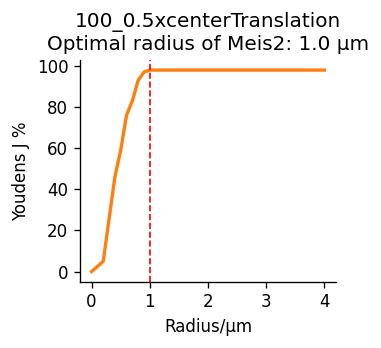

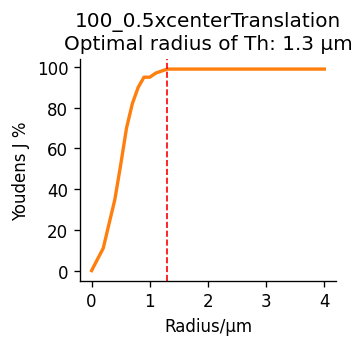

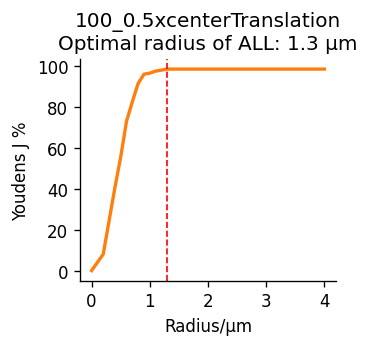

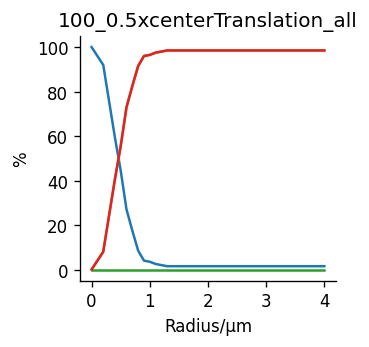

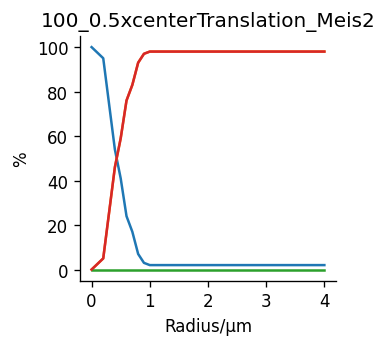

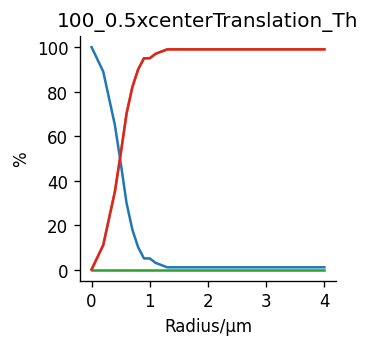

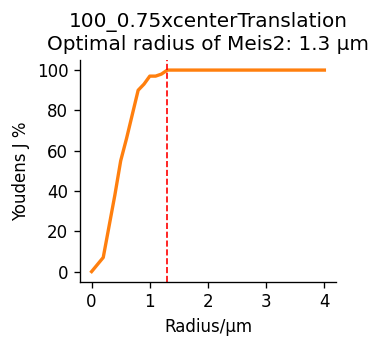

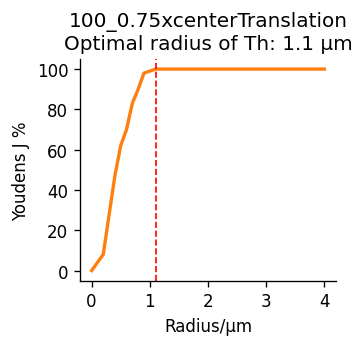

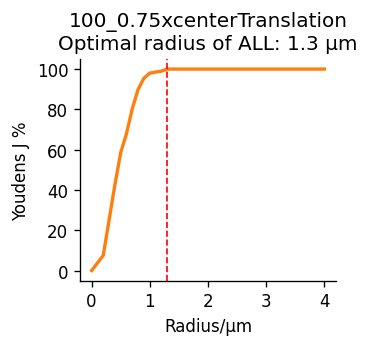

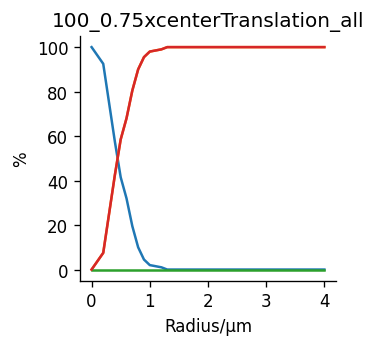

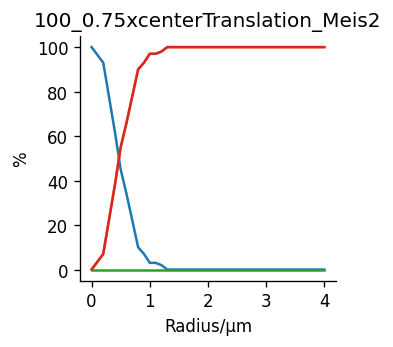

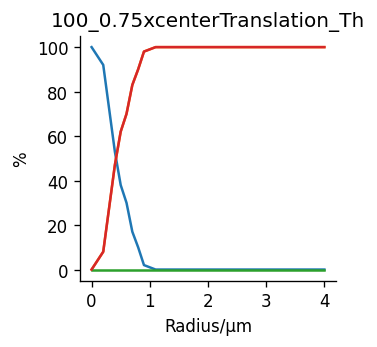

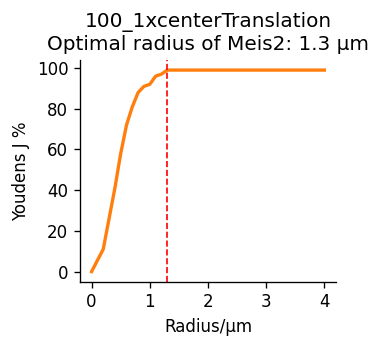

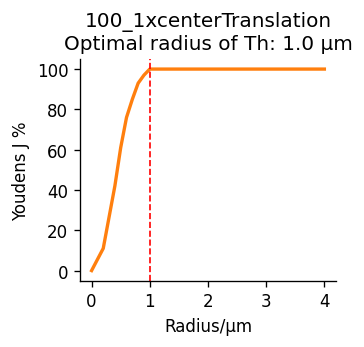

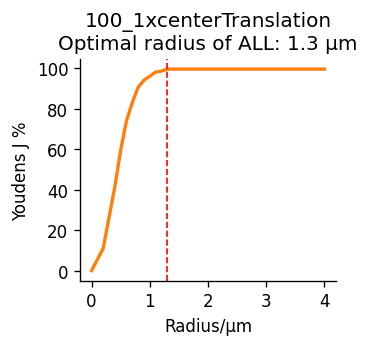

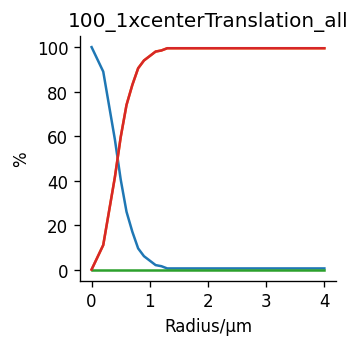

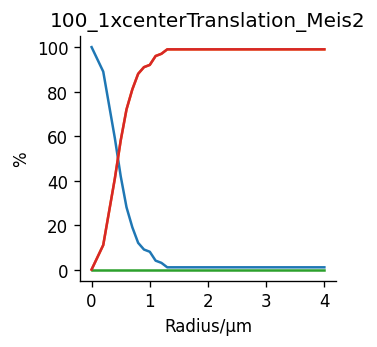

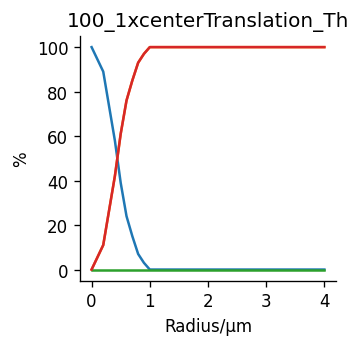

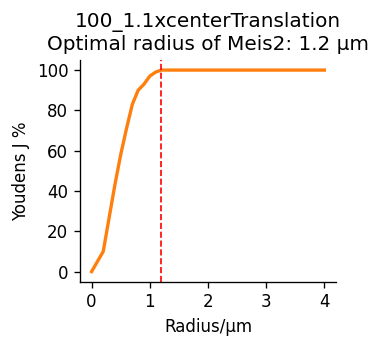

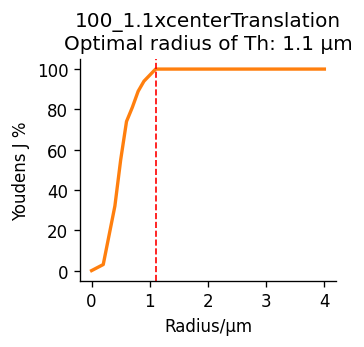

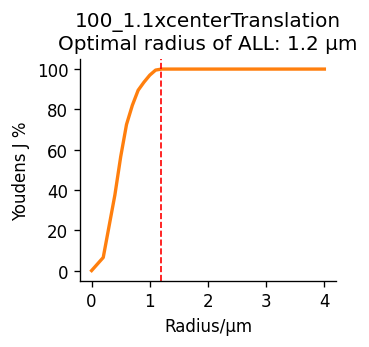

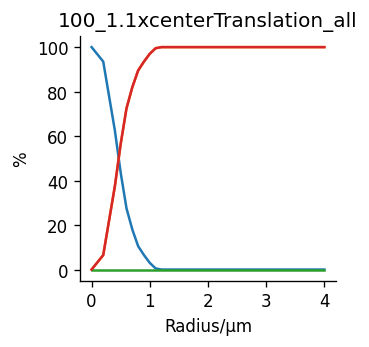

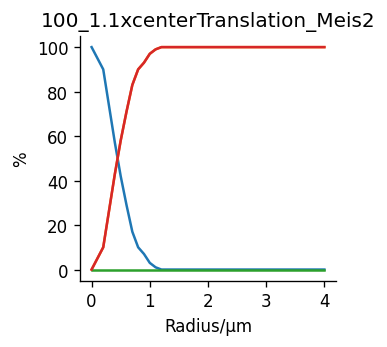

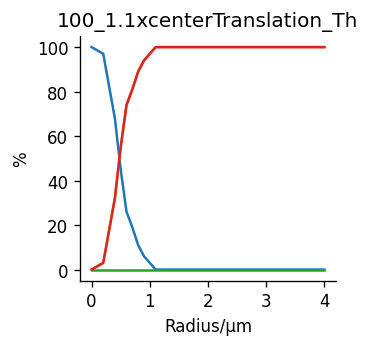

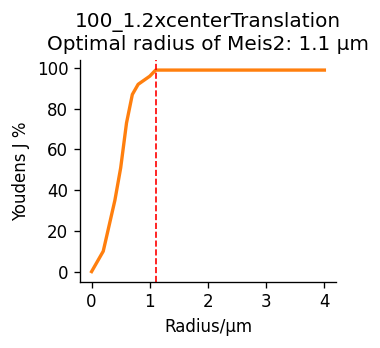

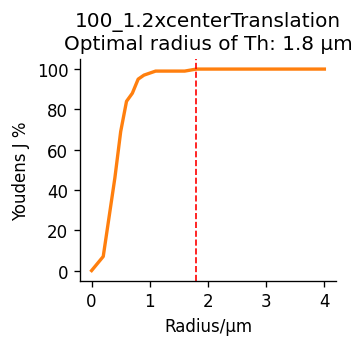

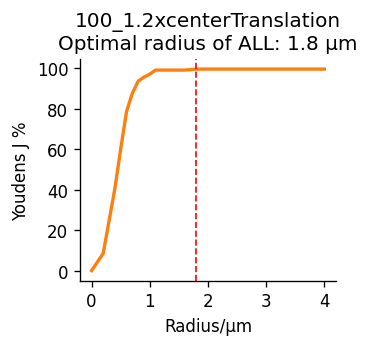

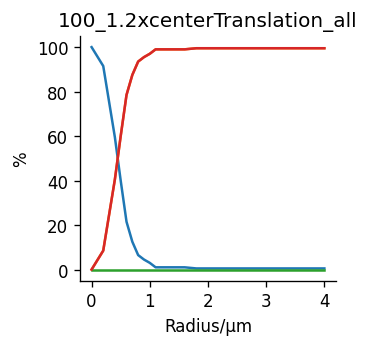

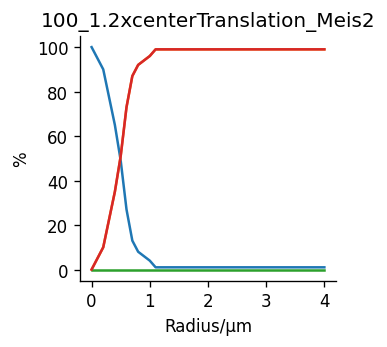

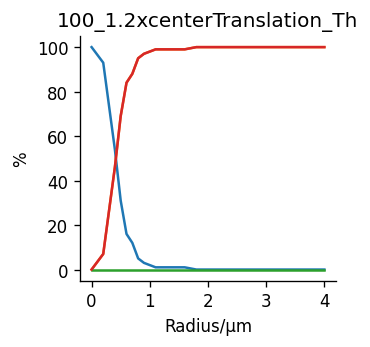

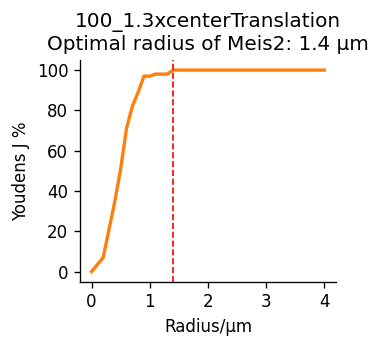

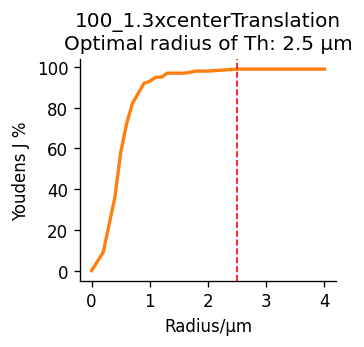

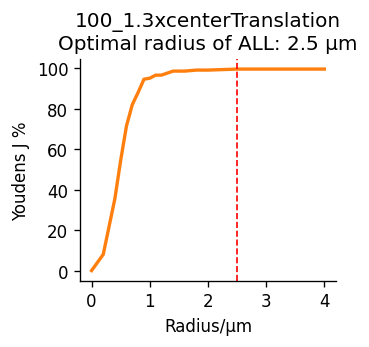

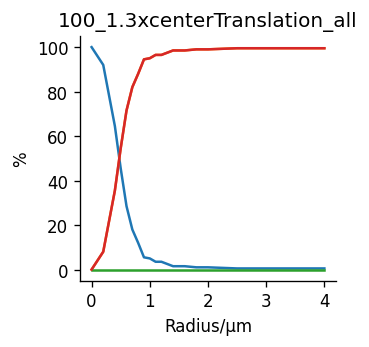

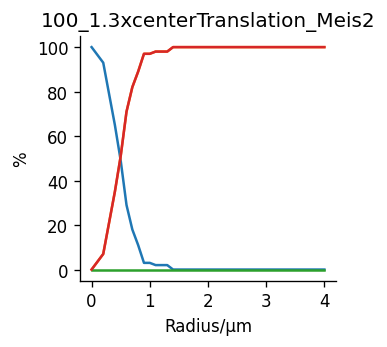

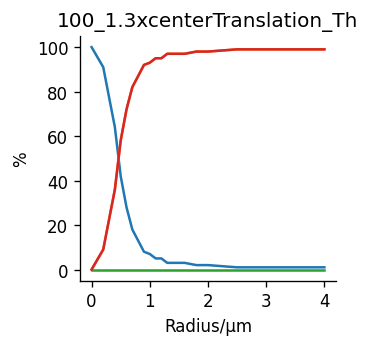

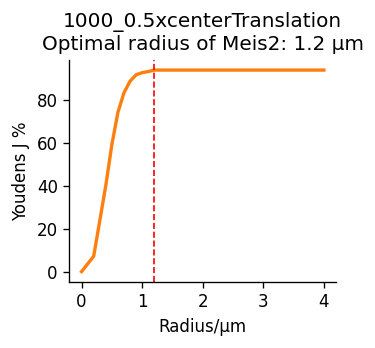

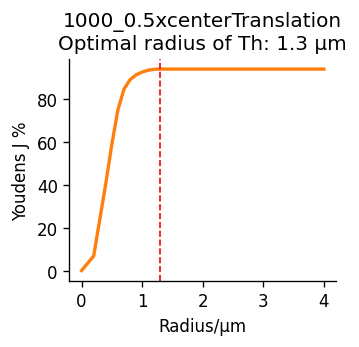

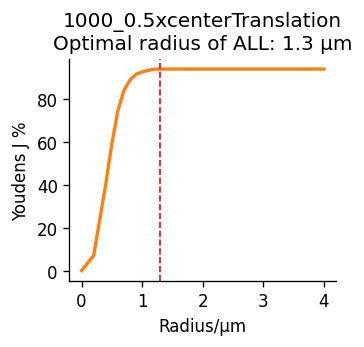

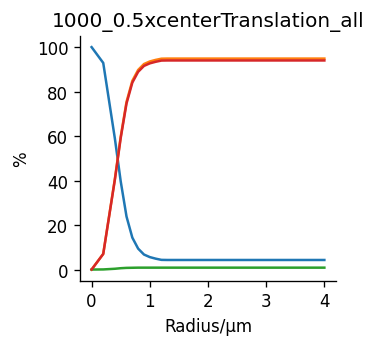

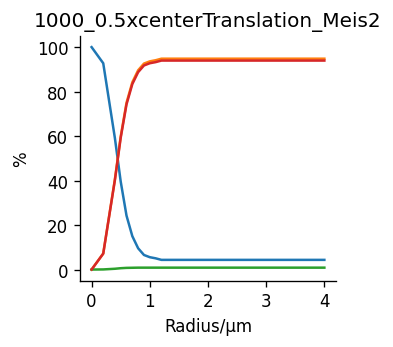

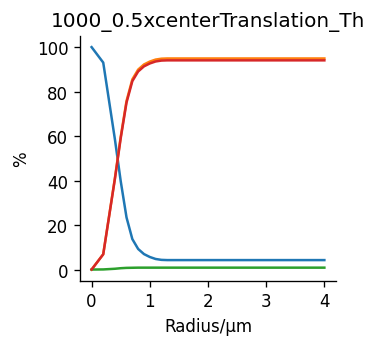

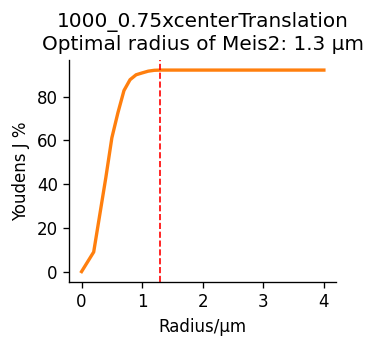

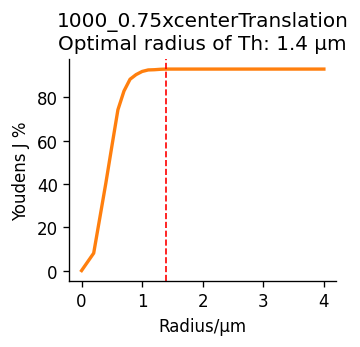

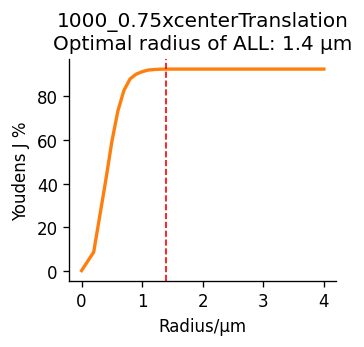

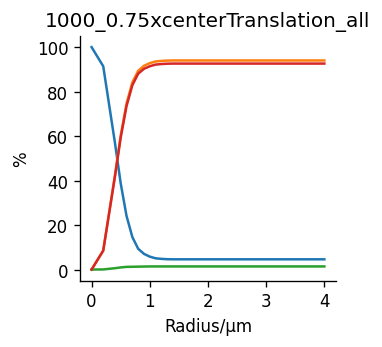

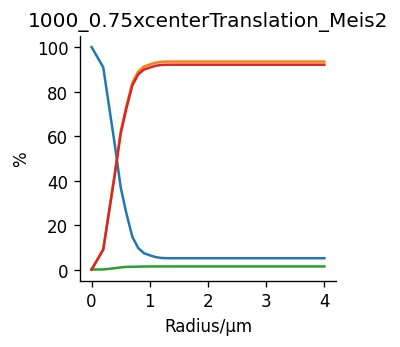

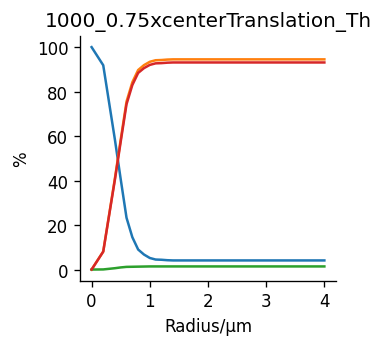

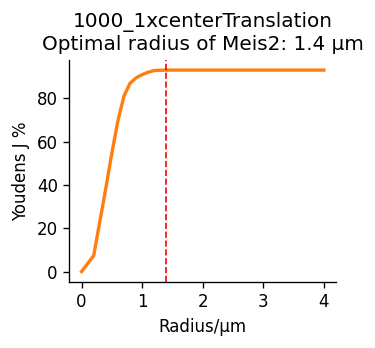

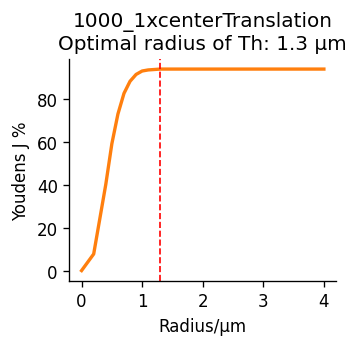

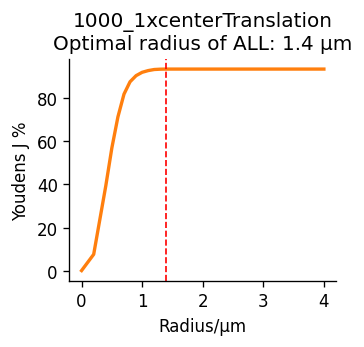

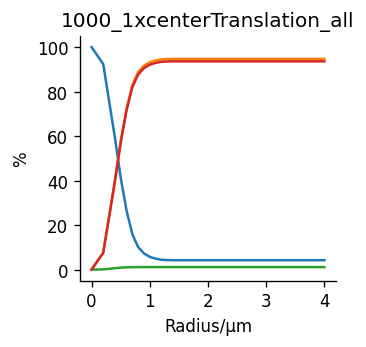

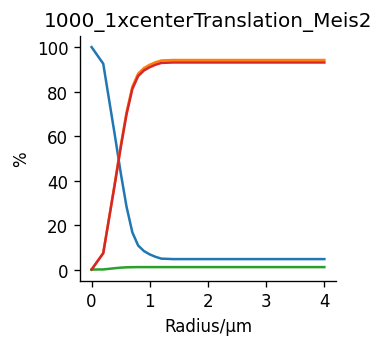

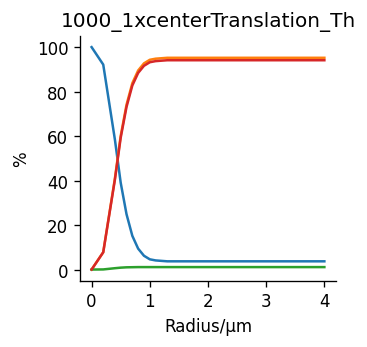

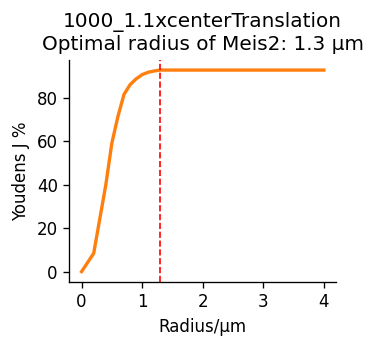

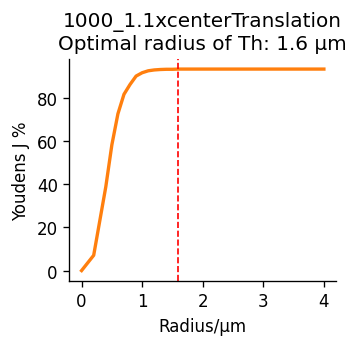

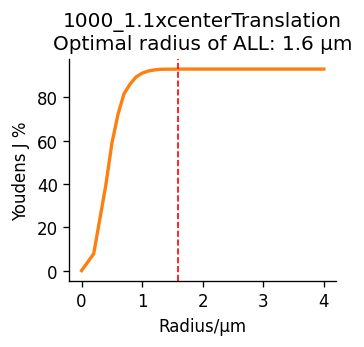

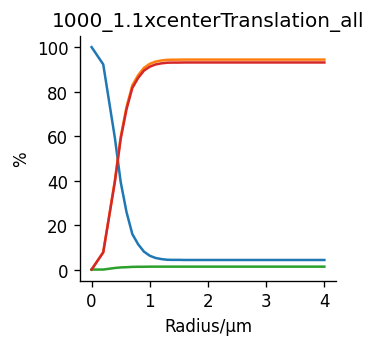

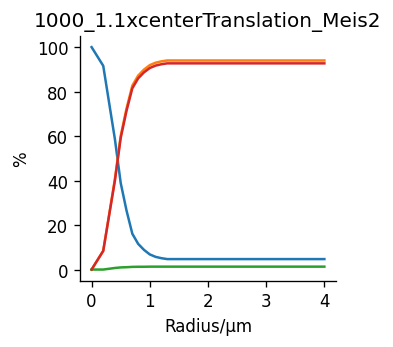

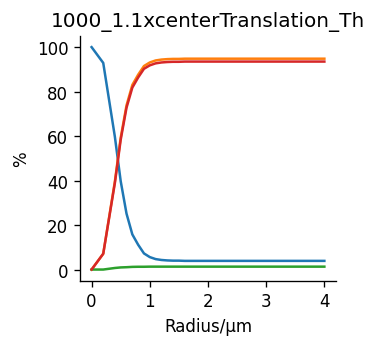

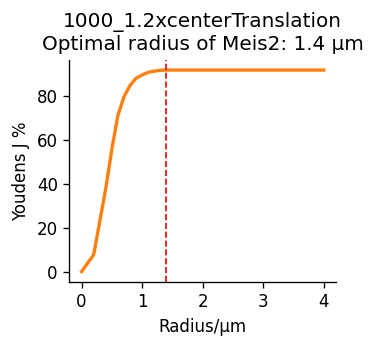

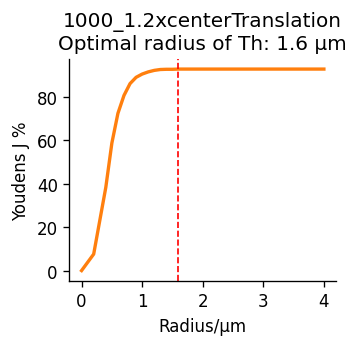

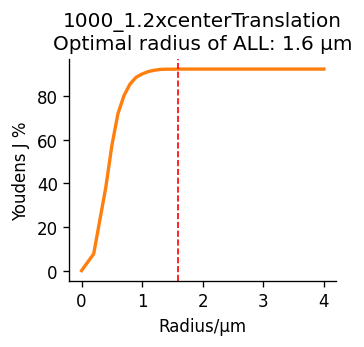

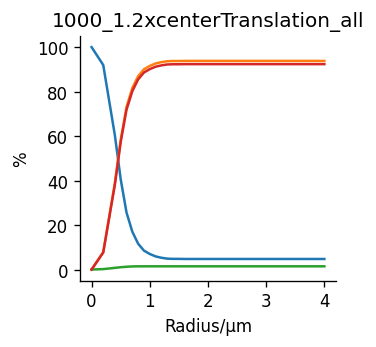

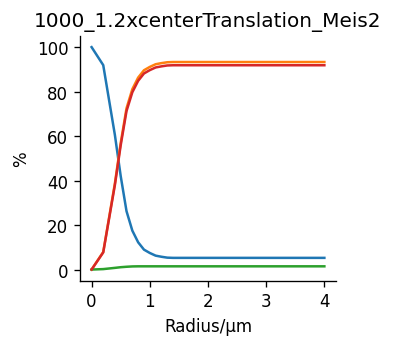

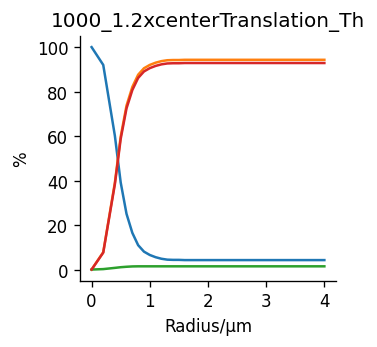

In [12]:
seg_dir='D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/' # Analyze the below images ## image is in zyx or

spotNum_list=[100,1000,4000,7000,10000]
#sigmabase_list=[0.1,0.2,0.3,0.4,0.5,0.6]
mu = [0,0,0]
#sigmascale_list=[0.5,0.75,1,1.5,2,3]
sigmascale=1
sigma_ref=np.around(sigma_ref,2)
tl_scale_list=[0.5,0.75,1,1.1,1.2]
rs_tl_ref=np.around(rs_tl_mean,2)
icp_tl_ref=np.around(icp_tl_mean,2)
print(f'center sigma:{sigma_ref}')
print(f'center ransac translation:{rs_tl_ref}')
print(f'center ransac translation:{icp_tl_ref}')
fix_spacing=np.array([0.42,0.23,0.23])
#sigmatimes=[fix_spacing[0]/fix_spacing[1],fix_spacing[1]/fix_spacing[1],fix_spacing[2]/fix_spacing[1]]

#mu_list=[0 0.2 0.4 0.6 0.8 1]
#dropout_list=[0 10 20 30 40 50]
#spotnumber_list=[]

spots_dir=seg_dir+'para_test/registration/'
segmentation1=imread(seg_dir + 'R2_filtered_mask.tif')
# # Registered and enlarged ROI
segmentation2=segmentation1
createVars=locals()
sigma=sigma_ref
#mu=mu_ref
summary_name=spots_dir+'summary.csv'         
with open(summary_name,'w') as sumf:
    csv_write = csv.writer(sumf)
    csv_head = ["tlscale","Radius","SpotPerGene","Pre-Distance","Pre-colocal%","ransac_Distance","ICP_Distance","Post_Collocal%","Num_c0","FP_c0%","Efficiency_c0%","FN_c0%","Num_c1","FP_c1%","Efficiency_c1%","FN_c1%", "Num_ALL","FP_ALL%","Efficiency_ALL%","FN_ALL%"]
    csv_write.writerow(csv_head)

############ generating simulated spots ################333
Chn = ["c0","c1","c3"]
#Count_c3c0 = np.zeros((4,len(group_list)))
kk = 0


for rep in spotNum_list:
    for tl in tl_scale_list:
        sigma=sigma_ref
        ### Initialization
        sigma=[sigma[0]*sigmascale,sigma[1]*sigmascale,sigma[2]*sigmascale] ##z-y-x order
        print(f'sigma:{sigma}')

        rs_tl=rs_tl_ref
        ### Initialization
        rs_tl=[rs_tl[0]*tl,rs_tl[1]*tl,rs_tl[2]*tl] ##z-y-x order
        print(f'rs translation:{rs_tl}')

        icp_tl=icp_tl_ref
        ### Initialization
        icp_tl=[icp_tl[0]*tl,icp_tl[1]*tl,icp_tl[2]*tl] ##z-y-x order
        print(f'icp translation:{icp_tl}')

        SpotNum = np.array([rep,rep])
        SpotRound = rep

        Dropout = int(0) # [0,1]
        percent=int(100)
        GeneNum = 2
        code=seg_dir + 'GeneCode.csv'
        ReadCode = pd.read_csv(code,sep=',',dtype=int,header=None,index_col=None)  #N genes x r round matrix
        GeneCode = np.array((ReadCode))
        GeneCode=GeneCode.astype('int')
        SpotAssign = 0 #0-Random, 1-Cyto-Nucleus ratio
        realsimulate = 0 #0- set threshold_distance, 1-get threshold_distance from data
        Round = int(2)
        #Generate simulated Gene info
        GeneDrop=SpotNum*Dropout
        GeneDrop=np.divide(GeneDrop,percent)
        GeneDrop=GeneDrop.astype('int')
        GeneTrue=SpotNum-GeneDrop
        
        filename=spots_dir+str(Round)+'round_'+str(GeneNum)+'gene_'+str(Dropout)+'_'+str(SpotRound)+'.txt'
        f=open('filename','w')

        GeneID=spots_simulated_code_assign(SpotNum,GeneNum,GeneCode,GeneTrue,GeneDrop)
        CellID=[8] #TODO:create many cell
        #Generate simulated fix spots
        for cid in CellID:
            ref_cellid= cid
            roi_dir = seg_dir + 'R2_' + str(ref_cellid) + '_C2.tif'      
            ref_ROI_c2 = imread(roi_dir)  #DAPI
            ref_spots = np.array([])

            #DropRoundGene=np.divide(GeneDrop,Round)
            DropRoundGene=GeneDrop.astype('int')

            if SpotAssign==0:
                simulate_fix_points,segmentation_aa,segmentation_nuc,segmentation_cyto,threshold_distance,setpoints,simulate_fix_points_full=spots_simulated(ref_ROI_c2,ref_spots,ref_cellid,SpotNum,GeneCode,GeneID,segmentation2,realsimulate,SpotAssign,GeneTrue)      
                dropout_threshold_distance=2*threshold_distance
                if Dropout >0:
                    current=0
                    simulate_fix_spots=dropout_assign(ref_cellid,Dropout,simulate_fix_points,current,GeneCode,segmentation2,segmentation_aa,segmentation_nuc,segmentation_cyto,dropout_threshold_distance,SpotAssign,realsimulate,ref_spots,DropRoundGene,setpoints)
                else:
                    simulate_fix_spots=simulate_fix_points
                createVars[str(rep)+'spot_fix_mix_all'+str(ref_cellid)]=simulate_fix_spots
                np.savetxt(spots_dir + str(rep)+'_'+str(tl)+'xcenterTranslation_'+'spot_fix_mix_all'+str(ref_cellid)+'.txt', locals()[str(rep)+'spot_fix_mix_all'+str(ref_cellid)], delimiter=',') 
                for n in [0,1,3]:
                    createVars[str(rep)+'spot_fix_c'+str(n)+'_all'+str(ref_cellid)]=separate_channel(simulate_fix_spots,n)
                    np.savetxt(spots_dir + str(rep)+'_'+str(tl)+'xcenterTranslation_'+'spot_fix_c'+str(n)+'_all'+str(ref_cellid)+'.txt', locals()[str(rep)+'spot_fix_c'+str(n)+'_all'+str(ref_cellid)], delimiter=',')
            
                #Generate moving round

                generate_rounds=Round-1
                for rr in range(generate_rounds):
                    current=rr+1
                    points_mov,setpoints=spots_shift(simulate_fix_points_full,mu,sigma,ref_cellid,segmentation2,segmentation_aa,GeneID,GeneCode,current,threshold_distance,rs_tl,icp_tl)
                    if Dropout >0:
                        spots_mov=dropout_assign(ref_cellid,Dropout,points_mov,current,GeneCode,segmentation2,segmentation_aa,segmentation_nuc,segmentation_cyto,dropout_threshold_distance,SpotAssign,realsimulate,ref_spots,DropRoundGene,setpoints)
                    else:
                        spots_mov=points_mov
                    createVars[str(rep)+'spot_mov'+str(current)+'_mix_all'+str(ref_cellid)]=spots_mov
                    np.savetxt(spots_dir +str(rep)+'_'+str(tl)+'xcenterTranslation_'+ 'spot_mov'+str(current)+'_mix_all'+str(ref_cellid)+'.txt', locals()[str(rep)+'spot_mov'+str(current)+'_mix_all'+str(ref_cellid)], delimiter=',') 
                    #exec(f'simulate_mov_points_{current}= spots_shift(simulate_fix_spots,mu,sigma,segmentation_aa,GeneID,GeneCode,current)')
                    for n in [0,1,3]:
                        createVars[str(rep)+'spot_mov'+str(current)+'_c'+str(n)+'_all'+str(ref_cellid)]=separate_channel(spots_mov,n)
                        np.savetxt(spots_dir + str(rep)+'_'+str(tl)+'xcenterTranslation_'+'spot_mov'+str(current)+'_c'+str(n)+'_all'+str(ref_cellid)+'.txt', locals()[str(rep)+'spot_mov'+str(current)+'_c'+str(n)+'_all'+str(ref_cellid)], delimiter=',')

        ################3#Load Spots############################33
        # seg_dir='D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/' # Analyze the below images ## image is in zyx or
        # spots_dir=seg_dir+'para_test/'
        channel=['mix','c0','c1','c3']
        CellID=[8]
        round=2
        cyto_nu=0 #1-cyto_nucleus ratio
        createVars=locals()
        if cyto_nu==0:
            loca=['all']
        else:
            loca=['all','cyto','nuc']

        for location in loca:
            for chn in channel:
                for ref_cellid in CellID:
                    spotname=spots_dir +str(rep)+'_'+str(tl)+'xcenterTranslation_'+'spot_fix_'+chn+'_'+location+str(ref_cellid)+'.txt'
                    createVars[str(rep)+'spot_fix_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',') 
        for location in loca:
            for chn in channel:
                for ref_cellid in CellID:
                    movround=round-1
                    for jj in range(movround):
                        movlabel=jj+1
                        spotname=spots_dir +str(rep)+'_'+str(tl)+'xcenterTranslation_'+'spot_mov'+str(movlabel)+'_'+chn+'_'+location+str(ref_cellid)+'.txt'
                        createVars[str(rep)+'spot_mov'+str(movlabel)+'_'+chn+'_'+location+str(ref_cellid)]=np.loadtxt(spotname, delimiter=',') 

        #############  Group registration #################
        # %%time  
        # seg_dir='D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/' # Analyze the below images ## image is in zyx or
        # spots_dir=seg_dir+'simulated_spots/'
        segmentation1=imread(seg_dir + 'R2_filtered_mask.tif')
        # # Registered and enlarged ROI
        segmentation2=segmentation1
        createVars=locals()
        ########## Main Code for generating simulated spots #########

        ### Initialization
        SpotNum = [100,100]
        GeneNum = 2
        code=seg_dir + 'GeneCode.csv'
        ReadCode = pd.read_csv(code,sep=',',dtype=int,header=None,index_col=None)  #N genes x r round matrix
        GeneCode = np.array((ReadCode))

        spot_fix_c3_all1 = np.zeros((1, 4))
        warp_spots_c3_all1 = np.zeros((1, 4))
        spot_fix_c1_all1 = np.zeros((1, 4))
        warp_spots_c1_all1 = np.zeros((1, 4))
        spot_fix_c0_all1 = np.zeros((1, 4))
        warp_spots_c0_all1 = np.zeros((1, 4))

        spot_fix_c3_cyto1 = np.zeros((1, 4))
        warp_spots_c3_cyto1 = np.zeros((1, 4))
        spot_fix_c1_cyto1 = np.zeros((1, 4))
        warp_spots_c1_cyto1 = np.zeros((1, 4))
        spot_fix_c0_cyto1 = np.zeros((1, 4))
        warp_spots_c0_cyto1 = np.zeros((1, 4))

        spot_fix_c3_nuc1 = np.zeros((1, 4))
        warp_spots_c3_nuc1 = np.zeros((1, 4))
        spot_fix_c1_nuc1 = np.zeros((1, 4))
        warp_spots_c1_nuc1 = np.zeros((1, 4))
        spot_fix_c0_nuc1 = np.zeros((1, 4))
        warp_spots_c0_nuc1 = np.zeros((1, 4))

        fix_spacing=np.array([0.42,0.23,0.23])
        j=0
        Shuffle_spots = 0
        ROI_id=[8]
        # ROI_id = np.unique(segmentation1[segmentation1!=0])
        Dist_sum_1= np.zeros((len(ROI_id), 6)) # directory to file containing the registration stats
        neighbor_radius0 = 6 #6 um
            
        for aa in ROI_id:
        #   aa = 43
            ROI_moving = aa
            print('ROI_fix: ' + str(aa) + '; ROI_moving: ' + str(ROI_moving))
            Global_detection = 1
            ransac_affine = 1 ## 1 is to apply local ransac affine (not use image) before ICP,0 is used orginal point cloud for ICP.
            image_ransac = 0 # > 0 is to get point correspondences from image after using nearest neighbors ; or 0 is to use nearest neighbors for local ransac
            hAir = 0 # 0 is RS-FISH; 1 is for hAirlocalize
            ROI_moving = aa
            roi_dir = seg_dir + 'R2_' + str(aa) + '_c2.tif' 
            fixed_ROI_c2 = imread(roi_dir)

                # read all images
            # Chn = "c0"
            # roi_dir = fix_path + '/s2' + '/R2_' + str(aa) + '_'+ Chn + '.tif'
            # fixed_ROI_c0 = imread(roi_dir)
            # roi_dir = fix_path + '/s2' + '/R10_' + str(aa) + '_'+ Chn + '.tif'
            # moving_ROI_c0 = imread(roi_dir)
            
            # Chn = "c1"
            # roi_dir = fix_path + '/s2' + '/R2_' + str(aa) + '_'+ Chn + '.tif'
            # fixed_ROI_c1 = imread(roi_dir)
            # roi_dir = fix_path + '/s2' + '/R10_' + str(aa) + '_'+ Chn + '.tif'
            # moving_ROI_c1 = imread(roi_dir)
            
        #             spotdir = seg_dir + 'R2ROI_points_fix.txt'
        #             Rounds = ["R2","R10"]
        #             global_affine_fix,inv_affine_fix,Transform_fix,global_affine_mov,inv_affine_mov,Transform_mov,affine_borrow_idx = cca(
        #                 seg_dir,spotdir,aa,Rounds)
            image_ransac = 1 # number is specific distance threshold 
            # save rgb images
            Chn = ["C0","C1","C3"]
            if Chn == ["C0","C1","C3"]:

                P1_preC3,P2_preC3,P1_C3,P2_C3,pre_dist_013,mid_dist_013,pair_dist_013,fix_spots_013,mov_spots_013,warp_spots_new_013,cc_3,fix_spots_cyto013,fix_spots_nuc013,warp_spots_new_cyto013,warp_spots_new_nuc013 = Simulated_ROI_trackaffine_cca_grouping_fpfh_bash(
                seg_dir,segmentation1,segmentation2,aa,ROI_moving,fixed_ROI_c2,Chn,Global_detection,image_ransac,hAir,neighbor_radius0,
                Shuffle_spots,rep)
                distances_1 = np.mean(pre_dist_013)
                distances_2 = np.mean(mid_dist_013)
                distances_3 = np.mean(pair_dist_013)
                P1P2_pre=(P1_preC3+P2_preC3)/2
                P1P2_post=(P1_C3+P2_C3)/2


        #             spotdir = seg_dir + 'R2ROI_points_fix.txt'
        #             Rounds = ["R2","R10"]
        #             global_affine_fix,inv_affine_fix,Transform_fix,global_affine_mov,inv_affine_mov,Transform_mov,affine_borrow_idx = cca(
        #                 seg_dir,spotdir,aa,Rounds)
            image_ransac = 1 # number is specific distance threshold 
            # save rgb images

            # Chn = ["C0","C1","C3"]
            # if Chn == ["C0","C1","C3"]:

            #     P1_C3,P2_C3,pre_dist_013,mid_dist_013,pair_dist_013,fix_spots_013,mov_spots_013,warp_spots_new_013,cc_3,fix_spots_cyto013,fix_spots_nuc013,warp_spots_new_cyto013,warp_spots_new_nuc013 = ROI_trackaffine_cca_grouping_fpfh_bash(
            #     seg_dir,segmentation1,segmentation2,aa,ROI_moving,fixed_ROI_c2,Chn,Global_detection,image_ransac,hAir,neighbor_radius0,
            #     Shuffle_spots,fixed_ROI_c0,moving_ROI_c0,fixed_ROI_c1,moving_ROI_c1)
            #     distances_1 = np.mean(pre_dist_013)
            #     distances_2 = np.mean(mid_dist_013)
            #     distances_3 = np.mean(pair_dist_013)

            # # save ALL spots, global affine, warp affine.  
            cc_0 = cc_1 = cc_3
            
            fix_spots_0 = fix_spots_013[fix_spots_013[:,3] == 0]
            fix_spots_1 = fix_spots_013[fix_spots_013[:,3] == 1]
        #             fix_spots_3 = fix_spots_013[fix_spots_013[:,3] == 2]
            warp_spots_new_0 = warp_spots_new_013[warp_spots_new_013[:,3] == 0]
            warp_spots_new_1 = warp_spots_new_013[warp_spots_new_013[:,3] == 1]
        #             warp_spots_new_3 = warp_spots_new_013[warp_spots_new_013[:,3] == 2]

            # save C3 spots, global affine, warp affine.
        #             spot_fix3 = fix_spots_3[:,:3] /fix_spacing + [2*cc_3[0],4*cc_3[1],4*cc_3[2]]  # pre:in um, post: in px[um to px + mask(0, in px)]
        #             spot_fix_c3 = np.column_stack((spot_fix3,np.ones(len(spot_fix3)).dot(aa))) # add ROI_ID
        #             spot_fix_c3_all1 = np.row_stack((spot_fix_c3_all1,spot_fix_c3))   # for all ROIs
        #             warp_spots_3 = warp_spots_new_3[:,:3]/fix_spacing + [2*cc_3[0],4*cc_3[1],4*cc_3[2]]  # in pixels of S2
        #             warp_spots_new_c3 = np.column_stack((warp_spots_3,np.ones(len(warp_spots_new_3)).dot(aa)))
        #             warp_spots_c3_all1 = np.row_stack((warp_spots_c3_all1,warp_spots_new_c3))

            # save C1 spots, global affine, warp affine.
            spot_fix1 = fix_spots_1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in phsical distance of S2
            spot_fix_c1 = np.column_stack((spot_fix1,np.ones(len(spot_fix1)).dot(aa)))
            spot_fix_c1_all1 = np.row_stack((spot_fix_c1_all1,spot_fix_c1))
            warp_spots_1 = warp_spots_new_1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in pixels of S2
            warp_spots_new_c1 = np.column_stack((warp_spots_1,np.ones(len(warp_spots_new_1)).dot(aa)))
            warp_spots_c1_all1 = np.row_stack((warp_spots_c1_all1,warp_spots_new_c1))
            
            # save C0 spots, global affine, warp affine.
            spot_fix0 = fix_spots_0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in phsical distance of S2
            spot_fix_c0 = np.column_stack((spot_fix0,np.ones(len(spot_fix0)).dot(aa)))
            spot_fix_c0_all1 = np.row_stack((spot_fix_c0_all1,spot_fix_c0))
            warp_spots_0 = warp_spots_new_0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in pixels of S2
            warp_spots_new_c0 = np.column_stack((warp_spots_0,np.ones(len(warp_spots_new_0)).dot(aa)))
            warp_spots_c0_all1 = np.row_stack((warp_spots_c0_all1,warp_spots_new_c0))
            
            ###########  save cyto C1 spots, global affine, warp affine.
            fix_spots_cyto0 = fix_spots_cyto013[fix_spots_cyto013[:,3] == 0]
            fix_spots_cyto1 = fix_spots_cyto013[fix_spots_cyto013[:,3] == 1]
            #             fix_spots_cyto3 = fix_spots_cyto013[fix_spots_cyto013[:,3] == 2]
            warp_spots_new_cyto0 = warp_spots_new_cyto013[warp_spots_new_cyto013[:,3] == 0]
            warp_spots_new_cyto1 = warp_spots_new_cyto013[warp_spots_new_cyto013[:,3] == 1]
            #             warp_spots_new_cyto3 = warp_spots_new_cyto013[warp_spots_new_cyto013[:,3] == 2]

            spot_fix1 = fix_spots_cyto1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in phsical distance of S2
            spot_fix_c1 = np.column_stack((spot_fix1,np.ones(len(spot_fix1)).dot(aa)))
            spot_fix_c1_cyto1 = np.row_stack((spot_fix_c1_cyto1,spot_fix_c1))
            if warp_spots_new_1.shape[0] == 0:
                warp_spots_c1_cyto1 = warp_spots_c1_cyto1
            else:
                warp_spots_1 = warp_spots_new_cyto1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in pixels of S2
                warp_spots_new_c1 = np.column_stack((warp_spots_1,np.ones(len(warp_spots_new_cyto1)).dot(aa)))
                warp_spots_c1_cyto1 = np.row_stack((warp_spots_c1_cyto1,warp_spots_new_c1))

            # save cyto C0 spots, global affine, warp affine.
            spot_fix0 = fix_spots_cyto0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in phsical distance of S2
            spot_fix_c0 = np.column_stack((spot_fix0,np.ones(len(spot_fix0)).dot(aa)))
            spot_fix_c0_cyto1 = np.row_stack((spot_fix_c0_cyto1,spot_fix_c0))
            warp_spots_0 = warp_spots_new_cyto0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in pixels of S2
            warp_spots_new_c0 = np.column_stack((warp_spots_0,np.ones(len(warp_spots_new_cyto0)).dot(aa)))
            warp_spots_c0_cyto1 = np.row_stack((warp_spots_c0_cyto1,warp_spots_new_c0))            

            ###########  save nuc C1 spots, global affine, warp affine.
            fix_spots_nuc0 = fix_spots_nuc013[fix_spots_nuc013[:,3] == 0]
            fix_spots_nuc1 = fix_spots_nuc013[fix_spots_nuc013[:,3] == 1]
            #             fix_spots_nuc3 = fix_spots_nuc013[fix_spots_nuc013[:,3] == 2]
            warp_spots_new_nuc0 = warp_spots_new_nuc013[warp_spots_new_nuc013[:,3] == 0]
            warp_spots_new_nuc1 = warp_spots_new_nuc013[warp_spots_new_nuc013[:,3] == 1]
            #             warp_spots_new_nuc3 = warp_spots_new_nuc013[warp_spots_new_nuc013[:,3] == 2]


            spot_fix1 = fix_spots_nuc1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in phsical distance of S2
            spot_fix_c1 = np.column_stack((spot_fix1,np.ones(len(spot_fix1)).dot(aa)))
            spot_fix_c1_nuc1 = np.row_stack((spot_fix_c1_nuc1,spot_fix_c1))
            if warp_spots_new_1.shape[0] == 0:
                warp_spots_c1_nuc1 = warp_spots_c1_nuc1
            else:
                warp_spots_1 = warp_spots_new_nuc1[:,:3]/fix_spacing + [2*cc_1[0],4*cc_1[1],4*cc_1[2]]  # in pixels of S2
                warp_spots_new_c1 = np.column_stack((warp_spots_1,np.ones(len(warp_spots_new_nuc1)).dot(aa)))
                warp_spots_c1_nuc1 = np.row_stack((warp_spots_c1_nuc1,warp_spots_new_c1))

            # save nuc C0 spots, global affine, warp affine.
            spot_fix0 = fix_spots_nuc0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in phsical distance of S2
            spot_fix_c0 = np.column_stack((spot_fix0,np.ones(len(spot_fix0)).dot(aa)))
            spot_fix_c0_nuc1 = np.row_stack((spot_fix_c0_nuc1,spot_fix_c0))
            warp_spots_0 = warp_spots_new_nuc0[:,:3]/fix_spacing + [2*cc_0[0],4*cc_0[1],4*cc_0[2]]  # in pixels of S2
            warp_spots_new_c0 = np.column_stack((warp_spots_0,np.ones(len(warp_spots_new_nuc0)).dot(aa)))
            warp_spots_c0_nuc1 = np.row_stack((warp_spots_c0_nuc1,warp_spots_new_c0))            


            # affine_borrow[j,:] = affine_borrow_idx
            # remember to remove the first 000 coordinates
            Dist_sum_1[j,:] = [aa,distances_1,distances_2,distances_3,P1_C3,P2_C3]
            j = j + 1

        ############### Save registration output ##############333

        Dist_sum_pre = pd.DataFrame(Dist_sum_1[:,1:6], columns = ['roi_fix','roi_mov','all_dist','all_p1','all_p2'])

        # spot_extraction = ['hAir/','RS-FISH/grouping_shuffle_location/'][1]
        #spot_extraction = ['hAir/','RS-FISH/cca_grouping_shuffle_location/'][1]
        # spot_extraction = ['hAir/','RS-FISH/cca_grouping_location/'][1]
        # seg_dir='D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/' # Analyze the below images ## image is in zyx or
        # spots_dir=seg_dir+'para_test/'
        Dist_sum_pre.to_csv(spots_dir + str(rep)+'_'+str(tl)+'xcenterTranslation_''R2R10_colocalization_RS-FISH_affine_cca_fpfh_bigstream.csv', index=False)

        spot_fix_c1_all1 = spot_fix_c1_all1[spot_fix_c1_all1[:,3]!= 2,:]
        np.savetxt(spots_dir +str(rep)+'_'+str(tl)+'xcenterTranslation_'+ 'ROIaffine_R2_c1_spots.txt',spot_fix_c1_all1,delimiter=',') 
        spot_fix_c0_all1 = spot_fix_c0_all1[spot_fix_c0_all1[:,3]!= 2,:]
        np.savetxt(spots_dir + str(rep)+'_'+str(tl)+'xcenterTranslation_'+'ROIaffine_R2_c0_spots.txt',spot_fix_c0_all1,delimiter=',')

        warp_spots_c1_all1 = warp_spots_c1_all1[warp_spots_c1_all1[:,3]!= 2,:]
        np.savetxt(spots_dir +  str(rep)+'_'+str(tl)+'xcenterTranslation_'+'ROIaffine_R10_c1_spots.txt',warp_spots_c1_all1,delimiter=',')
        warp_spots_c0_all1 = warp_spots_c0_all1[warp_spots_c0_all1[:,3]!= 2,:]
        np.savetxt(spots_dir + str(rep)+'_'+str(tl)+'xcenterTranslation_'+'ROIaffine_R10_c0_spots.txt',warp_spots_c0_all1,delimiter=',')

        spot_fix_c1_cyto1 = spot_fix_c1_cyto1[spot_fix_c1_cyto1[:,3]!= 2,:]
        np.savetxt(spots_dir + str(rep)+'_'+str(tl)+'xcenterTranslation_'+'ROIaffine_R2_c1_cytospots.txt',spot_fix_c1_cyto1,delimiter=',') 
        spot_fix_c0_cyto1 = spot_fix_c0_cyto1[spot_fix_c0_cyto1[:,3]!= 2,:]
        np.savetxt(spots_dir+  str(rep)+'_'+str(tl)+'xcenterTranslation_'+'ROIaffine_R2_c0_cytospots.txt',spot_fix_c0_cyto1,delimiter=',')

        warp_spots_c1_cyto1 = warp_spots_c1_cyto1[warp_spots_c1_cyto1[:,3]!= 2,:]
        np.savetxt(spots_dir+str(rep)+'_'+str(tl)+'xcenterTranslation_'+ 'ROIaffine_R10_c1_cytospots.txt',warp_spots_c1_cyto1,delimiter=',')
        warp_spots_c0_cyto1 = warp_spots_c0_cyto1[warp_spots_c0_cyto1[:,3]!= 2,:]
        np.savetxt(spots_dir + str(rep)+'_'+str(tl)+'xcenterTranslation_'+'ROIaffine_R10_c0_cytospots.txt',warp_spots_c0_cyto1,delimiter=',')

        spot_fix_c1_nuc1 = spot_fix_c1_nuc1[spot_fix_c1_nuc1[:,3]!= 2,:]
        np.savetxt(spots_dir+ str(rep)+'_'+str(tl)+'xcenterTranslation_'+'ROIaffine_R2_c1_nucspots.txt',spot_fix_c1_nuc1,delimiter=',') 
        spot_fix_c0_nuc1 = spot_fix_c0_nuc1[spot_fix_c0_nuc1[:,3]!= 2,:]
        np.savetxt(spots_dir +str(rep)+'_'+str(tl)+'xcenterTranslation_'+ 'ROIaffine_R2_c0_nucspots.txt',spot_fix_c0_nuc1,delimiter=',')

        warp_spots_c1_nuc1 = warp_spots_c1_nuc1[warp_spots_c1_nuc1[:,3]!= 2,:]
        np.savetxt(spots_dir +str(rep)+'_'+str(tl)+'xcenterTranslation_'+ 'ROIaffine_R10_c1_nucspots.txt',warp_spots_c1_nuc1,delimiter=',')
        warp_spots_c0_nuc1 = warp_spots_c0_nuc1[warp_spots_c0_nuc1[:,3]!= 2,:]
        np.savetxt(spots_dir +str(rep)+'_'+str(tl)+'xcenterTranslation_'+'ROIaffine_R10_c0_nucspots.txt',warp_spots_c0_nuc1,delimiter=',')


        ############### Decoding ###########
        #%%time
        fix_spacing=np.array([0.42,0.23,0.23])
        spot_extraction = ['hAir/','RS-FISH/grouping_location/'][1] # image_seperate_fish
        # spot_extraction = ['hAir/','RS-FISH/grouping_shuffle/'][1] # image_seperate_fish
        # spot_extraction = ['hAir/','RS-FISH/grouping_shuffle_location/'][1]
        # spot_extraction = ['hAir/','RS-FISH/cca_grouping_location/'][1]
        # spot_extraction = ['hAir/','RS-FISH/cca_grouping_shuffle_location/'][1]
        Rounds = ['R2','R10']
        chn = ['c0','c1']
        Gene = ['Meis2','Th']
        # seg_dir='D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/' # Analyze the below images ## image is in zyx or
        # spots_dir=seg_dir+'para_test/'
        ##
        spot_fix_c3_all = np.loadtxt (spots_dir +str(rep)+'_'+str(tl)+'xcenterTranslation_'+ 'ROIaffine_'+ Rounds[0] + '_' + chn[0] + '_spots.txt',delimiter=',')
        spot_fix_c0_all = np.loadtxt (spots_dir+str(rep)+'_'+str(tl)+'xcenterTranslation_'+  'ROIaffine_'+ Rounds[0] + '_' + chn[1] + '_spots.txt',delimiter=',')
        warp_spots_c3_all = np.loadtxt (spots_dir +str(rep)+'_'+str(tl)+'xcenterTranslation_'+ 'ROIaffine_'+ Rounds[1] + '_' + chn[0] + '_spots.txt',delimiter=',')
        warp_spots_c0_all = np.loadtxt (spots_dir + str(rep)+'_'+str(tl)+'xcenterTranslation_'+ 'ROIaffine_'+ Rounds[1] + '_' + chn[1] + '_spots.txt',delimiter=',')
        cell_list=[8]
        Decoding_results = np.zeros((len(cell_list), 14))

        radius_list = [0,0.2,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.8,2,2.5,3,3.5,4]
        Decoding_Efficiency = np.zeros((len(radius_list), 13))
        Decoding_YoudenJ_c0 = np.zeros((len(cell_list), len(radius_list)))
        Decoding_YoudenJ_c1 = np.zeros((len(cell_list), len(radius_list)))
        Decoding_YoudenJ_ALL = np.zeros((len(cell_list), len(radius_list)))   
        Count_c0 = np.zeros((len(cell_list), len(radius_list))) 
        Count_c1 = np.zeros((len(cell_list), len(radius_list))) 

        k=0
        for radius in radius_list:
            j = 0
            for aa in cell_list:
                print('ROI: #' + str(aa))
                fix_c3 = spot_fix_c3_all[spot_fix_c3_all[:,3] == aa][:,:3]*fix_spacing
                fix_c0 = spot_fix_c0_all[spot_fix_c0_all[:,3] == aa][:,:3]*fix_spacing
                warp_c3 = warp_spots_c3_all[warp_spots_c3_all[:,3]== aa][:,:3]*fix_spacing
                warp_c0 = warp_spots_c0_all[warp_spots_c0_all[:,3]== aa][:,:3]*fix_spacing
                
                all_n = len(fix_c3) + len(fix_c0) + len(warp_c3)+ len(warp_c0)
                print(Gene[0] + " Total spots: " + str(len(fix_c3) + len(warp_c3)))
                print(Gene[1] + " Total spots: " + str(len(fix_c0) + len(warp_c0)))
                Num_c0 = len(fix_c3) + len(warp_c3)
                Num_c1 = len(fix_c0) + len(warp_c0)
                Num_All = all_n
            
                # group decoding
                lipo_c0,lipo_c1,true_pos_c0,true_pos_c1,_,p1,p2, = colocalization_grouping(fix_c3,fix_c0,warp_c3,warp_c0,radius) #R2_c0c1;R10_c0c1

                ################# 1.1 False positive when grouping
                #  R2c0 align with R10c1: when lipo_c0[:,3] = 0 and lipo_c1[:,3] = 1
                A = np.where(lipo_c0[:,3] == 1)[0].flatten().tolist()
                B = np.where(lipo_c1[:,3] == 0)[0].flatten().tolist()
                AB = list(np.array(set(A).intersection(set(B))).tolist()) 
                e1 = len(AB)
                #  R10c0 align with R2c1: when lipo_c1[:,3] = 0 and lipo_c2[:,3] = 1
                A = np.where(lipo_c1[:,3] == 1)[0].flatten().tolist()
                B = np.where(lipo_c0[:,3] == 0)[0].flatten().tolist()
                AB = list(np.array(set(A).intersection(set(B))).tolist())
                e2 = len(AB)

                ratio1 = 0
                ratio2 = 0
                if len(fix_c3) != 0:
                    ratio1 = 100*(e1)/(2*len(fix_c3))
                if len(warp_c3) != 0:
                    ratio2 =  100*(e2)/(2*len(warp_c3))
                FP_c0 = ratio1 + ratio2
                print("% False positive of " + Gene[0] + ": " + str(FP_c0))

                ratio1 = 0
                ratio2 = 0
                if len(warp_c0) != 0:
                    ratio1 = 100*(e1)/(2*len(warp_c0))
                if len(fix_c0) != 0:
                    ratio2 =  100*(e2)/(2*len(fix_c0))
                FP_c1 = ratio1 + ratio2
                print("% False positive of " + Gene[1] + ": " + str(FP_c1))

                FP_All = 100*2*(e1+e2)/all_n
                print("% False positive for all genes: " + str(FP_All))

                ################# 1.2 True positive when separated
                # R2c0 align with R10c0: when lipo_c0[:,3] = 0 and lipo_c1[:,3] = 0
                A = np.where(lipo_c0[:,3] == 0)[0].flatten().tolist()
                B = np.where(lipo_c1[:,3] == 0)[0].flatten().tolist()
                AB = list(np.array(set(A).intersection(set(B))).tolist()) 
                aaa = len(AB)*2

                # R2c1 align with R10c1: when lipo_c0[:,3] = 1 and lipo_c1[:,3] = 1
                A = np.where(lipo_c0[:,3] == 1)[0].flatten().tolist()
                B = np.where(lipo_c1[:,3] == 1)[0].flatten().tolist()
                AB = list(np.array(set(A).intersection(set(B))).tolist()) 
                bbb = len(AB)*2

                TP_c0 = 100*(aaa)/(len(fix_c3) + len(warp_c3))
                print("% True positive of " + Gene[0] + ": "+ str(TP_c0))    
                if (len(fix_c0) + len(warp_c0)) == 0:
                    TP_c1 = 0
                else:
                    TP_c1 = 100*(bbb)/(len(fix_c0) + len(warp_c0))
                print("% True positive of " + Gene[1] + ": "+ str(TP_c1))

                ################# 1.2 True positive when grouping
                # R1 GAD1 + lamp5 align with R2 GAD1 + lamp5
                TP_All = 100*(aaa + bbb)/all_n
                print("% Decoding efficiency for all genes: " + str(TP_All))

                ################# 1.3 Dropout when separated
                # R2c0 not aligned with any spots: when true_pos_c0[:,3] = 0 / (lipo_c0[:,3] = 0 + true_pos_c0[:,3] = 0)    
                A = np.where(true_pos_c0[:,3] == 0)[0].flatten().tolist()
                B = np.where(true_pos_c1[:,3] == 0)[0].flatten().tolist()
                e1 = len(A) + len(B)

                #  R10c0 align with R2c1: when lipo_c1[:,3] = 0 and lipo_c2[:,3] = 1
                A = np.where(true_pos_c0[:,3] == 1)[0].flatten().tolist()
                B = np.where(true_pos_c1[:,3] == 1)[0].flatten().tolist()
                e2 = len(A) + len(B)

                # R10c0 not aligned with any spots: when true_pos_c1[:,3] = 0 / (lipo_c1[:,3] = 0 + true_pos_c1[:,3] = 0)    
                FN_c0 = 100*e1/(len(fix_c3) + len(warp_c3))
                print("% Dropout of " + Gene[0] + ": " + str(FN_c0))   

                # R2 lamp5 NOT aligned to R2 lamp5/GAD1 and R1 lamp5 NOT aligned to GAD1 R2 lamp5/GAD1
                if (len(fix_c0) + len(warp_c0)) == 0:
                    FN_c1 = 0
                else:
                    FN_c1 = 100*e2/(len(fix_c0) + len(warp_c0))
                print("% Dropout of " + Gene[1] + ": "+ str(FN_c1)) 

                FN_All = 100*(e1+e2)/all_n
                print("% Dropout for all genes: " + str(FN_All))                

                Decoding_results[j,:] = [radius,aa,Num_c0,Num_c1,Num_All,FP_c0,FP_c1,FP_All,TP_c0,TP_c1,TP_All,FN_c0,FN_c1,FN_All] #ave1,ave2
                j = j + 1

            if radius == 1:
                with open(summary_name,'a') as sumf:
                    csv_write = csv.writer(sumf)
                    data_row = [tl,radius,rep,distances_1,P1P2_pre,distances_2,distances_3,P1P2_post,Num_c0,FP_c0,TP_c0,FN_c0,Num_c1,FP_c1,TP_c1,FN_c1, Num_All,FP_All,TP_All,FN_All] 
                    csv_write.writerow(data_row)
                
            if radius == 2 or radius == 1.5:
                with open(summary_name,'a') as sumf:
                    csv_write = csv.writer(sumf)
                    data_row = [tl,radius,rep,distances_1,P1P2_pre,distances_2,distances_3,P1P2_post,Num_c0,FP_c0,TP_c0,FN_c0,Num_c1,FP_c1,TP_c1,FN_c1, Num_All,FP_All,TP_All,FN_All] 
                    csv_write.writerow(data_row)
                   
            if radius == 2.5 or radius == 3:
                with open(summary_name,'a') as sumf:
                    csv_write = csv.writer(sumf)
                    data_row = [tl,radius,rep,distances_1,P1P2_pre,distances_2,distances_3,P1P2_post,Num_c0,FP_c0,TP_c0,FN_c0,Num_c1,FP_c1,TP_c1,FN_c1, Num_All,FP_All,TP_All,FN_All] 
                    csv_write.writerow(data_row)
                
                

            Decoding_Efficiency[k,:] = [radius,np.mean(Decoding_results[:,2]),np.mean(Decoding_results[:,5]),
                                        np.mean(Decoding_results[:,8]),np.mean(Decoding_results[:,11]),
                                        np.mean(Decoding_results[:,3]),np.mean(Decoding_results[:,6]),
                                        np.mean(Decoding_results[:,9]),np.mean(Decoding_results[:,12]),
                                        np.mean(Decoding_results[:,4]),np.mean(Decoding_results[:,7]),
                                        np.mean(Decoding_results[:,10]),np.mean(Decoding_results[:,13]),] 
            #### Youden's J Statistic,  J=sensitivity+specificity−1  is the distance between the ROC curve and the "chance line" -
            #### the ROC curve of a classifier that guesses randomly. The optimal threshold is that which maximises the J Statistic.    
            Decoding_YoudenJ_c0[:,k] = Decoding_results[:,8] - Decoding_results[:,5]
            Decoding_YoudenJ_c1[:,k] = Decoding_results[:,9] - Decoding_results[:,6]
            Decoding_YoudenJ_ALL[:,k] = Decoding_results[:,10] - Decoding_results[:,7]
            Count_c0[:,k] = Num_c0
            Count_c1[:,k] = Num_c1
            k = k + 1  


        # Decoding_YoudenJ_plot
        Decoding_Efficiency = pd.DataFrame(Decoding_Efficiency, columns = ['Radius','Num_c0','FP_c0%','Efficiency_c0%','FN_c0%',
                                                                        'Num_c1','FP_c1%','Efficiency_c1%','FN_c1%',
                                                                        'Num_ALL','FP_ALL%','Efficiency_ALL%','FN_ALL%'])

        fig=plt.figure(dpi=120,figsize=(3,3))
        plt.plot(Decoding_Efficiency['Radius'].values,Decoding_YoudenJ_c0.T,linewidth=0.2)
        plt.plot(Decoding_Efficiency['Radius'].values,np.mean(Decoding_YoudenJ_c0,axis=0),linewidth=2)
        Opt_r = Decoding_Efficiency['Radius'].values[np.argmax(np.mean(Decoding_YoudenJ_c0,axis=0))]
        plt.axvline(x = Opt_r , color='r', linestyle='--', lw=1,)
        sns.despine() 
        plt.xlabel('Radius/μm')
        plt.ylabel('Youdens J %')
        plt.title(str(rep)+'_'+str(tl)+'xcenterTranslation'+'\nOptimal radius of ' + Gene[0] + ': ' + str(Opt_r) + ' μm')
        #plt.show()
        plt.tight_layout()
        plt.tight_layout()
        figname=spots_dir+str(rep)+'_'+str(tl)+'xcenterTranslation_'+ 'Optimal radius of ' + Gene[0]+'.png'
        plt.savefig(figname)

        fig=plt.figure(dpi=120,figsize=(3,3))
        plt.plot(Decoding_Efficiency['Radius'].values,Decoding_YoudenJ_c1.T,linewidth=0.2)
        plt.plot(Decoding_Efficiency['Radius'].values,np.mean(Decoding_YoudenJ_c1,axis=0),linewidth=2)
        Opt_r = Decoding_Efficiency['Radius'].values[np.argmax(np.mean(Decoding_YoudenJ_c1,axis=0))]
        plt.axvline(x = Opt_r , color='r', linestyle='--', lw=1,)
        sns.despine() 
        plt.xlabel('Radius/μm')
        plt.ylabel('Youdens J %')
        plt.title(str(rep)+'_'+str(tl)+'xcenterTranslation'+'\nOptimal radius of ' + Gene[1] + ': ' + str(Opt_r) + ' μm')
        #plt.show()
        plt.tight_layout()
        figname=spots_dir+str(rep)+'_'+str(tl)+'xcenterTranslation_'+'Optimal radius of ' + Gene[1]+'.png'
        plt.savefig(figname)

        fig=plt.figure(dpi=120,figsize=(3,3))
        plt.plot(Decoding_Efficiency['Radius'].values,Decoding_YoudenJ_ALL.T,linewidth=0.2)
        plt.plot(Decoding_Efficiency['Radius'].values,np.mean(Decoding_YoudenJ_ALL,axis=0),linewidth=2)
        Opt_r = Decoding_Efficiency['Radius'].values[np.argmax(np.mean(Decoding_YoudenJ_ALL,axis=0))]
        plt.axvline(x = Opt_r , color='r', linestyle='--', lw=1,)
        sns.despine() 
        plt.xlabel('Radius/μm')
        plt.ylabel('Youdens J %')
        plt.title(str(rep)+'_'+str(tl)+'xcenterTranslation'+'\nOptimal radius of ALL: ' + str(Opt_r) + ' μm')
        #plt.show()
        plt.tight_layout()
        figname=spots_dir+str(rep)+'_'+str(tl)+'xcenterTranslation_'+'Optimal radius of ALL'+'.png'
        plt.savefig(figname)

        Decoding_Efficiency = pd.DataFrame(Decoding_Efficiency, columns = ['Radius','Num_c0','FP_c0%','Efficiency_c0%','FN_c0%',
                                                                        'Num_c1','FP_c1%','Efficiency_c1%','FN_c1%',
                                                                        'Num_ALL','FP_ALL%','Efficiency_ALL%','FN_ALL%'])
        Decoding_Efficiency.to_csv(spots_dir+str(rep)+'Decoding_Efficiency.csv', index=False)   
        fig=plt.figure(dpi=120,figsize=(3,3))
        # plt.violinplot(cloud_distance(A,B))
        plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FN_ALL%'].values)
        plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['Efficiency_ALL%'].values)
        plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FP_ALL%'].values)
        plt.plot(Decoding_Efficiency['Radius'].values,(Decoding_Efficiency['Efficiency_ALL%'].values-Decoding_Efficiency['FP_ALL%'].values))

        sns.despine() 
        plt.xlabel('Radius/μm')
        plt.ylabel('%')
        plt.title(str(rep)+'_'+str(tl)+'xcenterTranslation_'+'all')
        #plt.show()
        plt.tight_layout()
        figname=spots_dir+str(rep)+'_'+str(tl)+'xcenterTranslation_'+'all'+'.png'
        plt.savefig(figname)

        fig=plt.figure(dpi=120,figsize=(3,3))
        # plt.violinplot(cloud_distance(A,B))
        plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FN_c0%'].values)
        plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['Efficiency_c0%'].values)
        plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FP_c0%'].values)
        plt.plot(Decoding_Efficiency['Radius'].values,(Decoding_Efficiency['Efficiency_c0%'].values-Decoding_Efficiency['FP_c0%'].values))
        sns.despine() 
        plt.xlabel('Radius/μm')
        plt.ylabel('%')
        # ave=np.average(cloud_distance(A,B))
        plt.title(str(rep)+'_'+str(tl)+'xcenterTranslation_'+Gene[0])
        figname=spots_dir+str(rep)+'_'+str(tl)+'xcenterTranslation_'+Gene[0]+'.png'
        #plt.show()
        plt.tight_layout()
        plt.savefig(figname)

        fig=plt.figure(dpi=120,figsize=(3,3))
        # plt.violinplot(cloud_distance(A,B))
        plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FN_c1%'].values)
        plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['Efficiency_c1%'].values)
        plt.plot(Decoding_Efficiency['Radius'].values,Decoding_Efficiency['FP_c1%'].values)
        plt.plot(Decoding_Efficiency['Radius'].values,(Decoding_Efficiency['Efficiency_c1%'].values-Decoding_Efficiency['FP_c1%'].values))

        sns.despine() 
        plt.xlabel('Radius/μm')
        plt.ylabel('%')
        # ave=np.average(cloud_distance(A,B))
        plt.title(str(rep)+'_'+str(tl)+'xcenterTranslation_'+Gene[1])
        #plt.show()
        plt.tight_layout()
        figname=spots_dir+str(rep)+'_'+str(tl)+'xcenterTranslation_'+Gene[1]+'.png'
        plt.savefig(figname)

        f.close
        kk = kk +1


## Summary Plots

### Correlation of the spot numbers with the decoding results

In [ ]:

fig=plt.figure(dpi=120,figsize=(3,3))
x = Count_c3c0
plot=plt.plot(x, '.',label='original values')
# plot=plt.plot(x)
plt.ylabel('Spot numbers')
sns.despine() 
plt.show()
plt.tight_layout()

In [ ]:
seg_dir='D:/Users/Charlotte/OneDrive - International Campus, Zhejiang University/Sternson Lab/seqFISH Project/experimental data/' # Analyze the below images ## image is in zyx or
sum_dir=seg_dir+'para_test/registration/'
summaryfn=sum_dir + 'summary.csv'
st = pd.read_csv(summaryfn,sep=',',dtype=float,index_col=None)  #N genes x r round matrix
#print(st)

radius_set=1
candidate=st.loc[st['Radius']== radius_set,['tlscale','SpotPerGene','FP_ALL%','Efficiency_ALL%','FN_ALL%']]

candidate['YoudenJ']=candidate['Efficiency_ALL%']-candidate['FP_ALL%']
#print(candidate)
# fig=plt.figure(dpi=120,figsize=(3,3))
# x = Count_c3c0
# plot=plt.plot(x, '.',label='original values')
# # plot=plt.plot(x)
# plt.ylabel('Spot numbers')
# sns.despine() 
# plt.show()
# plt.tight_layout()
colors = ['powderblue','paleturquoise','aquamarine','turquoise','lightseagreen','teal','cadetblue']
labels = ['0.5x','0.75x','1x','1.25x','1.5x','2x','3x']
tl_scale_list=[0.5,0.75,1,1.1,1.2]
result_list = ['FP_ALL%','Efficiency_ALL%','FN_ALL%','YoudenJ']

for yname in result_list:
    fig=plt.figure(dpi=120,figsize=(3,3))
    i=0
    for tl in tl_scale_list:
        candi=candidate.loc[candidate['tlscale']==tl,['SpotPerGene',yname]]
        #x = np.array(list(map(int,candi['SpotPerGene'])))
        #y = np.array(list(map(float,candi[yname])))
        x = np.array(candi['SpotPerGene'])
        y = np.array(candi[yname])
        #ransac_linearplot(x,y)
        plt.scatter(x,y,c=colors[i],label=labels[i])
        i=i+1
    plt.legend(bbox_to_anchor=(1.05,0), loc=3, borderaxespad=0,title='translation scale')
    plt.xlabel('spot count of gene per round')
    plt.ylabel(yname)
    plt.title(str(radius_set)+'umDecodeRadius_'+yname)
    plt.xlim([0,11000])
    plt.ylim([0,100])
   # plt.tight_layout()
    figname=sum_dir+str(radius_set)+'umDecodeRadius_'+yname+'.png'
    #plt.show()
    plt.savefig(figname,bbox_inches = 'tight')



## Visualization

### Initial simulated spots visualization

#### Mix

In [ ]:
###Mix
fix_spacing=np.array([0.42,0.23,0.23])
vox=[0.23,0.23,0.42]
spots_dir=seg_dir+'simulated_spots/instant/'
segmentation1=imread(seg_dir + 'R2_filtered_mask.tif')
# # Registered and enlarged ROI
segmentation2=segmentation1
#fix_spacing=vox
seg_idx=np.where(segmentation2==8)
repeat=seg_idx[2]+60

createVars=locals()
seg=segmentation2*0
seg[(seg_idx[0],seg_idx[1],repeat)]=segmentation2[(seg_idx[0],seg_idx[1],seg_idx[2])]

# napari
%gui qt5
import napari
viewer = napari.view_image(data.astronaut(), rgb=True)
napari.run()

viewer.add_image(segmentation2==8,colormap='blue',blending='additive') #load image data into napari

#viewer.add_image(moving_ROI_c0,colormap='green',blending='additive') #load image data into napari
#viewer.add_image(transform_ROI_c0,colormap='green',blending='additive') #load image data into napari
BB=np.where(segmentation2==8)
dd = [min(BB[0]),min(BB[1]),min(BB[2])]
print(dd)
s=spot_fix_c0_all8[:,:3]/fix_spacing* [0.5,0.25,0.25] + dd#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_fix', size=1,
                  face_color='green',edge_color='green',blending='opaque')

s=spot_fix_c1_all8[:,:3]/fix_spacing* [0.5,0.25,0.25] + dd#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c1_fix', size=1,
                  face_color='magenta',edge_color='magenta',blending='opaque')

# s=warp_spots_new_013[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_warp', size=5,
#                   face_color='magenta',edge_color='magenta',blending='opaque')
s=spot_mov1_c0_all8[:,:3]/fix_spacing* [0.5,0.25,0.25] + dd#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_mov1', size=1,
                  face_color='lightgreen',edge_color='lightgreen',blending='opaque')

s=spot_mov1_c1_all8[:,:3]/fix_spacing* [0.5,0.25,0.25] + dd#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c1_mov1', size=1,
                  face_color='red',edge_color='red',blending='opaque')

# s=warp_spots_new_013[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_warp', size=5,
#                   face_color='magenta',edge_color='magenta',blending='opaque')

[73, 245, 347]


<Points layer 'c1_mov1' at 0x1ed64d53250>

#### Separate

In [ ]:
###Separate
fix_spacing=np.array([0.42,0.23,0.23])
vox=[0.23,0.23,0.42]
#fix_spacing=vox
seg_idx=np.where(segmentation2==8)
repeat=seg_idx[2]+60
seg=segmentation2*0
seg[(seg_idx[0],seg_idx[1],repeat)]=segmentation2[(seg_idx[0],seg_idx[1],seg_idx[2])]
# napari
%gui qt5
import napari
viewer = napari.view_image(data.astronaut(), rgb=True)
napari.run()

viewer.add_image(segmentation2==8,colormap='blue',blending='additive') #load image data into napari


viewer.add_image(seg,colormap='blue',blending='additive') #load image data into napari

#viewer.add_image(moving_ROI_c0,colormap='green',blending='additive') #load image data into napari
#viewer.add_image(transform_ROI_c0,colormap='green',blending='additive') #load image data into napari
BB=np.where(segmentation2==8)
dd = [min(BB[0]),min(BB[1]),min(BB[2])]
print(dd)
s=spot_fix_c0_all8[:,:3]/fix_spacing* [0.5,0.25,0.25] + dd#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_fix', size=1,
                  face_color='green',edge_color='green',blending='opaque')

s=spot_fix_c1_all8[:,:3]/fix_spacing* [0.5,0.25,0.25] + dd#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c1_fix', size=1,
                  face_color='magenta',edge_color='magenta',blending='opaque')

# s=warp_spots_new_013[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_warp', size=5,
#                   face_color='magenta',edge_color='magenta',blending='opaque')
s=spot_mov1_c0_all8[:,:3]/fix_spacing* [0.5,0.25,0.25] + dd+[0,0,60]#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_mov1', size=1,                 face_color='lightgreen',edge_color='lightgreen',blending='opaque')

s=spot_mov1_c1_all8[:,:3]/fix_spacing* [0.5,0.25,0.25] + dd+[0,0,60]#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c1_mov1', size=1,
                 face_color='red',edge_color='red',blending='opaque')

# s=warp_spots_new_013[:,:3]/fix_spacing#convert spot um to pixel coordinates
# viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_warp', size=5,
#                   face_color='magenta',edge_color='magenta',blending='opaque')

d:\Anaconda3\envs\FISH\lib\site-packages\napari\_qt\qt_resources\_icons.py:387: UserWarning: Unable to save qt-resources: [Errno 13] Permission denied: 'd:\\Anaconda3\\envs\\FISH\\lib\\site-packages\\napari\\_qt\\qt_resources\\_qt_resources_PyQt5_5_15_2_735669436b5db7ec73a1cc411fb6f05b.py'
  warnings.warn(msg)


[73, 245, 347]


<Points layer 'c1_mov1' at 0x1ed60971c40>

### Visualization after registration

In [ ]:
# viewer = napari.view_image(data.astronaut(), rgb=True)
# napari.run()

viewer.add_image(fixed_ROI_c0,colormap='magenta',blending='additive') #load image data into napari
viewer.add_image(moving_ROI_c0,colormap='green',blending='additive') #load image data into napari
viewer.add_image(transform_ROI_c0,colormap='green',blending='additive') #load image data into napari

s=fix_spots_013[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0', size=5,
                  face_color='green',edge_color='green',blending='opaque')

s=mov_spots_013[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_mov', size=5,
                  face_color='magenta',edge_color='magenta',blending='opaque')

s=warp_spots_new_013[:,:3]/fix_spacing#convert spot um to pixel coordinates
viewer.add_points(np.transpose(np.array([s[:,0],s[:,1],s[:,2]])),name ='c0_warp', size=5,
                  face_color='magenta',edge_color='magenta',blending='opaque') 